# Understand Kaggle-downloaded dataset about the tomogram count distribution of motor numbers.

In [1]:
import pandas as pd

In [2]:
train_labels_df = pd.read_csv('byu_dataset/train_labels.csv')

In [3]:
train_labels_df.groupby(['tomo_id']).agg({'Number of motors': 'max'}).value_counts()

Number of motors
1                   313
0                   286
2                    30
4                     9
3                     6
6                     3
10                    1
Name: count, dtype: int64

In [4]:
print(f"Max rows: {train_labels_df['Array shape (axis 1)'].max()}")
print(f"Max columns: {train_labels_df['Array shape (axis 2)'].max()}")

Max rows: 1912
Max columns: 1847


# Perform a motor-count-stratified train-validation split at tomogram level.

In [5]:
motor_counts = train_labels_df.groupby(['tomo_id']).agg({'Number of motors': 'max'}).reset_index()

In [6]:
split_frac = 2/3
random_state = 0

In [7]:
train_tomo_df = pd.concat(
    (
        motor_counts[motor_counts['Number of motors']==0].sample(frac=split_frac, random_state=random_state),
        motor_counts[motor_counts['Number of motors']==1].sample(frac=split_frac, random_state=random_state),
        motor_counts[motor_counts['Number of motors']==2].sample(frac=split_frac, random_state=random_state),
        motor_counts[motor_counts['Number of motors']>2].sample(frac=split_frac, random_state=random_state)
    ),
    ignore_index=True
)

In [8]:
train_labels_df['is_train'] = train_labels_df.tomo_id.isin(train_tomo_df.tomo_id)

# Show some example images as illustration.

In [9]:
import matplotlib.pyplot as plt
import cv2
import os

In [10]:
src_dir = 'byu_dataset/train'

In [11]:
max_allowed_radius = 1000

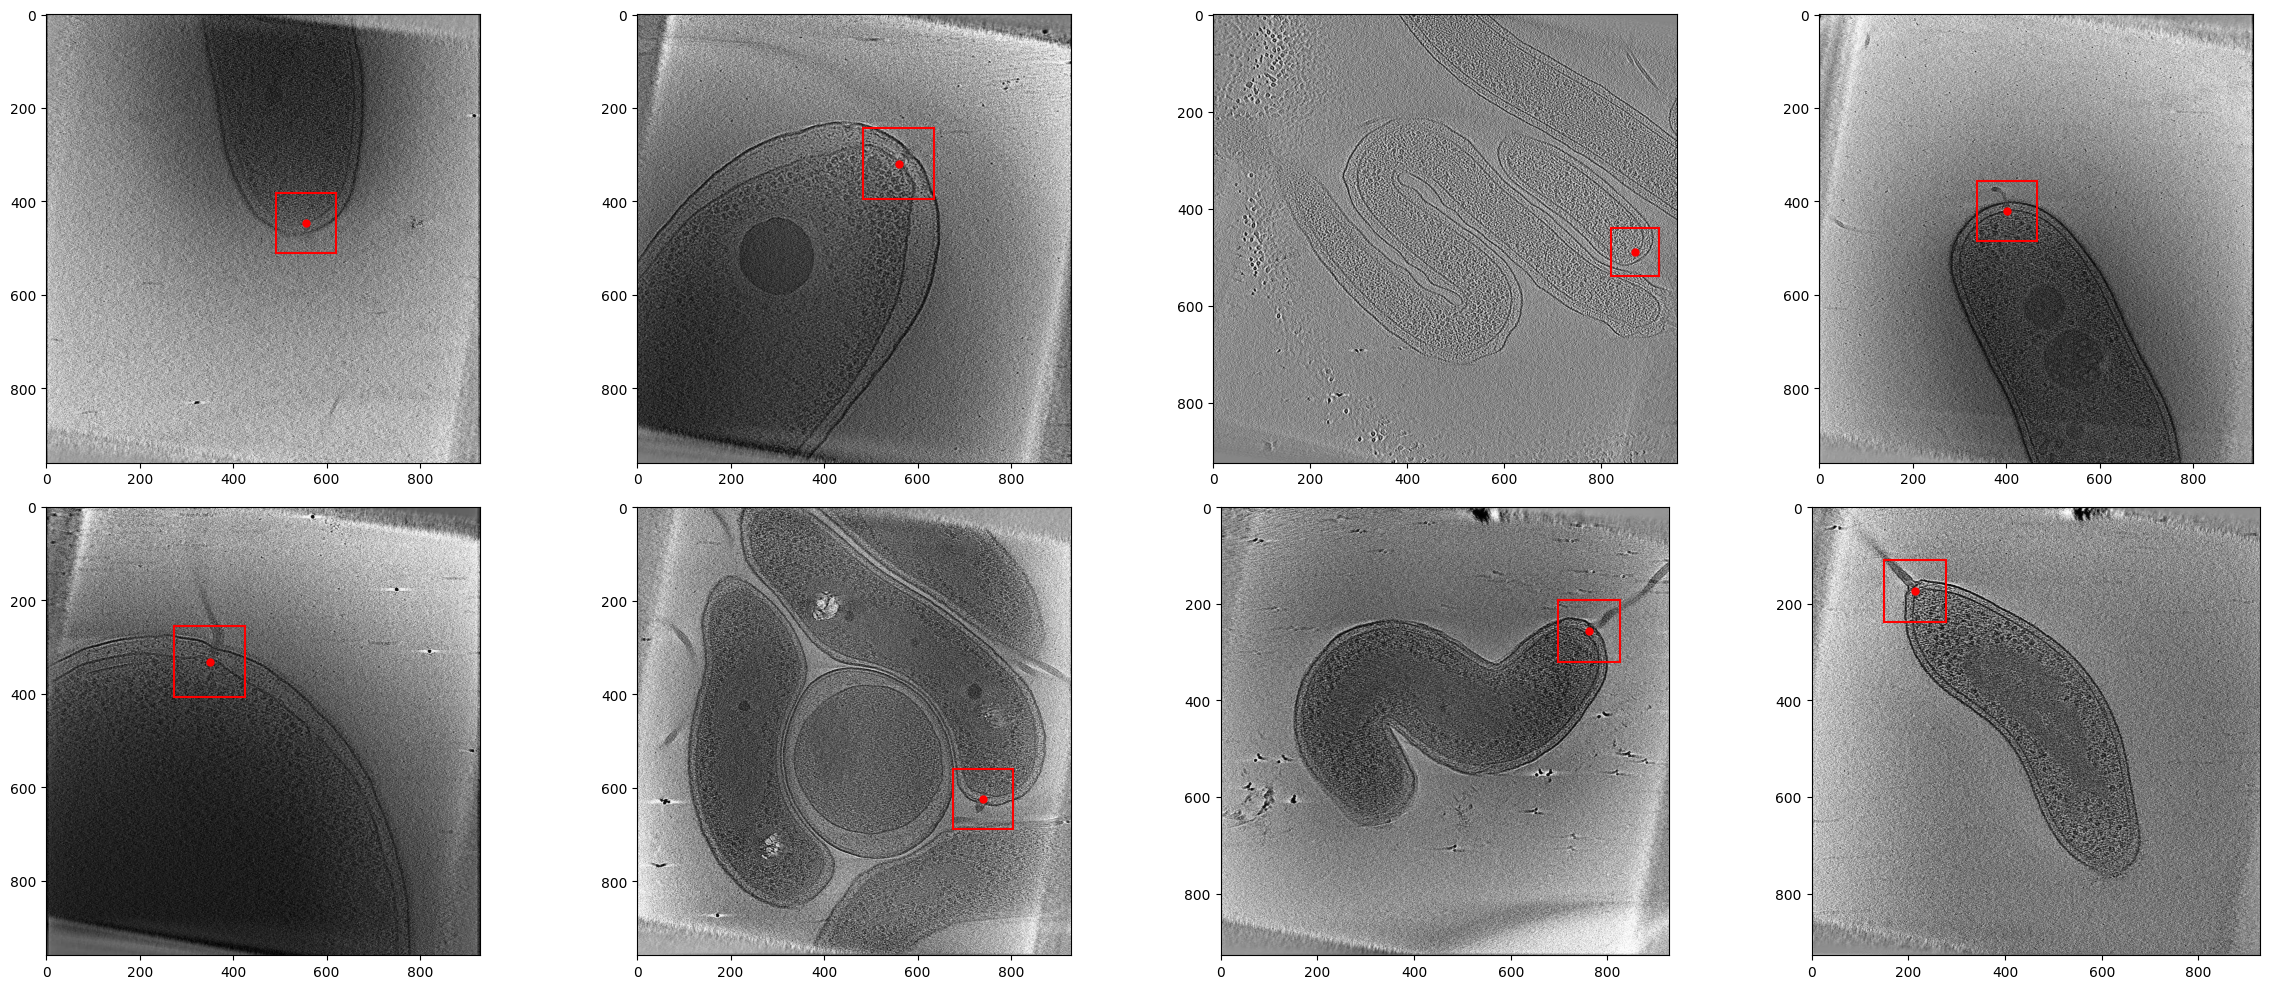

In [12]:
fig, axes = plt.subplots(2,4, figsize=(24, 10))
axes = axes.flatten()

imshow_idx = 0
for sample_idx in train_labels_df[train_labels_df['Number of motors']>0].sample(8, random_state=random_state).index:
    tomo_id = train_labels_df.tomo_id[sample_idx]
    z = train_labels_df.loc[sample_idx, 'Motor axis 0']
    img = cv2.imread(os.path.join(src_dir, tomo_id, f'slice_{int(z):04d}.jpg'))
    axes[imshow_idx].imshow(img)
    for df_idx in train_labels_df[(train_labels_df.tomo_id==tomo_id)&(train_labels_df['Motor axis 0']==z)].index:
        spacing = train_labels_df.loc[df_idx, 'Voxel spacing']
        box_length = int(max_allowed_radius / spacing)
        y = train_labels_df.loc[df_idx, 'Motor axis 1']
        x = train_labels_df.loc[df_idx, 'Motor axis 2']
        axes[imshow_idx].plot([x], [y], 'r.', markersize=10)
        axes[imshow_idx].plot([x-box_length,x+box_length], [y-box_length, y-box_length], 'r-')
        axes[imshow_idx].plot([x-box_length,x+box_length], [y+box_length, y+box_length], 'r-')
        axes[imshow_idx].plot([x-box_length,x-box_length], [y-box_length, y+box_length], 'r-')
        axes[imshow_idx].plot([x+box_length,x+box_length], [y-box_length, y+box_length], 'r-')
    imshow_idx += 1
    
plt.tight_layout()
plt.show()

# First stage training: positive-only images.
## Create dataset for positive-only images.

In [66]:
import os
import torch
import pandas as pd

from torchvision.io import read_image, ImageReadMode
from torchvision.ops.boxes import masks_to_boxes
from torchvision import tv_tensors
from torchvision.transforms.v2 import functional as F
from torchvision.transforms import v2 as T

In [14]:
class PosOnlyDataset(torch.utils.data.Dataset):
    def __init__(self, df, tomo_dir, transforms=None, max_allowed_radius=1000, max_length=2000):
        self.transforms = transforms
        self.tomo_dir = tomo_dir
        self.max_allowed_radius = max_allowed_radius
        self.df = df[df['Number of motors']>0]
        self.frame_tuples = list(set(zip(self.df['tomo_id'], self.df['Motor axis 0'])))
        self.max_length = max_length

    def __getitem__(self, idx):
        # load images and boxes
        tomo_id, z = self.frame_tuples[idx]
        img_path = os.path.join(self.tomo_dir, tomo_id, f'slice_{int(z):04d}.jpg')
        img = read_image(img_path, mode=ImageReadMode.RGB)
        ch, h, w = img.shape
        img_padded = torch.zeros((ch,max_length,max_length), dtype=img.dtype)
        img_padded[:,:h,:w] = img

        # get bounding box coordinates for each image
        bbs = self.df.loc[(self.df.tomo_id==tomo_id)&(self.df['Motor axis 0']==z), ['Motor axis 2', 'Motor axis 1', 'Voxel spacing']].values
        boxes = torch.tensor([[
            bb[0]-self.max_allowed_radius/bb[2],
            bb[1]-self.max_allowed_radius/bb[2],
            bb[0]+self.max_allowed_radius/bb[2],
            bb[1]+self.max_allowed_radius/bb[2]
        ] for bb in bbs])
        num_objs = len(boxes)
        
        # clamp the box coordinates
        box_min = torch.tensor([[0]*4]*num_objs)
        box_max = torch.tensor([[w-1,h-1,w-1,h-1]]*num_objs)
        boxes = torch.clamp(boxes, min=box_min, max=box_max)
        
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)

        image_id = idx
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        # Wrap sample and targets into torchvision tv_tensors:
        img_padded = tv_tensors.Image(img_padded)

        target = {}
        target["boxes"] = tv_tensors.BoundingBoxes(boxes, format="XYXY", canvas_size=F.get_size(img_padded))
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img_padded, target = self.transforms(img_padded, target)

        return img_padded, target

    def __len__(self):
        return len(self.frame_tuples)

In [15]:
def get_transform(train):
    transforms = []
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
        transforms.append(T.RandomAffine(
            5,
            translate=(0.01,0.01)
        ))
    transforms.append(T.ToDtype(torch.float, scale=True))
    transforms.append(T.ToPureTensor())
    return T.Compose(transforms)

## Create positive-only training and validation dataloaders.

In [16]:
# os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/engine.py")
# os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/utils.py")
# os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_utils.py")
# os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_eval.py")
# os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/transforms.py")

In [17]:
import utils

In [18]:
train_dataset = PosOnlyDataset(train_labels_df[train_labels_df.is_train], 'byu_dataset/train', transforms=get_transform(train=True))
val_dataset = PosOnlyDataset(train_labels_df[~train_labels_df.is_train], 'byu_dataset/train', transforms=get_transform(train=False))

In [19]:
train_dataloader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=2,
    shuffle=True,
    collate_fn=utils.collate_fn
)

In [20]:
val_dataloader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=4,
    shuffle=False,
    collate_fn=utils.collate_fn
)

## Set up training for sensitivity.

In [21]:
# !pip install wheel --upgrade
# !pip install Cython
# !sudo pip install --upgrade --force-reinstall pycocotools

In [22]:
from torchvision.models.detection.transform import GeneralizedRCNNTransform
from engine import train_one_epoch
from tqdm import tqdm
import os

In [23]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# load a model pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")

# replace the classifier with a new one, that has
# num_classes which is user-defined
num_classes = 2  # 1 class (person) + background
# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [24]:
max_length = 2000

In [25]:
model.transform = GeneralizedRCNNTransform(
    min_size=max_length, max_size=max_length, image_mean=[0.485, 0.456, 0.406], image_std=[0.229, 0.224, 0.225]
)

In [26]:
# train on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [27]:
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(
    params,
    lr=0.002,
    momentum=0.9,
    weight_decay=0.0005
)

# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=10,
    gamma=0.2
)

In [28]:
def evaluate_fbeta_pos_only(model, dataloader, device, max_allowed_radius=1000, beta=2, thres=None):
    model.to(device)
    model.eval()
    all_preds = []
    for imgs, _ in tqdm(dataloader):
        imgs = torch.stack(imgs, dim=0).to(device)
        with torch.no_grad():
            with torch.autocast(device_type="cuda"):
                preds = model(imgs)
            for i in range(len(preds)):
                nms_inds = torchvision.ops.nms(boxes=preds[i]['boxes'],
                                               scores=preds[i]['scores'],
                                               iou_threshold=.5
                                              )
                for field in ['boxes', 'labels', 'scores']:
                    preds[i][field] = preds[i][field][nms_inds].cpu().numpy().tolist()
            all_preds += preds
    eval_preds = dict(zip(dataloader.dataset.frame_tuples, all_preds))
    preds_df = {}
    for tomo_id, z in eval_preds:
        bbs = eval_preds[(tomo_id, z)]['boxes']
        scores = eval_preds[(tomo_id, z)]['scores']
        for i in range(len(bbs)):
            preds_df[len(preds_df)] = {
                'tomo_id': tomo_id,
                'Motor axis 0': z,
                'x_pred': .5*(bbs[i][0]+bbs[i][2]),
                'y_pred': .5*(bbs[i][1]+bbs[i][3]),
                'score': scores[i]
            }
    preds_df = pd.DataFrame.from_dict(preds_df, orient='index')
    if not thres is None:
        preds_df.loc[preds_df.score>=thres, 'score'] = 1.
        preds_df.loc[preds_df.score<thres, 'score'] = 0.
    preds_df = dataloader.dataset.df.merge(preds_df, how='left')
    preds_df['dist'] = ((preds_df['Motor axis 2']-preds_df.x_pred)**2+(preds_df['Motor axis 1']-preds_df.y_pred)**2)**.5*preds_df['Voxel spacing']
    preds_df['hit'] = preds_df.dist<=max_allowed_radius
    preds_df.loc[preds_df.hit!=True, 'hit_score'] = 0.
    preds_df.loc[preds_df.hit==True, 'hit_score'] = preds_df.loc[preds_df.hit==True, 'score']
    score_weighted_tp = preds_df.groupby(['tomo_id', 'Motor axis 0', 'Motor axis 1', 'Motor axis 2']).agg({'hit_score': 'max'}).hit_score.sum()
    score_weighted_fn = (1-preds_df.groupby(['tomo_id', 'Motor axis 0', 'Motor axis 1', 'Motor axis 2']).agg({'hit_score': 'max'}).hit_score).sum()
    preds_hit = preds_df.groupby(['tomo_id', 'Motor axis 0', 'x_pred', 'y_pred']).agg({'hit':'any'})
    preds_hit.columns = ['ever_hit']
    preds_hit = preds_hit.reset_index()
    preds_hit = preds_df.merge(preds_hit)
    score_weighted_fp = preds_hit[~preds_hit.ever_hit].groupby(['tomo_id', 'Motor axis 0', 'x_pred', 'y_pred']).agg({'score':'max'}).score.sum()
    score_weighted_fbeta = (1+beta**2)*score_weighted_tp/((1+beta**2)*score_weighted_tp+beta**2*score_weighted_fn+score_weighted_fp)
    return score_weighted_fbeta, score_weighted_tp, score_weighted_fn, score_weighted_fp

In [29]:
if os.path.isfile('best_fbeta_pos_only.pth'):
    model.load_state_dict(torch.load('best_fbeta_pos_only.pth',weights_only=True,map_location=device))
    best_fbeta, _,_,_ = evaluate_fbeta_pos_only(model, val_dataloader, device)
else:
    best_fbeta = 0.

100%|███████████████████████████████████████████| 37/37 [00:46<00:00,  1.25s/it]


In [34]:
# let's train it for some epochs
num_epochs = 20

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, train_dataloader, device, epoch, print_freq=50)
    # update the learning rate
#     lr_scheduler.step()
    # evaluate on the test dataset
    fbeta, tp, fn, fp = evaluate_fbeta_pos_only(model, val_dataloader, device)
    if fbeta > best_fbeta:
        best_fbeta = fbeta
        torch.save(model.state_dict(), 'best_fbeta_pos_only.pth')
        print(f'Best model at epoch {epoch}: Fbeta={fbeta:.4f}, TPs={tp:.4f}, FNs={fn:.4f}, FPs={fp:.4f}')

Epoch: [0]  [  0/152]  eta: 0:05:52  lr: 0.000015  loss: 0.0385 (0.0385)  loss_classifier: 0.0144 (0.0144)  loss_box_reg: 0.0239 (0.0239)  loss_objectness: 0.0000 (0.0000)  loss_rpn_box_reg: 0.0003 (0.0003)  time: 2.3183  data: 0.2958  max mem: 9258
Epoch: [0]  [ 50/152]  eta: 0:03:55  lr: 0.000677  loss: 0.0349 (0.0438)  loss_classifier: 0.0131 (0.0166)  loss_box_reg: 0.0216 (0.0268)  loss_objectness: 0.0000 (0.0000)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 2.3107  data: 0.2863  max mem: 9258
Epoch: [0]  [100/152]  eta: 0:02:00  lr: 0.001338  loss: 0.0313 (0.0406)  loss_classifier: 0.0123 (0.0155)  loss_box_reg: 0.0201 (0.0248)  loss_objectness: 0.0000 (0.0000)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 2.2957  data: 0.2676  max mem: 9258
Epoch: [0]  [150/152]  eta: 0:00:04  lr: 0.002000  loss: 0.0411 (0.0412)  loss_classifier: 0.0130 (0.0158)  loss_box_reg: 0.0275 (0.0251)  loss_objectness: 0.0000 (0.0001)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 2.3250  data: 0.2937  max mem: 9258


100%|███████████████████████████████████████████| 37/37 [00:44<00:00,  1.22s/it]


Best model at epoch 0: Fbeta=0.8733, TPs=133.0186, FNs=14.9814, FPs=36.5330
Epoch: [1]  [  0/152]  eta: 0:05:57  lr: 0.002000  loss: 0.0503 (0.0503)  loss_classifier: 0.0329 (0.0329)  loss_box_reg: 0.0168 (0.0168)  loss_objectness: 0.0001 (0.0001)  loss_rpn_box_reg: 0.0005 (0.0005)  time: 2.3487  data: 0.3046  max mem: 9258
Epoch: [1]  [ 50/152]  eta: 0:03:55  lr: 0.002000  loss: 0.0381 (0.0451)  loss_classifier: 0.0116 (0.0173)  loss_box_reg: 0.0247 (0.0275)  loss_objectness: 0.0000 (0.0000)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 2.2932  data: 0.2700  max mem: 9258
Epoch: [1]  [100/152]  eta: 0:01:59  lr: 0.002000  loss: 0.0412 (0.0452)  loss_classifier: 0.0146 (0.0175)  loss_box_reg: 0.0250 (0.0273)  loss_objectness: 0.0000 (0.0000)  loss_rpn_box_reg: 0.0003 (0.0003)  time: 2.3010  data: 0.2726  max mem: 9258
Epoch: [1]  [150/152]  eta: 0:00:04  lr: 0.002000  loss: 0.0460 (0.0485)  loss_classifier: 0.0143 (0.0189)  loss_box_reg: 0.0248 (0.0290)  loss_objectness: 0.0000 (0.0003)  l

100%|███████████████████████████████████████████| 37/37 [00:45<00:00,  1.22s/it]


Best model at epoch 1: Fbeta=0.8775, TPs=134.5061, FNs=13.4939, FPs=39.9306
Epoch: [2]  [  0/152]  eta: 0:05:53  lr: 0.002000  loss: 0.0202 (0.0202)  loss_classifier: 0.0082 (0.0082)  loss_box_reg: 0.0119 (0.0119)  loss_objectness: 0.0000 (0.0000)  loss_rpn_box_reg: 0.0001 (0.0001)  time: 2.3270  data: 0.3095  max mem: 9258
Epoch: [2]  [ 50/152]  eta: 0:03:57  lr: 0.002000  loss: 0.0395 (0.0485)  loss_classifier: 0.0128 (0.0208)  loss_box_reg: 0.0257 (0.0269)  loss_objectness: 0.0000 (0.0004)  loss_rpn_box_reg: 0.0002 (0.0004)  time: 2.3319  data: 0.3036  max mem: 9258
Epoch: [2]  [100/152]  eta: 0:02:01  lr: 0.002000  loss: 0.0424 (0.0457)  loss_classifier: 0.0174 (0.0192)  loss_box_reg: 0.0274 (0.0259)  loss_objectness: 0.0000 (0.0002)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 2.3339  data: 0.3028  max mem: 9258
Epoch: [2]  [150/152]  eta: 0:00:04  lr: 0.002000  loss: 0.0352 (0.0456)  loss_classifier: 0.0121 (0.0185)  loss_box_reg: 0.0250 (0.0266)  loss_objectness: 0.0000 (0.0002)  l

100%|███████████████████████████████████████████| 37/37 [00:44<00:00,  1.22s/it]


Epoch: [3]  [  0/152]  eta: 0:05:51  lr: 0.002000  loss: 0.0457 (0.0457)  loss_classifier: 0.0109 (0.0109)  loss_box_reg: 0.0344 (0.0344)  loss_objectness: 0.0000 (0.0000)  loss_rpn_box_reg: 0.0003 (0.0003)  time: 2.3119  data: 0.2906  max mem: 9258
Epoch: [3]  [ 50/152]  eta: 0:03:56  lr: 0.002000  loss: 0.0378 (0.0420)  loss_classifier: 0.0126 (0.0173)  loss_box_reg: 0.0194 (0.0240)  loss_objectness: 0.0000 (0.0004)  loss_rpn_box_reg: 0.0002 (0.0002)  time: 2.3253  data: 0.2962  max mem: 9258
Epoch: [3]  [100/152]  eta: 0:02:00  lr: 0.002000  loss: 0.0360 (0.0433)  loss_classifier: 0.0111 (0.0175)  loss_box_reg: 0.0242 (0.0252)  loss_objectness: 0.0000 (0.0002)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 2.3260  data: 0.2991  max mem: 9258
Epoch: [3]  [150/152]  eta: 0:00:04  lr: 0.002000  loss: 0.0448 (0.0440)  loss_classifier: 0.0162 (0.0173)  loss_box_reg: 0.0228 (0.0262)  loss_objectness: 0.0000 (0.0002)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 2.3325  data: 0.3021  max mem: 9258


100%|███████████████████████████████████████████| 37/37 [00:45<00:00,  1.22s/it]


Epoch: [4]  [  0/152]  eta: 0:05:54  lr: 0.002000  loss: 0.0281 (0.0281)  loss_classifier: 0.0062 (0.0062)  loss_box_reg: 0.0218 (0.0218)  loss_objectness: 0.0000 (0.0000)  loss_rpn_box_reg: 0.0002 (0.0002)  time: 2.3326  data: 0.3138  max mem: 9258
Epoch: [4]  [ 50/152]  eta: 0:03:57  lr: 0.002000  loss: 0.0497 (0.0479)  loss_classifier: 0.0189 (0.0175)  loss_box_reg: 0.0282 (0.0299)  loss_objectness: 0.0000 (0.0003)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 2.3137  data: 0.2872  max mem: 9258
Epoch: [4]  [100/152]  eta: 0:02:00  lr: 0.002000  loss: 0.0350 (0.0453)  loss_classifier: 0.0126 (0.0174)  loss_box_reg: 0.0223 (0.0274)  loss_objectness: 0.0000 (0.0002)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 2.3244  data: 0.2965  max mem: 9258
Epoch: [4]  [150/152]  eta: 0:00:04  lr: 0.002000  loss: 0.0371 (0.0449)  loss_classifier: 0.0113 (0.0169)  loss_box_reg: 0.0257 (0.0276)  loss_objectness: 0.0000 (0.0002)  loss_rpn_box_reg: 0.0003 (0.0003)  time: 2.3185  data: 0.2917  max mem: 9258


100%|███████████████████████████████████████████| 37/37 [00:45<00:00,  1.23s/it]


Epoch: [5]  [  0/152]  eta: 0:06:04  lr: 0.002000  loss: 0.0348 (0.0348)  loss_classifier: 0.0179 (0.0179)  loss_box_reg: 0.0159 (0.0159)  loss_objectness: 0.0006 (0.0006)  loss_rpn_box_reg: 0.0004 (0.0004)  time: 2.3961  data: 0.3777  max mem: 9258
Epoch: [5]  [ 50/152]  eta: 0:03:57  lr: 0.002000  loss: 0.0332 (0.0383)  loss_classifier: 0.0137 (0.0139)  loss_box_reg: 0.0190 (0.0241)  loss_objectness: 0.0000 (0.0001)  loss_rpn_box_reg: 0.0002 (0.0002)  time: 2.3230  data: 0.2921  max mem: 9258
Epoch: [5]  [100/152]  eta: 0:02:01  lr: 0.002000  loss: 0.0350 (0.0393)  loss_classifier: 0.0123 (0.0146)  loss_box_reg: 0.0233 (0.0244)  loss_objectness: 0.0000 (0.0000)  loss_rpn_box_reg: 0.0002 (0.0002)  time: 2.3249  data: 0.2924  max mem: 9258
Epoch: [5]  [150/152]  eta: 0:00:04  lr: 0.002000  loss: 0.0414 (0.0428)  loss_classifier: 0.0138 (0.0161)  loss_box_reg: 0.0265 (0.0264)  loss_objectness: 0.0000 (0.0001)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 2.3208  data: 0.2935  max mem: 9258


100%|███████████████████████████████████████████| 37/37 [00:44<00:00,  1.21s/it]


Epoch: [6]  [  0/152]  eta: 0:05:55  lr: 0.002000  loss: 0.0486 (0.0486)  loss_classifier: 0.0190 (0.0190)  loss_box_reg: 0.0291 (0.0291)  loss_objectness: 0.0000 (0.0000)  loss_rpn_box_reg: 0.0005 (0.0005)  time: 2.3359  data: 0.3108  max mem: 9258
Epoch: [6]  [ 50/152]  eta: 0:03:56  lr: 0.002000  loss: 0.0414 (0.0509)  loss_classifier: 0.0117 (0.0218)  loss_box_reg: 0.0261 (0.0286)  loss_objectness: 0.0000 (0.0002)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 2.3131  data: 0.2898  max mem: 9258
Epoch: [6]  [100/152]  eta: 0:02:00  lr: 0.002000  loss: 0.0325 (0.0460)  loss_classifier: 0.0127 (0.0189)  loss_box_reg: 0.0194 (0.0268)  loss_objectness: 0.0000 (0.0001)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 2.3210  data: 0.2976  max mem: 9258
Epoch: [6]  [150/152]  eta: 0:00:04  lr: 0.002000  loss: 0.0425 (0.0459)  loss_classifier: 0.0156 (0.0184)  loss_box_reg: 0.0319 (0.0271)  loss_objectness: 0.0000 (0.0002)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 2.3087  data: 0.2835  max mem: 9258


100%|███████████████████████████████████████████| 37/37 [00:44<00:00,  1.21s/it]


Epoch: [7]  [  0/152]  eta: 0:05:56  lr: 0.002000  loss: 0.0300 (0.0300)  loss_classifier: 0.0155 (0.0155)  loss_box_reg: 0.0144 (0.0144)  loss_objectness: 0.0000 (0.0000)  loss_rpn_box_reg: 0.0001 (0.0001)  time: 2.3475  data: 0.3148  max mem: 9258
Epoch: [7]  [ 50/152]  eta: 0:03:55  lr: 0.002000  loss: 0.0425 (0.0441)  loss_classifier: 0.0145 (0.0184)  loss_box_reg: 0.0240 (0.0250)  loss_objectness: 0.0000 (0.0004)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 2.3114  data: 0.2867  max mem: 9258
Epoch: [7]  [100/152]  eta: 0:02:00  lr: 0.002000  loss: 0.0436 (0.0432)  loss_classifier: 0.0108 (0.0172)  loss_box_reg: 0.0258 (0.0254)  loss_objectness: 0.0000 (0.0002)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 2.3335  data: 0.3031  max mem: 9258
Epoch: [7]  [150/152]  eta: 0:00:04  lr: 0.002000  loss: 0.0340 (0.0435)  loss_classifier: 0.0117 (0.0174)  loss_box_reg: 0.0221 (0.0256)  loss_objectness: 0.0000 (0.0002)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 2.3302  data: 0.3003  max mem: 9258


100%|███████████████████████████████████████████| 37/37 [00:45<00:00,  1.22s/it]


Epoch: [8]  [  0/152]  eta: 0:06:07  lr: 0.002000  loss: 0.0188 (0.0188)  loss_classifier: 0.0081 (0.0081)  loss_box_reg: 0.0106 (0.0106)  loss_objectness: 0.0001 (0.0001)  loss_rpn_box_reg: 0.0000 (0.0000)  time: 2.4185  data: 0.3983  max mem: 9258
Epoch: [8]  [ 50/152]  eta: 0:03:56  lr: 0.002000  loss: 0.0279 (0.0381)  loss_classifier: 0.0101 (0.0139)  loss_box_reg: 0.0187 (0.0239)  loss_objectness: 0.0000 (0.0001)  loss_rpn_box_reg: 0.0001 (0.0002)  time: 2.3052  data: 0.2802  max mem: 9258
Epoch: [8]  [100/152]  eta: 0:02:00  lr: 0.002000  loss: 0.0401 (0.0416)  loss_classifier: 0.0130 (0.0156)  loss_box_reg: 0.0246 (0.0256)  loss_objectness: 0.0000 (0.0001)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 2.3128  data: 0.2865  max mem: 9258
Epoch: [8]  [150/152]  eta: 0:00:04  lr: 0.002000  loss: 0.0418 (0.0421)  loss_classifier: 0.0151 (0.0165)  loss_box_reg: 0.0221 (0.0252)  loss_objectness: 0.0000 (0.0001)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 2.3182  data: 0.2905  max mem: 9258


100%|███████████████████████████████████████████| 37/37 [00:44<00:00,  1.21s/it]


Epoch: [9]  [  0/152]  eta: 0:05:54  lr: 0.002000  loss: 0.0156 (0.0156)  loss_classifier: 0.0048 (0.0048)  loss_box_reg: 0.0107 (0.0107)  loss_objectness: 0.0000 (0.0000)  loss_rpn_box_reg: 0.0001 (0.0001)  time: 2.3315  data: 0.3020  max mem: 9258
Epoch: [9]  [ 50/152]  eta: 0:03:56  lr: 0.002000  loss: 0.0351 (0.0377)  loss_classifier: 0.0103 (0.0142)  loss_box_reg: 0.0214 (0.0233)  loss_objectness: 0.0000 (0.0000)  loss_rpn_box_reg: 0.0002 (0.0002)  time: 2.3258  data: 0.2974  max mem: 9258
Epoch: [9]  [100/152]  eta: 0:02:01  lr: 0.002000  loss: 0.0439 (0.0409)  loss_classifier: 0.0132 (0.0158)  loss_box_reg: 0.0234 (0.0247)  loss_objectness: 0.0000 (0.0001)  loss_rpn_box_reg: 0.0002 (0.0002)  time: 2.3502  data: 0.3186  max mem: 9258
Epoch: [9]  [150/152]  eta: 0:00:04  lr: 0.002000  loss: 0.0347 (0.0419)  loss_classifier: 0.0120 (0.0168)  loss_box_reg: 0.0203 (0.0247)  loss_objectness: 0.0000 (0.0001)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 2.3252  data: 0.2968  max mem: 9258


100%|███████████████████████████████████████████| 37/37 [00:44<00:00,  1.21s/it]


Epoch: [10]  [  0/152]  eta: 0:05:55  lr: 0.002000  loss: 0.0156 (0.0156)  loss_classifier: 0.0076 (0.0076)  loss_box_reg: 0.0078 (0.0078)  loss_objectness: 0.0000 (0.0000)  loss_rpn_box_reg: 0.0002 (0.0002)  time: 2.3359  data: 0.3129  max mem: 9258
Epoch: [10]  [ 50/152]  eta: 0:03:57  lr: 0.002000  loss: 0.0297 (0.0392)  loss_classifier: 0.0099 (0.0146)  loss_box_reg: 0.0210 (0.0243)  loss_objectness: 0.0000 (0.0001)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 2.3168  data: 0.2939  max mem: 9258
Epoch: [10]  [100/152]  eta: 0:02:00  lr: 0.002000  loss: 0.0356 (0.0385)  loss_classifier: 0.0096 (0.0143)  loss_box_reg: 0.0219 (0.0240)  loss_objectness: 0.0000 (0.0000)  loss_rpn_box_reg: 0.0001 (0.0002)  time: 2.3245  data: 0.2966  max mem: 9258
Epoch: [10]  [150/152]  eta: 0:00:04  lr: 0.002000  loss: 0.0298 (0.0398)  loss_classifier: 0.0110 (0.0156)  loss_box_reg: 0.0186 (0.0239)  loss_objectness: 0.0000 (0.0001)  loss_rpn_box_reg: 0.0002 (0.0002)  time: 2.3302  data: 0.2989  max mem: 9

100%|███████████████████████████████████████████| 37/37 [00:44<00:00,  1.21s/it]


Epoch: [11]  [  0/152]  eta: 0:05:55  lr: 0.002000  loss: 0.0636 (0.0636)  loss_classifier: 0.0453 (0.0453)  loss_box_reg: 0.0183 (0.0183)  loss_objectness: 0.0000 (0.0000)  loss_rpn_box_reg: 0.0001 (0.0001)  time: 2.3364  data: 0.3064  max mem: 9258
Epoch: [11]  [ 50/152]  eta: 0:03:58  lr: 0.002000  loss: 0.0361 (0.0434)  loss_classifier: 0.0121 (0.0183)  loss_box_reg: 0.0197 (0.0247)  loss_objectness: 0.0000 (0.0003)  loss_rpn_box_reg: 0.0002 (0.0002)  time: 2.3227  data: 0.2950  max mem: 9258
Epoch: [11]  [100/152]  eta: 0:02:01  lr: 0.002000  loss: 0.0349 (0.0410)  loss_classifier: 0.0109 (0.0170)  loss_box_reg: 0.0226 (0.0236)  loss_objectness: 0.0000 (0.0002)  loss_rpn_box_reg: 0.0002 (0.0002)  time: 2.3251  data: 0.2972  max mem: 9258
Epoch: [11]  [150/152]  eta: 0:00:04  lr: 0.002000  loss: 0.0334 (0.0394)  loss_classifier: 0.0120 (0.0157)  loss_box_reg: 0.0201 (0.0232)  loss_objectness: 0.0000 (0.0002)  loss_rpn_box_reg: 0.0002 (0.0002)  time: 2.3311  data: 0.3002  max mem: 9

100%|███████████████████████████████████████████| 37/37 [00:44<00:00,  1.21s/it]


Epoch: [12]  [  0/152]  eta: 0:05:53  lr: 0.002000  loss: 0.0347 (0.0347)  loss_classifier: 0.0081 (0.0081)  loss_box_reg: 0.0264 (0.0264)  loss_objectness: 0.0000 (0.0000)  loss_rpn_box_reg: 0.0002 (0.0002)  time: 2.3231  data: 0.2938  max mem: 9258
Epoch: [12]  [ 50/152]  eta: 0:03:57  lr: 0.002000  loss: 0.0304 (0.0382)  loss_classifier: 0.0111 (0.0144)  loss_box_reg: 0.0198 (0.0235)  loss_objectness: 0.0000 (0.0001)  loss_rpn_box_reg: 0.0002 (0.0002)  time: 2.3284  data: 0.2991  max mem: 9258
Epoch: [12]  [100/152]  eta: 0:02:01  lr: 0.002000  loss: 0.0356 (0.0395)  loss_classifier: 0.0114 (0.0151)  loss_box_reg: 0.0206 (0.0241)  loss_objectness: 0.0000 (0.0001)  loss_rpn_box_reg: 0.0001 (0.0002)  time: 2.3506  data: 0.3224  max mem: 9258
Epoch: [12]  [150/152]  eta: 0:00:04  lr: 0.002000  loss: 0.0278 (0.0375)  loss_classifier: 0.0087 (0.0143)  loss_box_reg: 0.0153 (0.0230)  loss_objectness: 0.0000 (0.0001)  loss_rpn_box_reg: 0.0002 (0.0002)  time: 2.3284  data: 0.2987  max mem: 9

100%|███████████████████████████████████████████| 37/37 [00:44<00:00,  1.21s/it]


Epoch: [13]  [  0/152]  eta: 0:05:54  lr: 0.002000  loss: 0.0192 (0.0192)  loss_classifier: 0.0071 (0.0071)  loss_box_reg: 0.0120 (0.0120)  loss_objectness: 0.0000 (0.0000)  loss_rpn_box_reg: 0.0001 (0.0001)  time: 2.3329  data: 0.3059  max mem: 9258
Epoch: [13]  [ 50/152]  eta: 0:03:57  lr: 0.002000  loss: 0.0310 (0.0371)  loss_classifier: 0.0111 (0.0140)  loss_box_reg: 0.0213 (0.0227)  loss_objectness: 0.0000 (0.0001)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 2.3309  data: 0.3046  max mem: 9258
Epoch: [13]  [100/152]  eta: 0:02:01  lr: 0.002000  loss: 0.0385 (0.0396)  loss_classifier: 0.0132 (0.0153)  loss_box_reg: 0.0235 (0.0239)  loss_objectness: 0.0000 (0.0001)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 2.3275  data: 0.2997  max mem: 9258
Epoch: [13]  [150/152]  eta: 0:00:04  lr: 0.002000  loss: 0.0294 (0.0373)  loss_classifier: 0.0080 (0.0140)  loss_box_reg: 0.0177 (0.0229)  loss_objectness: 0.0000 (0.0001)  loss_rpn_box_reg: 0.0001 (0.0002)  time: 2.3223  data: 0.2956  max mem: 9

100%|███████████████████████████████████████████| 37/37 [00:44<00:00,  1.21s/it]


Epoch: [14]  [  0/152]  eta: 0:05:54  lr: 0.002000  loss: 0.0334 (0.0334)  loss_classifier: 0.0181 (0.0181)  loss_box_reg: 0.0153 (0.0153)  loss_objectness: 0.0000 (0.0000)  loss_rpn_box_reg: 0.0000 (0.0000)  time: 2.3340  data: 0.3134  max mem: 9258
Epoch: [14]  [ 50/152]  eta: 0:03:58  lr: 0.002000  loss: 0.0329 (0.0381)  loss_classifier: 0.0106 (0.0132)  loss_box_reg: 0.0216 (0.0247)  loss_objectness: 0.0000 (0.0000)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 2.3270  data: 0.2959  max mem: 9258
Epoch: [14]  [100/152]  eta: 0:02:01  lr: 0.002000  loss: 0.0331 (0.0364)  loss_classifier: 0.0104 (0.0131)  loss_box_reg: 0.0211 (0.0230)  loss_objectness: 0.0000 (0.0001)  loss_rpn_box_reg: 0.0001 (0.0003)  time: 2.3216  data: 0.2951  max mem: 9258
Epoch: [14]  [150/152]  eta: 0:00:04  lr: 0.002000  loss: 0.0339 (0.0369)  loss_classifier: 0.0115 (0.0134)  loss_box_reg: 0.0197 (0.0232)  loss_objectness: 0.0000 (0.0001)  loss_rpn_box_reg: 0.0001 (0.0003)  time: 2.3220  data: 0.2948  max mem: 9

100%|███████████████████████████████████████████| 37/37 [00:44<00:00,  1.21s/it]


Epoch: [15]  [  0/152]  eta: 0:05:53  lr: 0.002000  loss: 0.0179 (0.0179)  loss_classifier: 0.0041 (0.0041)  loss_box_reg: 0.0136 (0.0136)  loss_objectness: 0.0000 (0.0000)  loss_rpn_box_reg: 0.0002 (0.0002)  time: 2.3289  data: 0.3020  max mem: 9258
Epoch: [15]  [ 50/152]  eta: 0:03:57  lr: 0.002000  loss: 0.0358 (0.0361)  loss_classifier: 0.0101 (0.0142)  loss_box_reg: 0.0191 (0.0216)  loss_objectness: 0.0000 (0.0002)  loss_rpn_box_reg: 0.0002 (0.0002)  time: 2.3300  data: 0.2992  max mem: 9258
Epoch: [15]  [100/152]  eta: 0:02:01  lr: 0.002000  loss: 0.0333 (0.0384)  loss_classifier: 0.0110 (0.0153)  loss_box_reg: 0.0211 (0.0227)  loss_objectness: 0.0000 (0.0001)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 2.3482  data: 0.3183  max mem: 9258
Epoch: [15]  [150/152]  eta: 0:00:04  lr: 0.002000  loss: 0.0287 (0.0387)  loss_classifier: 0.0089 (0.0154)  loss_box_reg: 0.0172 (0.0228)  loss_objectness: 0.0000 (0.0002)  loss_rpn_box_reg: 0.0001 (0.0003)  time: 2.3237  data: 0.2959  max mem: 9

100%|███████████████████████████████████████████| 37/37 [00:44<00:00,  1.21s/it]


Epoch: [16]  [  0/152]  eta: 0:05:56  lr: 0.002000  loss: 0.0154 (0.0154)  loss_classifier: 0.0039 (0.0039)  loss_box_reg: 0.0114 (0.0114)  loss_objectness: 0.0000 (0.0000)  loss_rpn_box_reg: 0.0002 (0.0002)  time: 2.3465  data: 0.3058  max mem: 9258
Epoch: [16]  [ 50/152]  eta: 0:03:57  lr: 0.002000  loss: 0.0370 (0.0401)  loss_classifier: 0.0116 (0.0137)  loss_box_reg: 0.0233 (0.0262)  loss_objectness: 0.0000 (0.0001)  loss_rpn_box_reg: 0.0001 (0.0002)  time: 2.3230  data: 0.2975  max mem: 9258
Epoch: [16]  [100/152]  eta: 0:02:00  lr: 0.002000  loss: 0.0316 (0.0391)  loss_classifier: 0.0103 (0.0147)  loss_box_reg: 0.0190 (0.0241)  loss_objectness: 0.0000 (0.0002)  loss_rpn_box_reg: 0.0001 (0.0002)  time: 2.3215  data: 0.2932  max mem: 9258
Epoch: [16]  [150/152]  eta: 0:00:04  lr: 0.002000  loss: 0.0321 (0.0377)  loss_classifier: 0.0096 (0.0142)  loss_box_reg: 0.0232 (0.0231)  loss_objectness: 0.0000 (0.0002)  loss_rpn_box_reg: 0.0001 (0.0002)  time: 2.3279  data: 0.2970  max mem: 9

100%|███████████████████████████████████████████| 37/37 [00:44<00:00,  1.21s/it]


Epoch: [17]  [  0/152]  eta: 0:05:52  lr: 0.002000  loss: 0.0350 (0.0350)  loss_classifier: 0.0143 (0.0143)  loss_box_reg: 0.0207 (0.0207)  loss_objectness: 0.0000 (0.0000)  loss_rpn_box_reg: 0.0000 (0.0000)  time: 2.3173  data: 0.2994  max mem: 9258
Epoch: [17]  [ 50/152]  eta: 0:03:57  lr: 0.002000  loss: 0.0326 (0.0364)  loss_classifier: 0.0076 (0.0116)  loss_box_reg: 0.0209 (0.0243)  loss_objectness: 0.0000 (0.0002)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 2.3215  data: 0.2945  max mem: 9258
Epoch: [17]  [100/152]  eta: 0:02:00  lr: 0.002000  loss: 0.0328 (0.0371)  loss_classifier: 0.0099 (0.0135)  loss_box_reg: 0.0211 (0.0232)  loss_objectness: 0.0000 (0.0001)  loss_rpn_box_reg: 0.0001 (0.0002)  time: 2.3211  data: 0.2942  max mem: 9258
Epoch: [17]  [150/152]  eta: 0:00:04  lr: 0.002000  loss: 0.0327 (0.0358)  loss_classifier: 0.0105 (0.0133)  loss_box_reg: 0.0197 (0.0221)  loss_objectness: 0.0000 (0.0001)  loss_rpn_box_reg: 0.0001 (0.0002)  time: 2.3181  data: 0.2909  max mem: 9

100%|███████████████████████████████████████████| 37/37 [00:44<00:00,  1.21s/it]


Epoch: [18]  [  0/152]  eta: 0:05:53  lr: 0.002000  loss: 0.0526 (0.0526)  loss_classifier: 0.0259 (0.0259)  loss_box_reg: 0.0263 (0.0263)  loss_objectness: 0.0001 (0.0001)  loss_rpn_box_reg: 0.0004 (0.0004)  time: 2.3238  data: 0.3025  max mem: 9258
Epoch: [18]  [ 50/152]  eta: 0:03:56  lr: 0.002000  loss: 0.0272 (0.0326)  loss_classifier: 0.0097 (0.0125)  loss_box_reg: 0.0170 (0.0199)  loss_objectness: 0.0000 (0.0000)  loss_rpn_box_reg: 0.0001 (0.0002)  time: 2.3213  data: 0.2940  max mem: 9258
Epoch: [18]  [100/152]  eta: 0:02:01  lr: 0.002000  loss: 0.0373 (0.0358)  loss_classifier: 0.0099 (0.0135)  loss_box_reg: 0.0262 (0.0220)  loss_objectness: 0.0000 (0.0000)  loss_rpn_box_reg: 0.0001 (0.0002)  time: 2.3600  data: 0.3320  max mem: 9258
Epoch: [18]  [150/152]  eta: 0:00:04  lr: 0.002000  loss: 0.0333 (0.0364)  loss_classifier: 0.0103 (0.0138)  loss_box_reg: 0.0217 (0.0223)  loss_objectness: 0.0000 (0.0001)  loss_rpn_box_reg: 0.0002 (0.0002)  time: 2.3277  data: 0.2988  max mem: 9

100%|███████████████████████████████████████████| 37/37 [00:44<00:00,  1.21s/it]


Epoch: [19]  [  0/152]  eta: 0:05:53  lr: 0.002000  loss: 0.0187 (0.0187)  loss_classifier: 0.0052 (0.0052)  loss_box_reg: 0.0133 (0.0133)  loss_objectness: 0.0000 (0.0000)  loss_rpn_box_reg: 0.0002 (0.0002)  time: 2.3227  data: 0.3033  max mem: 9258
Epoch: [19]  [ 50/152]  eta: 0:03:57  lr: 0.002000  loss: 0.0320 (0.0335)  loss_classifier: 0.0117 (0.0116)  loss_box_reg: 0.0192 (0.0216)  loss_objectness: 0.0000 (0.0001)  loss_rpn_box_reg: 0.0002 (0.0002)  time: 2.3299  data: 0.3014  max mem: 9258
Epoch: [19]  [100/152]  eta: 0:02:01  lr: 0.002000  loss: 0.0336 (0.0333)  loss_classifier: 0.0079 (0.0118)  loss_box_reg: 0.0219 (0.0213)  loss_objectness: 0.0000 (0.0000)  loss_rpn_box_reg: 0.0001 (0.0002)  time: 2.3308  data: 0.3004  max mem: 9258
Epoch: [19]  [150/152]  eta: 0:00:04  lr: 0.002000  loss: 0.0293 (0.0340)  loss_classifier: 0.0105 (0.0128)  loss_box_reg: 0.0178 (0.0208)  loss_objectness: 0.0000 (0.0001)  loss_rpn_box_reg: 0.0001 (0.0002)  time: 2.3277  data: 0.2959  max mem: 9

100%|███████████████████████████████████████████| 37/37 [00:44<00:00,  1.21s/it]


In [29]:
model.load_state_dict(torch.load('best_fbeta_pos_only.pth',weights_only=True,map_location=device))
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(2000,), max_size=2000, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU

In [31]:
thres = .7
fbeta, tp, fn, fp = evaluate_fbeta_pos_only(model, val_dataloader, device, thres=thres)
print(f'At threshold of {thres}, Fbeta={fbeta:.4f}, TP={tp:.0f}, FN={fn:.0f}, FP={fp:.0f}')

100%|███████████████████████████████████████████| 37/37 [00:43<00:00,  1.19s/it]

At threshold of 0.7, Fbeta=0.8983, TP=136, FN=12, FP=29


# Infer over the negative validation set to understand efficacy and prepare for extension to negative tomograms.
## The plan is to pick the highest scoring slice per tomogram for combining with the annotated slices of positive tomograms to form a smaller set for in-training validation. Without training with negative tomograms previously, the negative tomograms all have very high scores.

In [13]:
import glob
import json
import numpy as np

In [40]:
neg_val_tomo_ids = train_labels_df.tomo_id[(~train_labels_df.is_train)&(train_labels_df['Number of motors']==0)]

In [41]:
neg_val_tomo_slice_paths = []
for tomo_id in neg_val_tomo_ids:
    neg_val_tomo_slice_paths += glob.glob(f'byu_dataset/train/{tomo_id}/*.jpg')

In [31]:
class NoLabelDataset(torch.utils.data.Dataset):
    def __init__(self, path_list, transforms=None, max_length=2000):
        self.transforms = transforms
        self.imgs = path_list

    def __getitem__(self, idx):
        # load images
        img_path = self.imgs[idx]
        img = read_image(img_path, mode=ImageReadMode.RGB)
        ch, h, w = img.shape
        img_padded = torch.zeros((ch,max_length,max_length), dtype=img.dtype)
        img_padded[:,:h,:w] = img

        if self.transforms is not None:
            img_padded = self.transforms(img_padded)

        return img_padded

    def __len__(self):
        return len(self.imgs)

In [42]:
neg_val_tomo_slices_dataset = NoLabelDataset(neg_val_tomo_slice_paths, transforms=get_transform(train=False))
neg_val_tomo_slices_dataloader = torch.utils.data.DataLoader(
    neg_val_tomo_slices_dataset,
    batch_size=4,
    shuffle=False
)

In [35]:
model.to(device)
model.eval()
all_preds = []
for imgs in tqdm(neg_val_tomo_slices_dataloader):
    imgs = imgs.to(device)
    with torch.no_grad():
        with torch.autocast(device_type="cuda"):
            preds = model(imgs)
        for i in range(len(preds)):
            nms_inds = torchvision.ops.nms(boxes=preds[i]['boxes'],
                                           scores=preds[i]['scores'],
                                           iou_threshold=.5
                                          )
            for field in ['boxes', 'labels', 'scores']:
                preds[i][field] = preds[i][field][nms_inds].cpu().numpy().tolist()
        all_preds += preds
eval_preds = dict(zip(neg_val_tomo_slices_dataloader.dataset.imgs, all_preds))

100%|███████████████████████████████████| 12175/12175 [3:40:29<00:00,  1.09s/it]


In [39]:
with open('byu_dataset/neg_val_best_pos_only_fbeta_preds.json', 'w') as f:
    json.dump(eval_preds, f, indent=1)

In [14]:
with open('byu_dataset/neg_val_best_pos_only_fbeta_preds.json') as f:
    eval_preds = json.load(f)

In [15]:
neg_val_tomo_scores_df = []
for key in eval_preds:
    slice_df = pd.DataFrame.from_dict(eval_preds[key])
    slice_df['slice_path'] = key
    neg_val_tomo_scores_df.append(slice_df)
neg_val_tomo_scores_df = pd.concat(neg_val_tomo_scores_df, ignore_index=True)

In [16]:
neg_val_tomo_scores_df['tomo_id'] = neg_val_tomo_scores_df.slice_path.str.split('/').str.get(2)

In [17]:
neg_val_tomo_scores_df['slice'] = neg_val_tomo_scores_df.slice_path.str.split('/').str.get(-1).str.replace('.jpg','').str.split('_').str.get(1).astype(int)

In [18]:
max_scores = neg_val_tomo_scores_df.groupby(['tomo_id']).agg({'scores':'max'})
max_scores.columns = ['max_tomo_score']
max_scores = max_scores.reset_index()

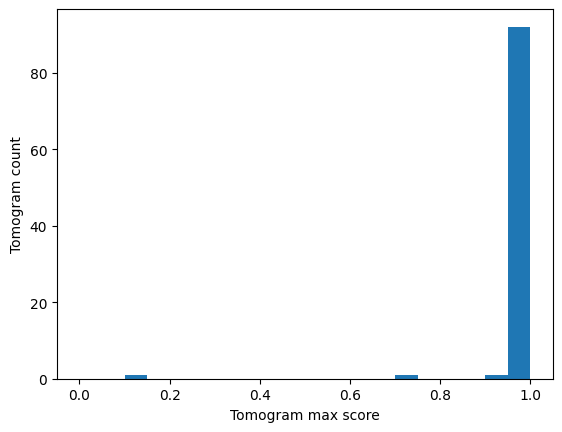

In [19]:
plt.hist(max_scores.max_tomo_score, bins=np.linspace(0,1,21))
plt.xlabel('Tomogram max score')
plt.ylabel('Tomogram count')
plt.show()

In [20]:
neg_val_tomo_scores_df = neg_val_tomo_scores_df.merge(max_scores)

In [21]:
neg_val_max_score_slices = neg_val_tomo_scores_df[neg_val_tomo_scores_df.scores==neg_val_tomo_scores_df.max_tomo_score]

## Perform the same inference over negative training tomograms to select negative training samples by taking the highest-scoring slice from each tomogram.

In [32]:
neg_train_tomo_ids = train_labels_df.tomo_id[(train_labels_df.is_train)&(train_labels_df['Number of motors']==0)]

In [33]:
neg_train_tomo_slice_paths = []
for tomo_id in neg_train_tomo_ids:
    neg_train_tomo_slice_paths += glob.glob(f'byu_dataset/train/{tomo_id}/*.jpg')

In [34]:
neg_train_tomo_slices_dataset = NoLabelDataset(neg_train_tomo_slice_paths, transforms=get_transform(train=False))
neg_train_tomo_slices_dataloader = torch.utils.data.DataLoader(
    neg_train_tomo_slices_dataset,
    batch_size=4,
    shuffle=False
)

In [35]:
model.to(device)
model.eval()
all_preds = []
all_keys = []
i_done = 0
for imgs in tqdm(neg_train_tomo_slices_dataloader):
    imgs = imgs.to(device)
    with torch.no_grad():
        with torch.autocast(device_type="cuda"):
            preds = model(imgs)
        for i in range(len(preds)):
            nms_inds = torchvision.ops.nms(boxes=preds[i]['boxes'],
                                           scores=preds[i]['scores'],
                                           iou_threshold=.5
                                          )
            for field in ['boxes', 'labels', 'scores']:
                preds[i][field] = preds[i][field][nms_inds].cpu().numpy().tolist()
    all_preds += preds
    all_keys += neg_train_tomo_slices_dataloader.dataset.imgs[i_done:i_done+len(preds)]
    eval_preds = dict(zip(all_keys, all_preds))
    with open('byu_dataset/neg_train_best_pos_only_fbeta_preds.json', 'w') as f:
        json.dump(eval_preds, f, indent=1)
    i_done += len(preds)

100%|██████████████████████████████████| 25724/25724 [18:31:09<00:00,  2.59s/it]


In [22]:
with open('byu_dataset/neg_train_best_pos_only_fbeta_preds.json') as f:
    eval_preds = json.load(f)

In [23]:
neg_train_tomo_scores_df = []
for key in eval_preds:
    slice_df = pd.DataFrame.from_dict(eval_preds[key])
    slice_df['slice_path'] = key
    neg_train_tomo_scores_df.append(slice_df)
neg_train_tomo_scores_df = pd.concat(neg_train_tomo_scores_df, ignore_index=True)

In [24]:
neg_train_tomo_scores_df['tomo_id'] = neg_train_tomo_scores_df.slice_path.str.split('/').str.get(2)

In [25]:
neg_train_tomo_scores_df['slice'] = neg_train_tomo_scores_df.slice_path.str.split('/').str.get(-1).str.replace('.jpg','').str.split('_').str.get(1).astype(int)

In [26]:
max_scores = neg_train_tomo_scores_df.groupby(['tomo_id']).agg({'scores':'max'})
max_scores.columns = ['max_tomo_score']
max_scores = max_scores.reset_index()

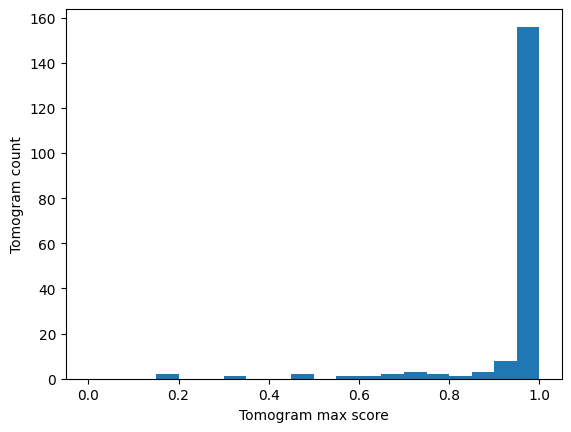

In [27]:
plt.hist(max_scores.max_tomo_score, bins=np.linspace(0,1,21))
plt.xlabel('Tomogram max score')
plt.ylabel('Tomogram count')
plt.show()

In [28]:
neg_train_tomo_scores_df = neg_train_tomo_scores_df.merge(max_scores)

In [29]:
max_score_threshold = .5
box_score_threshold = .1

In [30]:
neg_train_selected = neg_train_tomo_scores_df[
    neg_train_tomo_scores_df.slice_path.isin(neg_train_tomo_scores_df.slice_path[neg_train_tomo_scores_df.scores==neg_train_tomo_scores_df.max_tomo_score])&
    (neg_train_tomo_scores_df.max_tomo_score>=max_score_threshold)&
    (neg_train_tomo_scores_df.scores>=box_score_threshold)
]

In [31]:
len(neg_train_selected.slice_path.unique())

177

## Create dataset class for positive and negative images.

In [32]:
import os
import torch
import pandas as pd

from torchvision.io import read_image, ImageReadMode
from torchvision.ops.boxes import masks_to_boxes
from torchvision import tv_tensors
from torchvision.transforms.v2 import functional as F
from torchvision.transforms import v2 as T

In [33]:
class PosNegDataset(torch.utils.data.Dataset):
    def __init__(self, pos_df, neg_df, tomo_dir, transforms=None, max_allowed_radius=1000, max_length=2000):
        self.transforms = transforms
        self.tomo_dir = tomo_dir
        self.max_allowed_radius = max_allowed_radius
        self.pos_df = pos_df[pos_df['Number of motors']>0]
        self.neg_df = neg_df
        self.pos_frames = list(set(zip(self.pos_df['tomo_id'], self.pos_df['Motor axis 0'])))
        self.neg_frames = list(set(zip(self.neg_df['tomo_id'], self.neg_df['slice'])))
        self.frame_tuples = self.pos_frames + self.neg_frames
        
        self.max_length = max_length

    def __getitem__(self, idx):
        # load images and boxes
        tomo_id, z = self.frame_tuples[idx]
        img_path = os.path.join(self.tomo_dir, tomo_id, f'slice_{int(z):04d}.jpg')
        img = read_image(img_path, mode=ImageReadMode.RGB)
        ch, h, w = img.shape
        img_padded = torch.zeros((ch,max_length,max_length), dtype=img.dtype)
        img_padded[:,:h,:w] = img

        if self.frame_tuples[idx] in self.pos_frames:
            # get bounding box coordinates for each image
            bbs = self.pos_df.loc[(self.pos_df.tomo_id==tomo_id)&(self.pos_df['Motor axis 0']==z), ['Motor axis 2', 'Motor axis 1', 'Voxel spacing']].values
            boxes = torch.tensor([[
                bb[0]-self.max_allowed_radius/bb[2],
                bb[1]-self.max_allowed_radius/bb[2],
                bb[0]+self.max_allowed_radius/bb[2],
                bb[1]+self.max_allowed_radius/bb[2]
            ] for bb in bbs])
            num_objs = len(boxes)
            # there is only one class
            labels = torch.ones((num_objs,), dtype=torch.int64)
        else:
            boxes = torch.tensor(self.neg_df.boxes[(self.neg_df.tomo_id==tomo_id)&(self.neg_df.slice==z)].tolist())
            num_objs = len(boxes)
            labels = torch.zeros((num_objs,), dtype=torch.int64)
        
        # clamp the box coordinates
        box_min = torch.tensor([[0]*4]*num_objs)
        box_max = torch.tensor([[w-1,h-1,w-1,h-1]]*num_objs)
        boxes = torch.clamp(boxes, min=box_min, max=box_max)

        image_id = idx
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        # Wrap sample and targets into torchvision tv_tensors:
        img_padded = tv_tensors.Image(img_padded)

        target = {}
        target["boxes"] = tv_tensors.BoundingBoxes(boxes, format="XYXY", canvas_size=F.get_size(img_padded))
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img_padded, target = self.transforms(img_padded, target)

        return img_padded, target

    def __len__(self):
        return len(self.frame_tuples)

In [34]:
def get_transform(train):
    transforms = []
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
        transforms.append(T.RandomAffine(
            5,
            translate=(0.01,0.01)
        ))
        transforms.append(T.ColorJitter(
            brightness=.05, contrast=.05
        ))
    transforms.append(T.ToDtype(torch.float, scale=True))
    transforms.append(T.ToPureTensor())
    return T.Compose(transforms)

## Create positive-negative training and validation dataloaders.

In [35]:
import utils

In [36]:
train_dataset = PosNegDataset(train_labels_df[train_labels_df.is_train], neg_train_selected, 'byu_dataset/train', transforms=get_transform(train=True))
val_dataset = PosNegDataset(train_labels_df[~train_labels_df.is_train], neg_val_max_score_slices, 'byu_dataset/train', transforms=get_transform(train=False))

In [37]:
train_dataloader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=2,
    shuffle=True,
    collate_fn=utils.collate_fn
)

In [38]:
val_dataloader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=4,
    shuffle=False,
    collate_fn=utils.collate_fn
)

## Set up training for best $F_{\beta}$ score at level of prediction box.

In [39]:
from torchvision.models.detection.transform import GeneralizedRCNNTransform
from engine import train_one_epoch
from tqdm import tqdm
import os

In [40]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# load a model pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")

# replace the classifier with a new one, that has
# num_classes which is user-defined
num_classes = 2  # 1 class (person) + background
# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [41]:
max_length = 2000

In [42]:
model.transform = GeneralizedRCNNTransform(
    min_size=max_length, max_size=max_length, image_mean=[0.485, 0.456, 0.406], image_std=[0.229, 0.224, 0.225]
)

In [43]:
# train on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [44]:
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(
    params,
    lr=0.002,
    momentum=0.9,
    weight_decay=0.0005
)

# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=10,
    gamma=0.2
)

In [45]:
def evaluate_fbeta_pos_neg(model, dataloader, device, max_allowed_radius=1000, beta=2, thres=None):
    model.to(device)
    model.eval()
    all_preds = []
    for imgs, _ in tqdm(dataloader):
        imgs = torch.stack(imgs, dim=0).to(device)
        with torch.no_grad():
            with torch.autocast(device_type="cuda"):
                preds = model(imgs)
            for i in range(len(preds)):
                nms_inds = torchvision.ops.nms(boxes=preds[i]['boxes'],
                                               scores=preds[i]['scores'],
                                               iou_threshold=.5
                                              )
                for field in ['boxes', 'labels', 'scores']:
                    preds[i][field] = preds[i][field][nms_inds].cpu().numpy().tolist()
            all_preds += preds
    eval_preds = dict(zip(dataloader.dataset.frame_tuples, all_preds))
    preds_df = {}
    for tomo_id, z in eval_preds:
        bbs = eval_preds[(tomo_id, z)]['boxes']
        scores = eval_preds[(tomo_id, z)]['scores']
        for i in range(len(bbs)):
            preds_df[len(preds_df)] = {
                'tomo_id': tomo_id,
                'Motor axis 0': z,
                'x_pred': .5*(bbs[i][0]+bbs[i][2]),
                'y_pred': .5*(bbs[i][1]+bbs[i][3]),
                'score': scores[i]
            }
    preds_df = pd.DataFrame.from_dict(preds_df, orient='index')
    if not thres is None:
        preds_df.loc[preds_df.score>=thres, 'score'] = 1.
        preds_df.loc[preds_df.score<thres, 'score'] = 0.
    pos_df = dataloader.dataset.pos_df
    neg_df = dataloader.dataset.neg_df
    score_weighted_fp = preds_df[preds_df.tomo_id.isin(neg_df.tomo_id)].groupby(['tomo_id', 'Motor axis 0', 'x_pred', 'y_pred']).agg({'score': 'max'}).score.sum()
    pos_df = pos_df.merge(preds_df, how='left')
    pos_df['dist'] = ((pos_df['Motor axis 2']-pos_df.x_pred)**2+(pos_df['Motor axis 1']-pos_df.y_pred)**2)**.5*pos_df['Voxel spacing']
    pos_df['hit'] = pos_df.dist<=max_allowed_radius
    pos_df.loc[pos_df.hit==True, 'hit_score'] = pos_df.score[pos_df.hit==True]
    pos_df.loc[pos_df.hit!=True, 'hit_score'] = 0.
    score_weighted_fp += pos_df[pos_df.hit==False].groupby(['tomo_id', 'Motor axis 0', 'x_pred', 'y_pred']).agg({'score': 'max'}).score.sum()
    score_weighted_tp = pos_df.groupby(['tomo_id', 'Motor axis 0', 'Motor axis 1', 'Motor axis 2']).agg({'hit_score':'max'}).hit_score.sum()
    score_weighted_fn = (1 - pos_df.groupby(['tomo_id', 'Motor axis 0', 'Motor axis 1', 'Motor axis 2']).agg({'hit_score':'max'}).hit_score).sum()
    score_weighted_fbeta = (1+beta**2)*score_weighted_tp/((1+beta**2)*score_weighted_tp+beta**2*score_weighted_fn+score_weighted_fp)
    return score_weighted_fbeta, score_weighted_tp, score_weighted_fn, score_weighted_fp

In [52]:
if os.path.isfile('best_fbeta_pos_neg.pth'):
    model.load_state_dict(torch.load('best_fbeta_pos_neg.pth',weights_only=True,map_location=device))
else:
    model.load_state_dict(torch.load('best_fbeta_pos_only.pth',weights_only=True,map_location=device))
best_fbeta, _,_,_ = evaluate_fbeta_pos_neg(model, val_dataloader, device)

100%|███████████████████████████████████████████| 61/61 [01:12<00:00,  1.19s/it]


In [47]:
# let's train it for some epochs
num_epochs = 50

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, train_dataloader, device, epoch, print_freq=120)
    # update the learning rate
#     lr_scheduler.step()
    # evaluate on the test dataset
    fbeta, tp, fn, fp = evaluate_fbeta_pos_neg(model, val_dataloader, device)
    if fbeta > best_fbeta:
        best_fbeta = fbeta
        torch.save(model.state_dict(), 'best_fbeta_pos_neg.pth')
        print(f'Best model at epoch {epoch}: Fbeta={fbeta:.4f}, TPs={tp:.4f}, FNs={fn:.4f}, FPs={fp:.4f}')

Epoch: [0]  [  0/240]  eta: 0:11:02  lr: 0.000010  loss: 0.3455 (0.3455)  loss_classifier: 0.0253 (0.0253)  loss_box_reg: 0.0136 (0.0136)  loss_objectness: 0.2832 (0.2832)  loss_rpn_box_reg: 0.0234 (0.0234)  time: 2.7614  data: 0.4624  max mem: 9097
Epoch: [0]  [120/240]  eta: 0:05:03  lr: 0.001014  loss: 0.0290 (0.0380)  loss_classifier: 0.0120 (0.0156)  loss_box_reg: 0.0098 (0.0146)  loss_objectness: 0.0000 (0.0065)  loss_rpn_box_reg: 0.0004 (0.0013)  time: 2.5198  data: 0.4328  max mem: 9255
Epoch: [0]  [239/240]  eta: 0:00:02  lr: 0.002000  loss: 0.0277 (0.0386)  loss_classifier: 0.0105 (0.0163)  loss_box_reg: 0.0090 (0.0162)  loss_objectness: 0.0038 (0.0047)  loss_rpn_box_reg: 0.0011 (0.0015)  time: 2.5243  data: 0.4373  max mem: 9255
Epoch: [0] Total time: 0:10:07 (2.5305 s / it)


100%|███████████████████████████████████████████| 61/61 [01:16<00:00,  1.25s/it]


Epoch: [1]  [  0/240]  eta: 0:10:20  lr: 0.002000  loss: 0.0256 (0.0256)  loss_classifier: 0.0025 (0.0025)  loss_box_reg: 0.0092 (0.0092)  loss_objectness: 0.0126 (0.0126)  loss_rpn_box_reg: 0.0013 (0.0013)  time: 2.5847  data: 0.4713  max mem: 9255
Epoch: [1]  [120/240]  eta: 0:05:04  lr: 0.002000  loss: 0.0255 (0.0348)  loss_classifier: 0.0104 (0.0155)  loss_box_reg: 0.0138 (0.0158)  loss_objectness: 0.0001 (0.0019)  loss_rpn_box_reg: 0.0003 (0.0016)  time: 2.5431  data: 0.4600  max mem: 9255
Epoch: [1]  [239/240]  eta: 0:00:02  lr: 0.002000  loss: 0.0385 (0.0373)  loss_classifier: 0.0118 (0.0165)  loss_box_reg: 0.0185 (0.0173)  loss_objectness: 0.0002 (0.0021)  loss_rpn_box_reg: 0.0005 (0.0014)  time: 2.5446  data: 0.4595  max mem: 9255
Epoch: [1] Total time: 0:10:09 (2.5405 s / it)


100%|███████████████████████████████████████████| 61/61 [01:15<00:00,  1.24s/it]


Epoch: [2]  [  0/240]  eta: 0:10:09  lr: 0.002000  loss: 0.0694 (0.0694)  loss_classifier: 0.0218 (0.0218)  loss_box_reg: 0.0473 (0.0473)  loss_objectness: 0.0001 (0.0001)  loss_rpn_box_reg: 0.0002 (0.0002)  time: 2.5396  data: 0.4628  max mem: 9255
Epoch: [2]  [120/240]  eta: 0:05:01  lr: 0.002000  loss: 0.0251 (0.0353)  loss_classifier: 0.0110 (0.0140)  loss_box_reg: 0.0071 (0.0160)  loss_objectness: 0.0003 (0.0040)  loss_rpn_box_reg: 0.0005 (0.0013)  time: 2.5056  data: 0.4179  max mem: 9255
Epoch: [2]  [239/240]  eta: 0:00:02  lr: 0.002000  loss: 0.0340 (0.0346)  loss_classifier: 0.0110 (0.0143)  loss_box_reg: 0.0142 (0.0160)  loss_objectness: 0.0006 (0.0027)  loss_rpn_box_reg: 0.0007 (0.0015)  time: 2.5249  data: 0.4379  max mem: 9255
Epoch: [2] Total time: 0:10:03 (2.5163 s / it)


100%|███████████████████████████████████████████| 61/61 [01:15<00:00,  1.24s/it]


Best model at epoch 2: Fbeta=0.8175, TPs=128.4256, FNs=19.5744, FPs=65.0477
Epoch: [3]  [  0/240]  eta: 0:10:09  lr: 0.002000  loss: 0.0074 (0.0074)  loss_classifier: 0.0064 (0.0064)  loss_box_reg: 0.0000 (0.0000)  loss_objectness: 0.0006 (0.0006)  loss_rpn_box_reg: 0.0004 (0.0004)  time: 2.5399  data: 0.4526  max mem: 9255
Epoch: [3]  [120/240]  eta: 0:05:02  lr: 0.002000  loss: 0.0295 (0.0315)  loss_classifier: 0.0099 (0.0129)  loss_box_reg: 0.0109 (0.0153)  loss_objectness: 0.0006 (0.0019)  loss_rpn_box_reg: 0.0003 (0.0013)  time: 2.5219  data: 0.4363  max mem: 9255
Epoch: [3]  [239/240]  eta: 0:00:02  lr: 0.002000  loss: 0.0306 (0.0356)  loss_classifier: 0.0086 (0.0151)  loss_box_reg: 0.0151 (0.0173)  loss_objectness: 0.0003 (0.0018)  loss_rpn_box_reg: 0.0003 (0.0014)  time: 2.4971  data: 0.4104  max mem: 9255
Epoch: [3] Total time: 0:10:04 (2.5201 s / it)


100%|███████████████████████████████████████████| 61/61 [01:15<00:00,  1.23s/it]


Best model at epoch 3: Fbeta=0.8194, TPs=129.0224, FNs=18.9776, FPs=66.2645
Epoch: [4]  [  0/240]  eta: 0:09:51  lr: 0.002000  loss: 0.0157 (0.0157)  loss_classifier: 0.0041 (0.0041)  loss_box_reg: 0.0110 (0.0110)  loss_objectness: 0.0001 (0.0001)  loss_rpn_box_reg: 0.0005 (0.0005)  time: 2.4632  data: 0.3940  max mem: 9255
Epoch: [4]  [120/240]  eta: 0:05:00  lr: 0.002000  loss: 0.0267 (0.0349)  loss_classifier: 0.0105 (0.0151)  loss_box_reg: 0.0101 (0.0167)  loss_objectness: 0.0004 (0.0015)  loss_rpn_box_reg: 0.0005 (0.0017)  time: 2.5202  data: 0.4296  max mem: 9255
Epoch: [4]  [239/240]  eta: 0:00:02  lr: 0.002000  loss: 0.0185 (0.0354)  loss_classifier: 0.0044 (0.0153)  loss_box_reg: 0.0095 (0.0170)  loss_objectness: 0.0005 (0.0017)  loss_rpn_box_reg: 0.0004 (0.0015)  time: 2.4830  data: 0.3995  max mem: 9255
Epoch: [4] Total time: 0:10:00 (2.5039 s / it)


100%|███████████████████████████████████████████| 61/61 [01:15<00:00,  1.23s/it]


Epoch: [5]  [  0/240]  eta: 0:09:58  lr: 0.002000  loss: 0.0319 (0.0319)  loss_classifier: 0.0114 (0.0114)  loss_box_reg: 0.0190 (0.0190)  loss_objectness: 0.0006 (0.0006)  loss_rpn_box_reg: 0.0009 (0.0009)  time: 2.4949  data: 0.4071  max mem: 9255
Epoch: [5]  [120/240]  eta: 0:05:00  lr: 0.002000  loss: 0.0255 (0.0366)  loss_classifier: 0.0108 (0.0157)  loss_box_reg: 0.0131 (0.0175)  loss_objectness: 0.0005 (0.0021)  loss_rpn_box_reg: 0.0007 (0.0014)  time: 2.4943  data: 0.4139  max mem: 9255
Epoch: [5]  [239/240]  eta: 0:00:02  lr: 0.002000  loss: 0.0321 (0.0356)  loss_classifier: 0.0124 (0.0155)  loss_box_reg: 0.0153 (0.0164)  loss_objectness: 0.0004 (0.0023)  loss_rpn_box_reg: 0.0003 (0.0014)  time: 2.4845  data: 0.4049  max mem: 9255
Epoch: [5] Total time: 0:10:00 (2.5001 s / it)


100%|███████████████████████████████████████████| 61/61 [01:15<00:00,  1.23s/it]


Epoch: [6]  [  0/240]  eta: 0:09:51  lr: 0.002000  loss: 0.0218 (0.0218)  loss_classifier: 0.0048 (0.0048)  loss_box_reg: 0.0169 (0.0169)  loss_objectness: 0.0000 (0.0000)  loss_rpn_box_reg: 0.0001 (0.0001)  time: 2.4664  data: 0.3889  max mem: 9255
Epoch: [6]  [120/240]  eta: 0:05:00  lr: 0.002000  loss: 0.0193 (0.0304)  loss_classifier: 0.0070 (0.0130)  loss_box_reg: 0.0094 (0.0152)  loss_objectness: 0.0001 (0.0012)  loss_rpn_box_reg: 0.0004 (0.0010)  time: 2.5106  data: 0.4171  max mem: 9255
Epoch: [6]  [239/240]  eta: 0:00:02  lr: 0.002000  loss: 0.0303 (0.0332)  loss_classifier: 0.0114 (0.0139)  loss_box_reg: 0.0173 (0.0164)  loss_objectness: 0.0003 (0.0016)  loss_rpn_box_reg: 0.0006 (0.0013)  time: 2.4984  data: 0.4141  max mem: 9255
Epoch: [6] Total time: 0:10:00 (2.5028 s / it)


100%|███████████████████████████████████████████| 61/61 [01:15<00:00,  1.23s/it]


Epoch: [7]  [  0/240]  eta: 0:09:46  lr: 0.002000  loss: 0.0359 (0.0359)  loss_classifier: 0.0121 (0.0121)  loss_box_reg: 0.0232 (0.0232)  loss_objectness: 0.0003 (0.0003)  loss_rpn_box_reg: 0.0004 (0.0004)  time: 2.4424  data: 0.3734  max mem: 9255
Epoch: [7]  [120/240]  eta: 0:04:59  lr: 0.002000  loss: 0.0315 (0.0387)  loss_classifier: 0.0084 (0.0169)  loss_box_reg: 0.0159 (0.0187)  loss_objectness: 0.0005 (0.0016)  loss_rpn_box_reg: 0.0004 (0.0015)  time: 2.4751  data: 0.3933  max mem: 9255
Epoch: [7]  [239/240]  eta: 0:00:02  lr: 0.002000  loss: 0.0233 (0.0350)  loss_classifier: 0.0083 (0.0147)  loss_box_reg: 0.0125 (0.0169)  loss_objectness: 0.0006 (0.0020)  loss_rpn_box_reg: 0.0007 (0.0014)  time: 2.4606  data: 0.3797  max mem: 9255
Epoch: [7] Total time: 0:09:57 (2.4901 s / it)


100%|███████████████████████████████████████████| 61/61 [01:14<00:00,  1.23s/it]


Best model at epoch 7: Fbeta=0.8256, TPs=126.1756, FNs=21.8244, FPs=45.9261
Epoch: [8]  [  0/240]  eta: 0:10:24  lr: 0.002000  loss: 0.0127 (0.0127)  loss_classifier: 0.0038 (0.0038)  loss_box_reg: 0.0078 (0.0078)  loss_objectness: 0.0006 (0.0006)  loss_rpn_box_reg: 0.0005 (0.0005)  time: 2.6037  data: 0.5322  max mem: 9255
Epoch: [8]  [120/240]  eta: 0:04:59  lr: 0.002000  loss: 0.0250 (0.0326)  loss_classifier: 0.0064 (0.0132)  loss_box_reg: 0.0123 (0.0162)  loss_objectness: 0.0011 (0.0018)  loss_rpn_box_reg: 0.0011 (0.0014)  time: 2.4898  data: 0.4037  max mem: 9255
Epoch: [8]  [239/240]  eta: 0:00:02  lr: 0.002000  loss: 0.0262 (0.0319)  loss_classifier: 0.0062 (0.0124)  loss_box_reg: 0.0164 (0.0161)  loss_objectness: 0.0007 (0.0020)  loss_rpn_box_reg: 0.0003 (0.0014)  time: 2.4876  data: 0.4050  max mem: 9255
Epoch: [8] Total time: 0:09:57 (2.4900 s / it)


100%|███████████████████████████████████████████| 61/61 [01:15<00:00,  1.23s/it]


Epoch: [9]  [  0/240]  eta: 0:09:46  lr: 0.002000  loss: 0.0082 (0.0082)  loss_classifier: 0.0021 (0.0021)  loss_box_reg: 0.0040 (0.0040)  loss_objectness: 0.0018 (0.0018)  loss_rpn_box_reg: 0.0004 (0.0004)  time: 2.4425  data: 0.3660  max mem: 9255
Epoch: [9]  [120/240]  eta: 0:04:59  lr: 0.002000  loss: 0.0215 (0.0323)  loss_classifier: 0.0088 (0.0128)  loss_box_reg: 0.0121 (0.0165)  loss_objectness: 0.0003 (0.0017)  loss_rpn_box_reg: 0.0005 (0.0013)  time: 2.4869  data: 0.4124  max mem: 9255
Epoch: [9]  [239/240]  eta: 0:00:02  lr: 0.002000  loss: 0.0260 (0.0320)  loss_classifier: 0.0087 (0.0130)  loss_box_reg: 0.0142 (0.0161)  loss_objectness: 0.0003 (0.0016)  loss_rpn_box_reg: 0.0003 (0.0014)  time: 2.5014  data: 0.4080  max mem: 9255
Epoch: [9] Total time: 0:10:00 (2.5019 s / it)


100%|███████████████████████████████████████████| 61/61 [01:15<00:00,  1.23s/it]


Epoch: [10]  [  0/240]  eta: 0:09:55  lr: 0.002000  loss: 0.0144 (0.0144)  loss_classifier: 0.0006 (0.0006)  loss_box_reg: 0.0000 (0.0000)  loss_objectness: 0.0052 (0.0052)  loss_rpn_box_reg: 0.0085 (0.0085)  time: 2.4826  data: 0.3935  max mem: 9255
Epoch: [10]  [120/240]  eta: 0:04:59  lr: 0.002000  loss: 0.0285 (0.0350)  loss_classifier: 0.0082 (0.0150)  loss_box_reg: 0.0168 (0.0176)  loss_objectness: 0.0001 (0.0012)  loss_rpn_box_reg: 0.0005 (0.0012)  time: 2.5012  data: 0.4126  max mem: 9255
Epoch: [10]  [239/240]  eta: 0:00:02  lr: 0.002000  loss: 0.0226 (0.0335)  loss_classifier: 0.0055 (0.0143)  loss_box_reg: 0.0137 (0.0167)  loss_objectness: 0.0002 (0.0012)  loss_rpn_box_reg: 0.0004 (0.0013)  time: 2.5028  data: 0.4160  max mem: 9255
Epoch: [10] Total time: 0:10:00 (2.5015 s / it)


100%|███████████████████████████████████████████| 61/61 [01:15<00:00,  1.23s/it]


Best model at epoch 10: Fbeta=0.8305, TPs=136.0207, FNs=11.9793, FPs=90.9242
Epoch: [11]  [  0/240]  eta: 0:09:50  lr: 0.002000  loss: 0.0712 (0.0712)  loss_classifier: 0.0446 (0.0446)  loss_box_reg: 0.0250 (0.0250)  loss_objectness: 0.0015 (0.0015)  loss_rpn_box_reg: 0.0001 (0.0001)  time: 2.4586  data: 0.3804  max mem: 9255
Epoch: [11]  [120/240]  eta: 0:04:59  lr: 0.002000  loss: 0.0257 (0.0316)  loss_classifier: 0.0102 (0.0135)  loss_box_reg: 0.0088 (0.0151)  loss_objectness: 0.0004 (0.0018)  loss_rpn_box_reg: 0.0007 (0.0013)  time: 2.5008  data: 0.4089  max mem: 9255
Epoch: [11]  [239/240]  eta: 0:00:02  lr: 0.002000  loss: 0.0326 (0.0323)  loss_classifier: 0.0110 (0.0138)  loss_box_reg: 0.0177 (0.0156)  loss_objectness: 0.0003 (0.0015)  loss_rpn_box_reg: 0.0004 (0.0013)  time: 2.4784  data: 0.3875  max mem: 9255
Epoch: [11] Total time: 0:09:59 (2.4960 s / it)


100%|███████████████████████████████████████████| 61/61 [01:15<00:00,  1.23s/it]


Epoch: [12]  [  0/240]  eta: 0:09:52  lr: 0.002000  loss: 0.0100 (0.0100)  loss_classifier: 0.0043 (0.0043)  loss_box_reg: 0.0000 (0.0000)  loss_objectness: 0.0018 (0.0018)  loss_rpn_box_reg: 0.0040 (0.0040)  time: 2.4704  data: 0.3811  max mem: 9255
Epoch: [12]  [120/240]  eta: 0:04:59  lr: 0.002000  loss: 0.0198 (0.0263)  loss_classifier: 0.0075 (0.0111)  loss_box_reg: 0.0094 (0.0128)  loss_objectness: 0.0004 (0.0011)  loss_rpn_box_reg: 0.0004 (0.0013)  time: 2.4989  data: 0.4101  max mem: 9255
Epoch: [12]  [239/240]  eta: 0:00:02  lr: 0.002000  loss: 0.0320 (0.0291)  loss_classifier: 0.0078 (0.0118)  loss_box_reg: 0.0160 (0.0144)  loss_objectness: 0.0002 (0.0014)  loss_rpn_box_reg: 0.0007 (0.0014)  time: 2.4692  data: 0.3888  max mem: 9255
Epoch: [12] Total time: 0:09:57 (2.4882 s / it)


100%|███████████████████████████████████████████| 61/61 [01:14<00:00,  1.23s/it]


Epoch: [13]  [  0/240]  eta: 0:09:47  lr: 0.002000  loss: 0.0432 (0.0432)  loss_classifier: 0.0142 (0.0142)  loss_box_reg: 0.0285 (0.0285)  loss_objectness: 0.0000 (0.0000)  loss_rpn_box_reg: 0.0004 (0.0004)  time: 2.4462  data: 0.3672  max mem: 9255
Epoch: [13]  [120/240]  eta: 0:04:58  lr: 0.002000  loss: 0.0167 (0.0346)  loss_classifier: 0.0053 (0.0142)  loss_box_reg: 0.0109 (0.0178)  loss_objectness: 0.0001 (0.0014)  loss_rpn_box_reg: 0.0006 (0.0012)  time: 2.4812  data: 0.3932  max mem: 9255
Epoch: [13]  [239/240]  eta: 0:00:02  lr: 0.002000  loss: 0.0278 (0.0324)  loss_classifier: 0.0112 (0.0129)  loss_box_reg: 0.0147 (0.0168)  loss_objectness: 0.0000 (0.0013)  loss_rpn_box_reg: 0.0002 (0.0013)  time: 2.4923  data: 0.3991  max mem: 9255
Epoch: [13] Total time: 0:09:56 (2.4841 s / it)


100%|███████████████████████████████████████████| 61/61 [01:14<00:00,  1.23s/it]


Epoch: [14]  [  0/240]  eta: 0:09:49  lr: 0.002000  loss: 0.0324 (0.0324)  loss_classifier: 0.0178 (0.0178)  loss_box_reg: 0.0144 (0.0144)  loss_objectness: 0.0000 (0.0000)  loss_rpn_box_reg: 0.0003 (0.0003)  time: 2.4548  data: 0.3606  max mem: 9255
Epoch: [14]  [120/240]  eta: 0:04:59  lr: 0.002000  loss: 0.0234 (0.0267)  loss_classifier: 0.0090 (0.0103)  loss_box_reg: 0.0142 (0.0138)  loss_objectness: 0.0001 (0.0015)  loss_rpn_box_reg: 0.0003 (0.0012)  time: 2.4959  data: 0.4074  max mem: 9255
Epoch: [14]  [239/240]  eta: 0:00:02  lr: 0.002000  loss: 0.0191 (0.0278)  loss_classifier: 0.0044 (0.0108)  loss_box_reg: 0.0108 (0.0142)  loss_objectness: 0.0002 (0.0016)  loss_rpn_box_reg: 0.0010 (0.0013)  time: 2.4784  data: 0.3949  max mem: 9255
Epoch: [14] Total time: 0:09:59 (2.4988 s / it)


100%|███████████████████████████████████████████| 61/61 [01:15<00:00,  1.23s/it]


Best model at epoch 14: Fbeta=0.8314, TPs=126.5683, FNs=21.4317, FPs=42.5780
Epoch: [15]  [  0/240]  eta: 0:10:02  lr: 0.002000  loss: 0.0280 (0.0280)  loss_classifier: 0.0130 (0.0130)  loss_box_reg: 0.0144 (0.0144)  loss_objectness: 0.0005 (0.0005)  loss_rpn_box_reg: 0.0002 (0.0002)  time: 2.5115  data: 0.4330  max mem: 9255
Epoch: [15]  [120/240]  eta: 0:05:02  lr: 0.002000  loss: 0.0214 (0.0265)  loss_classifier: 0.0070 (0.0102)  loss_box_reg: 0.0089 (0.0131)  loss_objectness: 0.0002 (0.0016)  loss_rpn_box_reg: 0.0004 (0.0015)  time: 2.5103  data: 0.4200  max mem: 9255
Epoch: [15]  [239/240]  eta: 0:00:02  lr: 0.002000  loss: 0.0200 (0.0281)  loss_classifier: 0.0086 (0.0113)  loss_box_reg: 0.0094 (0.0143)  loss_objectness: 0.0001 (0.0014)  loss_rpn_box_reg: 0.0005 (0.0012)  time: 2.4784  data: 0.3970  max mem: 9255
Epoch: [15] Total time: 0:10:02 (2.5095 s / it)


100%|███████████████████████████████████████████| 61/61 [01:14<00:00,  1.23s/it]


Epoch: [16]  [  0/240]  eta: 0:09:41  lr: 0.002000  loss: 0.0499 (0.0499)  loss_classifier: 0.0167 (0.0167)  loss_box_reg: 0.0264 (0.0264)  loss_objectness: 0.0007 (0.0007)  loss_rpn_box_reg: 0.0061 (0.0061)  time: 2.4245  data: 0.3459  max mem: 9255
Epoch: [16]  [120/240]  eta: 0:04:59  lr: 0.002000  loss: 0.0218 (0.0278)  loss_classifier: 0.0049 (0.0092)  loss_box_reg: 0.0074 (0.0150)  loss_objectness: 0.0006 (0.0022)  loss_rpn_box_reg: 0.0013 (0.0014)  time: 2.4775  data: 0.3988  max mem: 9255
Epoch: [16]  [239/240]  eta: 0:00:02  lr: 0.002000  loss: 0.0181 (0.0269)  loss_classifier: 0.0055 (0.0098)  loss_box_reg: 0.0117 (0.0141)  loss_objectness: 0.0002 (0.0018)  loss_rpn_box_reg: 0.0003 (0.0012)  time: 2.4942  data: 0.4070  max mem: 9255
Epoch: [16] Total time: 0:09:59 (2.4967 s / it)


100%|███████████████████████████████████████████| 61/61 [01:15<00:00,  1.24s/it]


Epoch: [17]  [  0/240]  eta: 0:09:51  lr: 0.002000  loss: 0.0050 (0.0050)  loss_classifier: 0.0006 (0.0006)  loss_box_reg: 0.0000 (0.0000)  loss_objectness: 0.0013 (0.0013)  loss_rpn_box_reg: 0.0031 (0.0031)  time: 2.4662  data: 0.3956  max mem: 9255
Epoch: [17]  [120/240]  eta: 0:04:57  lr: 0.002000  loss: 0.0187 (0.0255)  loss_classifier: 0.0060 (0.0101)  loss_box_reg: 0.0088 (0.0128)  loss_objectness: 0.0003 (0.0013)  loss_rpn_box_reg: 0.0004 (0.0012)  time: 2.4789  data: 0.3943  max mem: 9255
Epoch: [17]  [239/240]  eta: 0:00:02  lr: 0.002000  loss: 0.0280 (0.0263)  loss_classifier: 0.0106 (0.0099)  loss_box_reg: 0.0167 (0.0138)  loss_objectness: 0.0002 (0.0014)  loss_rpn_box_reg: 0.0003 (0.0012)  time: 2.5022  data: 0.4167  max mem: 9255
Epoch: [17] Total time: 0:09:56 (2.4866 s / it)


100%|███████████████████████████████████████████| 61/61 [01:15<00:00,  1.23s/it]


Best model at epoch 17: Fbeta=0.8455, TPs=131.5619, FNs=16.4381, FPs=54.4681
Epoch: [18]  [  0/240]  eta: 0:10:07  lr: 0.002000  loss: 0.0366 (0.0366)  loss_classifier: 0.0154 (0.0154)  loss_box_reg: 0.0207 (0.0207)  loss_objectness: 0.0002 (0.0002)  loss_rpn_box_reg: 0.0002 (0.0002)  time: 2.5319  data: 0.4561  max mem: 9255
Epoch: [18]  [120/240]  eta: 0:05:01  lr: 0.002000  loss: 0.0186 (0.0273)  loss_classifier: 0.0072 (0.0108)  loss_box_reg: 0.0089 (0.0142)  loss_objectness: 0.0002 (0.0010)  loss_rpn_box_reg: 0.0003 (0.0013)  time: 2.5119  data: 0.4260  max mem: 9255
Epoch: [18]  [239/240]  eta: 0:00:02  lr: 0.002000  loss: 0.0172 (0.0259)  loss_classifier: 0.0051 (0.0099)  loss_box_reg: 0.0072 (0.0134)  loss_objectness: 0.0007 (0.0013)  loss_rpn_box_reg: 0.0011 (0.0012)  time: 2.5130  data: 0.4265  max mem: 9255
Epoch: [18] Total time: 0:10:04 (2.5204 s / it)


100%|███████████████████████████████████████████| 61/61 [01:15<00:00,  1.24s/it]


Epoch: [19]  [  0/240]  eta: 0:10:10  lr: 0.002000  loss: 0.0436 (0.0436)  loss_classifier: 0.0187 (0.0187)  loss_box_reg: 0.0176 (0.0176)  loss_objectness: 0.0069 (0.0069)  loss_rpn_box_reg: 0.0003 (0.0003)  time: 2.5424  data: 0.4617  max mem: 9255
Epoch: [19]  [120/240]  eta: 0:05:01  lr: 0.002000  loss: 0.0257 (0.0272)  loss_classifier: 0.0077 (0.0095)  loss_box_reg: 0.0122 (0.0149)  loss_objectness: 0.0001 (0.0016)  loss_rpn_box_reg: 0.0003 (0.0012)  time: 2.5130  data: 0.4303  max mem: 9255
Epoch: [19]  [239/240]  eta: 0:00:02  lr: 0.002000  loss: 0.0193 (0.0270)  loss_classifier: 0.0059 (0.0097)  loss_box_reg: 0.0133 (0.0149)  loss_objectness: 0.0000 (0.0013)  loss_rpn_box_reg: 0.0002 (0.0012)  time: 2.5340  data: 0.4466  max mem: 9255
Epoch: [19] Total time: 0:10:05 (2.5209 s / it)


100%|███████████████████████████████████████████| 61/61 [01:15<00:00,  1.24s/it]


Epoch: [20]  [  0/240]  eta: 0:10:04  lr: 0.002000  loss: 0.0337 (0.0337)  loss_classifier: 0.0177 (0.0177)  loss_box_reg: 0.0157 (0.0157)  loss_objectness: 0.0000 (0.0000)  loss_rpn_box_reg: 0.0003 (0.0003)  time: 2.5197  data: 0.4488  max mem: 9255
Epoch: [20]  [120/240]  eta: 0:05:02  lr: 0.002000  loss: 0.0236 (0.0245)  loss_classifier: 0.0085 (0.0093)  loss_box_reg: 0.0144 (0.0132)  loss_objectness: 0.0001 (0.0009)  loss_rpn_box_reg: 0.0002 (0.0011)  time: 2.5431  data: 0.4596  max mem: 9255
Epoch: [20]  [239/240]  eta: 0:00:02  lr: 0.002000  loss: 0.0243 (0.0258)  loss_classifier: 0.0088 (0.0102)  loss_box_reg: 0.0145 (0.0132)  loss_objectness: 0.0002 (0.0012)  loss_rpn_box_reg: 0.0003 (0.0012)  time: 2.4915  data: 0.4084  max mem: 9255
Epoch: [20] Total time: 0:10:04 (2.5176 s / it)


100%|███████████████████████████████████████████| 61/61 [01:15<00:00,  1.23s/it]


Epoch: [21]  [  0/240]  eta: 0:10:07  lr: 0.002000  loss: 0.0193 (0.0193)  loss_classifier: 0.0059 (0.0059)  loss_box_reg: 0.0081 (0.0081)  loss_objectness: 0.0049 (0.0049)  loss_rpn_box_reg: 0.0003 (0.0003)  time: 2.5317  data: 0.4615  max mem: 9255
Epoch: [21]  [120/240]  eta: 0:05:02  lr: 0.002000  loss: 0.0207 (0.0271)  loss_classifier: 0.0086 (0.0101)  loss_box_reg: 0.0101 (0.0140)  loss_objectness: 0.0002 (0.0015)  loss_rpn_box_reg: 0.0006 (0.0015)  time: 2.5125  data: 0.4283  max mem: 9255
Epoch: [21]  [239/240]  eta: 0:00:02  lr: 0.002000  loss: 0.0280 (0.0268)  loss_classifier: 0.0098 (0.0104)  loss_box_reg: 0.0143 (0.0137)  loss_objectness: 0.0002 (0.0015)  loss_rpn_box_reg: 0.0005 (0.0012)  time: 2.4867  data: 0.3984  max mem: 9255
Epoch: [21] Total time: 0:10:03 (2.5144 s / it)


100%|███████████████████████████████████████████| 61/61 [01:15<00:00,  1.23s/it]


Epoch: [22]  [  0/240]  eta: 0:10:09  lr: 0.002000  loss: 0.0187 (0.0187)  loss_classifier: 0.0057 (0.0057)  loss_box_reg: 0.0129 (0.0129)  loss_objectness: 0.0000 (0.0000)  loss_rpn_box_reg: 0.0001 (0.0001)  time: 2.5381  data: 0.4293  max mem: 9255
Epoch: [22]  [120/240]  eta: 0:05:01  lr: 0.002000  loss: 0.0168 (0.0222)  loss_classifier: 0.0044 (0.0072)  loss_box_reg: 0.0087 (0.0123)  loss_objectness: 0.0001 (0.0013)  loss_rpn_box_reg: 0.0005 (0.0015)  time: 2.5284  data: 0.4324  max mem: 9255
Epoch: [22]  [239/240]  eta: 0:00:02  lr: 0.002000  loss: 0.0278 (0.0243)  loss_classifier: 0.0090 (0.0084)  loss_box_reg: 0.0179 (0.0136)  loss_objectness: 0.0002 (0.0011)  loss_rpn_box_reg: 0.0003 (0.0012)  time: 2.4902  data: 0.4014  max mem: 9255
Epoch: [22] Total time: 0:10:01 (2.5071 s / it)


100%|███████████████████████████████████████████| 61/61 [01:15<00:00,  1.23s/it]


Epoch: [23]  [  0/240]  eta: 0:10:05  lr: 0.002000  loss: 0.0160 (0.0160)  loss_classifier: 0.0048 (0.0048)  loss_box_reg: 0.0061 (0.0061)  loss_objectness: 0.0046 (0.0046)  loss_rpn_box_reg: 0.0006 (0.0006)  time: 2.5236  data: 0.4295  max mem: 9255
Epoch: [23]  [120/240]  eta: 0:04:58  lr: 0.002000  loss: 0.0216 (0.0245)  loss_classifier: 0.0086 (0.0086)  loss_box_reg: 0.0128 (0.0136)  loss_objectness: 0.0001 (0.0012)  loss_rpn_box_reg: 0.0005 (0.0011)  time: 2.5042  data: 0.4155  max mem: 9255
Epoch: [23]  [239/240]  eta: 0:00:02  lr: 0.002000  loss: 0.0278 (0.0257)  loss_classifier: 0.0084 (0.0095)  loss_box_reg: 0.0151 (0.0138)  loss_objectness: 0.0003 (0.0012)  loss_rpn_box_reg: 0.0002 (0.0011)  time: 2.4942  data: 0.4027  max mem: 9255
Epoch: [23] Total time: 0:09:58 (2.4926 s / it)


100%|███████████████████████████████████████████| 61/61 [01:15<00:00,  1.24s/it]


Epoch: [24]  [  0/240]  eta: 0:10:28  lr: 0.002000  loss: 0.0188 (0.0188)  loss_classifier: 0.0056 (0.0056)  loss_box_reg: 0.0131 (0.0131)  loss_objectness: 0.0001 (0.0001)  loss_rpn_box_reg: 0.0001 (0.0001)  time: 2.6185  data: 0.5307  max mem: 9255
Epoch: [24]  [120/240]  eta: 0:05:01  lr: 0.002000  loss: 0.0338 (0.0293)  loss_classifier: 0.0073 (0.0119)  loss_box_reg: 0.0117 (0.0145)  loss_objectness: 0.0000 (0.0013)  loss_rpn_box_reg: 0.0002 (0.0016)  time: 2.5291  data: 0.4418  max mem: 9255
Epoch: [24]  [239/240]  eta: 0:00:02  lr: 0.002000  loss: 0.0170 (0.0261)  loss_classifier: 0.0060 (0.0102)  loss_box_reg: 0.0069 (0.0134)  loss_objectness: 0.0001 (0.0012)  loss_rpn_box_reg: 0.0003 (0.0013)  time: 2.5779  data: 0.4925  max mem: 9255
Epoch: [24] Total time: 0:10:05 (2.5234 s / it)


100%|███████████████████████████████████████████| 61/61 [01:15<00:00,  1.24s/it]


Epoch: [25]  [  0/240]  eta: 0:10:10  lr: 0.002000  loss: 0.0136 (0.0136)  loss_classifier: 0.0029 (0.0029)  loss_box_reg: 0.0080 (0.0080)  loss_objectness: 0.0001 (0.0001)  loss_rpn_box_reg: 0.0027 (0.0027)  time: 2.5447  data: 0.4628  max mem: 9255
Epoch: [25]  [120/240]  eta: 0:05:01  lr: 0.002000  loss: 0.0178 (0.0245)  loss_classifier: 0.0044 (0.0089)  loss_box_reg: 0.0094 (0.0129)  loss_objectness: 0.0002 (0.0013)  loss_rpn_box_reg: 0.0006 (0.0014)  time: 2.5018  data: 0.4131  max mem: 9255
Epoch: [25]  [239/240]  eta: 0:00:02  lr: 0.002000  loss: 0.0211 (0.0244)  loss_classifier: 0.0060 (0.0090)  loss_box_reg: 0.0110 (0.0128)  loss_objectness: 0.0001 (0.0014)  loss_rpn_box_reg: 0.0004 (0.0012)  time: 2.5458  data: 0.4562  max mem: 9255
Epoch: [25] Total time: 0:10:04 (2.5185 s / it)


100%|███████████████████████████████████████████| 61/61 [01:16<00:00,  1.25s/it]


Epoch: [26]  [  0/240]  eta: 0:10:13  lr: 0.002000  loss: 0.0212 (0.0212)  loss_classifier: 0.0068 (0.0068)  loss_box_reg: 0.0000 (0.0000)  loss_objectness: 0.0101 (0.0101)  loss_rpn_box_reg: 0.0043 (0.0043)  time: 2.5582  data: 0.4865  max mem: 9255
Epoch: [26]  [120/240]  eta: 0:05:04  lr: 0.002000  loss: 0.0339 (0.0295)  loss_classifier: 0.0115 (0.0129)  loss_box_reg: 0.0143 (0.0133)  loss_objectness: 0.0012 (0.0017)  loss_rpn_box_reg: 0.0009 (0.0015)  time: 2.5454  data: 0.4587  max mem: 9255
Epoch: [26]  [239/240]  eta: 0:00:02  lr: 0.002000  loss: 0.0175 (0.0319)  loss_classifier: 0.0059 (0.0135)  loss_box_reg: 0.0081 (0.0149)  loss_objectness: 0.0003 (0.0020)  loss_rpn_box_reg: 0.0005 (0.0015)  time: 2.5720  data: 0.4862  max mem: 9255
Epoch: [26] Total time: 0:10:12 (2.5501 s / it)


100%|███████████████████████████████████████████| 61/61 [01:16<00:00,  1.25s/it]


Epoch: [27]  [  0/240]  eta: 0:10:21  lr: 0.002000  loss: 0.1267 (0.1267)  loss_classifier: 0.0550 (0.0550)  loss_box_reg: 0.0709 (0.0709)  loss_objectness: 0.0000 (0.0000)  loss_rpn_box_reg: 0.0008 (0.0008)  time: 2.5895  data: 0.4908  max mem: 9255
Epoch: [27]  [120/240]  eta: 0:05:07  lr: 0.002000  loss: 0.0225 (0.0257)  loss_classifier: 0.0080 (0.0097)  loss_box_reg: 0.0097 (0.0137)  loss_objectness: 0.0003 (0.0010)  loss_rpn_box_reg: 0.0003 (0.0013)  time: 2.5624  data: 0.4797  max mem: 9255
Epoch: [27]  [239/240]  eta: 0:00:02  lr: 0.002000  loss: 0.0216 (0.0256)  loss_classifier: 0.0049 (0.0090)  loss_box_reg: 0.0129 (0.0139)  loss_objectness: 0.0002 (0.0014)  loss_rpn_box_reg: 0.0005 (0.0013)  time: 2.5552  data: 0.4647  max mem: 9255
Epoch: [27] Total time: 0:10:15 (2.5639 s / it)


100%|███████████████████████████████████████████| 61/61 [01:16<00:00,  1.25s/it]


Epoch: [28]  [  0/240]  eta: 0:10:16  lr: 0.002000  loss: 0.0203 (0.0203)  loss_classifier: 0.0032 (0.0032)  loss_box_reg: 0.0157 (0.0157)  loss_objectness: 0.0005 (0.0005)  loss_rpn_box_reg: 0.0009 (0.0009)  time: 2.5669  data: 0.4866  max mem: 9255
Epoch: [28]  [120/240]  eta: 0:05:06  lr: 0.002000  loss: 0.0162 (0.0248)  loss_classifier: 0.0055 (0.0091)  loss_box_reg: 0.0079 (0.0132)  loss_objectness: 0.0002 (0.0013)  loss_rpn_box_reg: 0.0008 (0.0012)  time: 2.5763  data: 0.4826  max mem: 9255
Epoch: [28]  [239/240]  eta: 0:00:02  lr: 0.002000  loss: 0.0292 (0.0236)  loss_classifier: 0.0072 (0.0087)  loss_box_reg: 0.0172 (0.0128)  loss_objectness: 0.0000 (0.0011)  loss_rpn_box_reg: 0.0002 (0.0011)  time: 2.5613  data: 0.4750  max mem: 9255
Epoch: [28] Total time: 0:10:13 (2.5544 s / it)


100%|███████████████████████████████████████████| 61/61 [01:15<00:00,  1.25s/it]


Epoch: [29]  [  0/240]  eta: 0:10:12  lr: 0.002000  loss: 0.0120 (0.0120)  loss_classifier: 0.0030 (0.0030)  loss_box_reg: 0.0063 (0.0063)  loss_objectness: 0.0015 (0.0015)  loss_rpn_box_reg: 0.0012 (0.0012)  time: 2.5509  data: 0.4696  max mem: 9255
Epoch: [29]  [120/240]  eta: 0:05:06  lr: 0.002000  loss: 0.0131 (0.0206)  loss_classifier: 0.0039 (0.0072)  loss_box_reg: 0.0093 (0.0113)  loss_objectness: 0.0002 (0.0011)  loss_rpn_box_reg: 0.0004 (0.0010)  time: 2.5582  data: 0.4691  max mem: 9255
Epoch: [29]  [239/240]  eta: 0:00:02  lr: 0.002000  loss: 0.0189 (0.0227)  loss_classifier: 0.0064 (0.0082)  loss_box_reg: 0.0098 (0.0121)  loss_objectness: 0.0003 (0.0013)  loss_rpn_box_reg: 0.0003 (0.0012)  time: 2.5462  data: 0.4583  max mem: 9255
Epoch: [29] Total time: 0:10:13 (2.5544 s / it)


100%|███████████████████████████████████████████| 61/61 [01:16<00:00,  1.25s/it]


Epoch: [30]  [  0/240]  eta: 0:10:16  lr: 0.002000  loss: 0.0644 (0.0644)  loss_classifier: 0.0179 (0.0179)  loss_box_reg: 0.0202 (0.0202)  loss_objectness: 0.0228 (0.0228)  loss_rpn_box_reg: 0.0034 (0.0034)  time: 2.5706  data: 0.4872  max mem: 9255
Epoch: [30]  [120/240]  eta: 0:05:08  lr: 0.002000  loss: 0.0165 (0.0258)  loss_classifier: 0.0056 (0.0093)  loss_box_reg: 0.0103 (0.0138)  loss_objectness: 0.0004 (0.0015)  loss_rpn_box_reg: 0.0004 (0.0013)  time: 2.5591  data: 0.4699  max mem: 9255
Epoch: [30]  [239/240]  eta: 0:00:02  lr: 0.002000  loss: 0.0164 (0.0250)  loss_classifier: 0.0048 (0.0094)  loss_box_reg: 0.0103 (0.0132)  loss_objectness: 0.0001 (0.0013)  loss_rpn_box_reg: 0.0005 (0.0011)  time: 2.5687  data: 0.4830  max mem: 9255
Epoch: [30] Total time: 0:10:15 (2.5631 s / it)


100%|███████████████████████████████████████████| 61/61 [01:16<00:00,  1.26s/it]


Epoch: [31]  [  0/240]  eta: 0:10:14  lr: 0.002000  loss: 0.0198 (0.0198)  loss_classifier: 0.0057 (0.0057)  loss_box_reg: 0.0140 (0.0140)  loss_objectness: 0.0000 (0.0000)  loss_rpn_box_reg: 0.0001 (0.0001)  time: 2.5584  data: 0.4760  max mem: 9255
Epoch: [31]  [120/240]  eta: 0:05:06  lr: 0.002000  loss: 0.0134 (0.0267)  loss_classifier: 0.0042 (0.0111)  loss_box_reg: 0.0063 (0.0131)  loss_objectness: 0.0004 (0.0012)  loss_rpn_box_reg: 0.0005 (0.0013)  time: 2.5635  data: 0.4731  max mem: 9255
Epoch: [31]  [239/240]  eta: 0:00:02  lr: 0.002000  loss: 0.0226 (0.0268)  loss_classifier: 0.0085 (0.0110)  loss_box_reg: 0.0112 (0.0135)  loss_objectness: 0.0001 (0.0012)  loss_rpn_box_reg: 0.0003 (0.0012)  time: 2.5166  data: 0.4298  max mem: 9255
Epoch: [31] Total time: 0:10:09 (2.5385 s / it)


100%|███████████████████████████████████████████| 61/61 [01:15<00:00,  1.24s/it]


Epoch: [32]  [  0/240]  eta: 0:10:19  lr: 0.002000  loss: 0.0223 (0.0223)  loss_classifier: 0.0016 (0.0016)  loss_box_reg: 0.0168 (0.0168)  loss_objectness: 0.0003 (0.0003)  loss_rpn_box_reg: 0.0035 (0.0035)  time: 2.5826  data: 0.4846  max mem: 9255
Epoch: [32]  [120/240]  eta: 0:05:01  lr: 0.002000  loss: 0.0243 (0.0245)  loss_classifier: 0.0066 (0.0090)  loss_box_reg: 0.0095 (0.0131)  loss_objectness: 0.0002 (0.0013)  loss_rpn_box_reg: 0.0005 (0.0011)  time: 2.5172  data: 0.4302  max mem: 9255
Epoch: [32]  [239/240]  eta: 0:00:02  lr: 0.002000  loss: 0.0147 (0.0243)  loss_classifier: 0.0052 (0.0088)  loss_box_reg: 0.0089 (0.0132)  loss_objectness: 0.0004 (0.0012)  loss_rpn_box_reg: 0.0004 (0.0011)  time: 2.5131  data: 0.4296  max mem: 9255
Epoch: [32] Total time: 0:10:03 (2.5138 s / it)


100%|███████████████████████████████████████████| 61/61 [01:15<00:00,  1.23s/it]


Epoch: [33]  [  0/240]  eta: 0:10:05  lr: 0.002000  loss: 0.0310 (0.0310)  loss_classifier: 0.0078 (0.0078)  loss_box_reg: 0.0176 (0.0176)  loss_objectness: 0.0005 (0.0005)  loss_rpn_box_reg: 0.0050 (0.0050)  time: 2.5229  data: 0.4294  max mem: 9255
Epoch: [33]  [120/240]  eta: 0:05:00  lr: 0.002000  loss: 0.0175 (0.0253)  loss_classifier: 0.0063 (0.0104)  loss_box_reg: 0.0070 (0.0129)  loss_objectness: 0.0001 (0.0009)  loss_rpn_box_reg: 0.0004 (0.0011)  time: 2.5082  data: 0.4162  max mem: 9255
Epoch: [33]  [239/240]  eta: 0:00:02  lr: 0.002000  loss: 0.0216 (0.0255)  loss_classifier: 0.0058 (0.0104)  loss_box_reg: 0.0075 (0.0125)  loss_objectness: 0.0002 (0.0012)  loss_rpn_box_reg: 0.0003 (0.0012)  time: 2.5031  data: 0.4157  max mem: 9255
Epoch: [33] Total time: 0:10:01 (2.5074 s / it)


100%|███████████████████████████████████████████| 61/61 [01:15<00:00,  1.23s/it]


Epoch: [34]  [  0/240]  eta: 0:10:02  lr: 0.002000  loss: 0.0205 (0.0205)  loss_classifier: 0.0082 (0.0082)  loss_box_reg: 0.0118 (0.0118)  loss_objectness: 0.0003 (0.0003)  loss_rpn_box_reg: 0.0001 (0.0001)  time: 2.5120  data: 0.4231  max mem: 9255
Epoch: [34]  [120/240]  eta: 0:04:58  lr: 0.002000  loss: 0.0190 (0.0241)  loss_classifier: 0.0054 (0.0082)  loss_box_reg: 0.0117 (0.0131)  loss_objectness: 0.0002 (0.0017)  loss_rpn_box_reg: 0.0002 (0.0012)  time: 2.4590  data: 0.3745  max mem: 9255
Epoch: [34]  [239/240]  eta: 0:00:02  lr: 0.002000  loss: 0.0202 (0.0242)  loss_classifier: 0.0061 (0.0088)  loss_box_reg: 0.0095 (0.0126)  loss_objectness: 0.0001 (0.0016)  loss_rpn_box_reg: 0.0002 (0.0011)  time: 2.5034  data: 0.4125  max mem: 9255
Epoch: [34] Total time: 0:09:58 (2.4938 s / it)


100%|███████████████████████████████████████████| 61/61 [01:15<00:00,  1.23s/it]


Epoch: [35]  [  0/240]  eta: 0:10:04  lr: 0.002000  loss: 0.0136 (0.0136)  loss_classifier: 0.0077 (0.0077)  loss_box_reg: 0.0052 (0.0052)  loss_objectness: 0.0006 (0.0006)  loss_rpn_box_reg: 0.0001 (0.0001)  time: 2.5178  data: 0.4315  max mem: 9255
Epoch: [35]  [120/240]  eta: 0:05:02  lr: 0.002000  loss: 0.0158 (0.0225)  loss_classifier: 0.0048 (0.0082)  loss_box_reg: 0.0084 (0.0119)  loss_objectness: 0.0002 (0.0012)  loss_rpn_box_reg: 0.0004 (0.0012)  time: 2.5596  data: 0.4736  max mem: 9255
Epoch: [35]  [239/240]  eta: 0:00:02  lr: 0.002000  loss: 0.0202 (0.0227)  loss_classifier: 0.0048 (0.0079)  loss_box_reg: 0.0096 (0.0126)  loss_objectness: 0.0001 (0.0010)  loss_rpn_box_reg: 0.0003 (0.0012)  time: 2.5015  data: 0.4168  max mem: 9255
Epoch: [35] Total time: 0:10:02 (2.5085 s / it)


100%|███████████████████████████████████████████| 61/61 [01:15<00:00,  1.23s/it]


Epoch: [36]  [  0/240]  eta: 0:10:04  lr: 0.002000  loss: 0.0138 (0.0138)  loss_classifier: 0.0069 (0.0069)  loss_box_reg: 0.0033 (0.0033)  loss_objectness: 0.0015 (0.0015)  loss_rpn_box_reg: 0.0021 (0.0021)  time: 2.5167  data: 0.4366  max mem: 9255
Epoch: [36]  [120/240]  eta: 0:05:02  lr: 0.002000  loss: 0.0126 (0.0233)  loss_classifier: 0.0041 (0.0075)  loss_box_reg: 0.0065 (0.0135)  loss_objectness: 0.0002 (0.0011)  loss_rpn_box_reg: 0.0004 (0.0011)  time: 2.5192  data: 0.4318  max mem: 9255
Epoch: [36]  [239/240]  eta: 0:00:02  lr: 0.002000  loss: 0.0196 (0.0237)  loss_classifier: 0.0053 (0.0086)  loss_box_reg: 0.0098 (0.0127)  loss_objectness: 0.0003 (0.0012)  loss_rpn_box_reg: 0.0005 (0.0012)  time: 2.5067  data: 0.4156  max mem: 9255
Epoch: [36] Total time: 0:10:04 (2.5180 s / it)


100%|███████████████████████████████████████████| 61/61 [01:15<00:00,  1.23s/it]


Epoch: [37]  [  0/240]  eta: 0:10:06  lr: 0.002000  loss: 0.0175 (0.0175)  loss_classifier: 0.0066 (0.0066)  loss_box_reg: 0.0103 (0.0103)  loss_objectness: 0.0004 (0.0004)  loss_rpn_box_reg: 0.0002 (0.0002)  time: 2.5253  data: 0.4341  max mem: 9255
Epoch: [37]  [120/240]  eta: 0:05:01  lr: 0.002000  loss: 0.0202 (0.0238)  loss_classifier: 0.0057 (0.0079)  loss_box_reg: 0.0094 (0.0128)  loss_objectness: 0.0003 (0.0017)  loss_rpn_box_reg: 0.0004 (0.0013)  time: 2.5038  data: 0.4120  max mem: 9255
Epoch: [37]  [239/240]  eta: 0:00:02  lr: 0.002000  loss: 0.0215 (0.0221)  loss_classifier: 0.0064 (0.0071)  loss_box_reg: 0.0127 (0.0123)  loss_objectness: 0.0001 (0.0014)  loss_rpn_box_reg: 0.0002 (0.0012)  time: 2.4820  data: 0.3925  max mem: 9255
Epoch: [37] Total time: 0:10:01 (2.5081 s / it)


100%|███████████████████████████████████████████| 61/61 [01:15<00:00,  1.23s/it]


Epoch: [38]  [  0/240]  eta: 0:10:02  lr: 0.002000  loss: 0.0006 (0.0006)  loss_classifier: 0.0000 (0.0000)  loss_box_reg: 0.0000 (0.0000)  loss_objectness: 0.0001 (0.0001)  loss_rpn_box_reg: 0.0004 (0.0004)  time: 2.5100  data: 0.4303  max mem: 9255
Epoch: [38]  [120/240]  eta: 0:05:00  lr: 0.002000  loss: 0.0184 (0.0228)  loss_classifier: 0.0038 (0.0079)  loss_box_reg: 0.0083 (0.0126)  loss_objectness: 0.0004 (0.0012)  loss_rpn_box_reg: 0.0006 (0.0012)  time: 2.5081  data: 0.4196  max mem: 9255
Epoch: [38]  [239/240]  eta: 0:00:02  lr: 0.002000  loss: 0.0190 (0.0236)  loss_classifier: 0.0065 (0.0084)  loss_box_reg: 0.0087 (0.0130)  loss_objectness: 0.0000 (0.0011)  loss_rpn_box_reg: 0.0003 (0.0011)  time: 2.5130  data: 0.4241  max mem: 9255
Epoch: [38] Total time: 0:09:59 (2.4998 s / it)


100%|███████████████████████████████████████████| 61/61 [01:15<00:00,  1.24s/it]


Epoch: [39]  [  0/240]  eta: 0:10:04  lr: 0.002000  loss: 0.0241 (0.0241)  loss_classifier: 0.0095 (0.0095)  loss_box_reg: 0.0092 (0.0092)  loss_objectness: 0.0021 (0.0021)  loss_rpn_box_reg: 0.0033 (0.0033)  time: 2.5184  data: 0.4366  max mem: 9255
Epoch: [39]  [120/240]  eta: 0:05:00  lr: 0.002000  loss: 0.0234 (0.0289)  loss_classifier: 0.0079 (0.0123)  loss_box_reg: 0.0145 (0.0145)  loss_objectness: 0.0000 (0.0010)  loss_rpn_box_reg: 0.0003 (0.0011)  time: 2.5050  data: 0.4159  max mem: 9255
Epoch: [39]  [239/240]  eta: 0:00:02  lr: 0.002000  loss: 0.0116 (0.0248)  loss_classifier: 0.0047 (0.0096)  loss_box_reg: 0.0060 (0.0131)  loss_objectness: 0.0000 (0.0009)  loss_rpn_box_reg: 0.0005 (0.0012)  time: 2.5205  data: 0.4289  max mem: 9255
Epoch: [39] Total time: 0:10:01 (2.5083 s / it)


100%|███████████████████████████████████████████| 61/61 [01:15<00:00,  1.23s/it]


Epoch: [40]  [  0/240]  eta: 0:10:06  lr: 0.002000  loss: 0.0277 (0.0277)  loss_classifier: 0.0085 (0.0085)  loss_box_reg: 0.0190 (0.0190)  loss_objectness: 0.0000 (0.0000)  loss_rpn_box_reg: 0.0002 (0.0002)  time: 2.5287  data: 0.4378  max mem: 9255
Epoch: [40]  [120/240]  eta: 0:05:00  lr: 0.002000  loss: 0.0197 (0.0248)  loss_classifier: 0.0066 (0.0099)  loss_box_reg: 0.0117 (0.0129)  loss_objectness: 0.0001 (0.0009)  loss_rpn_box_reg: 0.0003 (0.0011)  time: 2.4928  data: 0.4050  max mem: 9255
Epoch: [40]  [239/240]  eta: 0:00:02  lr: 0.002000  loss: 0.0154 (0.0242)  loss_classifier: 0.0036 (0.0088)  loss_box_reg: 0.0069 (0.0127)  loss_objectness: 0.0002 (0.0015)  loss_rpn_box_reg: 0.0003 (0.0012)  time: 2.4902  data: 0.3996  max mem: 9255
Epoch: [40] Total time: 0:10:02 (2.5086 s / it)


100%|███████████████████████████████████████████| 61/61 [01:14<00:00,  1.23s/it]


Epoch: [41]  [  0/240]  eta: 0:10:09  lr: 0.002000  loss: 0.0352 (0.0352)  loss_classifier: 0.0059 (0.0059)  loss_box_reg: 0.0238 (0.0238)  loss_objectness: 0.0052 (0.0052)  loss_rpn_box_reg: 0.0002 (0.0002)  time: 2.5382  data: 0.4472  max mem: 9255
Epoch: [41]  [120/240]  eta: 0:05:00  lr: 0.002000  loss: 0.0138 (0.0231)  loss_classifier: 0.0037 (0.0087)  loss_box_reg: 0.0088 (0.0118)  loss_objectness: 0.0002 (0.0013)  loss_rpn_box_reg: 0.0002 (0.0013)  time: 2.5051  data: 0.4159  max mem: 9255


KeyboardInterrupt: 

# Tweak: Use consecutive slices to fill in the color channels.
## Create dataset class for positive and negative images.

In [32]:
import os
import torch
import pandas as pd

from torchvision.io import read_image, ImageReadMode
from torchvision.ops.boxes import masks_to_boxes
from torchvision import tv_tensors
from torchvision.transforms.v2 import functional as F
from torchvision.transforms import v2 as T

In [33]:
class PosNegDataset(torch.utils.data.Dataset):
    def __init__(self, pos_df, neg_df, tomo_dir, transforms=None, max_allowed_radius=1000, max_length=2000):
        self.transforms = transforms
        self.tomo_dir = tomo_dir
        self.max_allowed_radius = max_allowed_radius
        self.pos_df = pos_df[pos_df['Number of motors']>0]
        self.neg_df = neg_df
        self.pos_frames = list(set(zip(self.pos_df['tomo_id'], self.pos_df['Motor axis 0'])))
        self.neg_frames = list(set(zip(self.neg_df['tomo_id'], self.neg_df['slice'])))
        self.frame_tuples = self.pos_frames + self.neg_frames
        
        self.max_length = max_length

    def __getitem__(self, idx):
        # load images and boxes
        tomo_id, z = self.frame_tuples[idx]
        z_low = max(z-2,0)
        z_high = z+2
        img_low_path = os.path.join(self.tomo_dir, tomo_id, f'slice_{int(z_low):04d}.jpg')
        img_path = os.path.join(self.tomo_dir, tomo_id, f'slice_{int(z):04d}.jpg')
        img_high_path = os.path.join(self.tomo_dir, tomo_id, f'slice_{int(z_high):04d}.jpg')
        img_high_path = img_high_path if os.path.isfile(img_high_path) else img_path
        img = torch.cat((
            read_image(img_low_path, mode=ImageReadMode.GRAY),
            read_image(img_path, mode=ImageReadMode.GRAY),
            read_image(img_high_path, mode=ImageReadMode.GRAY)
        ))
        ch, h, w = img.shape
        img_padded = torch.zeros((ch,max_length,max_length), dtype=img.dtype)
        img_padded[:,:h,:w] = img

        if self.frame_tuples[idx] in self.pos_frames:
            # get bounding box coordinates for each image
            bbs = self.pos_df.loc[(self.pos_df.tomo_id==tomo_id)&(self.pos_df['Motor axis 0']==z), ['Motor axis 2', 'Motor axis 1', 'Voxel spacing']].values
            boxes = torch.tensor([[
                bb[0]-self.max_allowed_radius/bb[2],
                bb[1]-self.max_allowed_radius/bb[2],
                bb[0]+self.max_allowed_radius/bb[2],
                bb[1]+self.max_allowed_radius/bb[2]
            ] for bb in bbs])
            num_objs = len(boxes)
            # there is only one class
            labels = torch.ones((num_objs,), dtype=torch.int64)
        else:
            boxes = torch.tensor(self.neg_df.boxes[(self.neg_df.tomo_id==tomo_id)&(self.neg_df.slice==z)].tolist())
            num_objs = len(boxes)
            labels = torch.zeros((num_objs,), dtype=torch.int64)
        
        # clamp the box coordinates
        box_min = torch.tensor([[0]*4]*num_objs)
        box_max = torch.tensor([[w-1,h-1,w-1,h-1]]*num_objs)
        boxes = torch.clamp(boxes, min=box_min, max=box_max)

        image_id = idx
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        # Wrap sample and targets into torchvision tv_tensors:
        img_padded = tv_tensors.Image(img_padded)

        target = {}
        target["boxes"] = tv_tensors.BoundingBoxes(boxes, format="XYXY", canvas_size=F.get_size(img_padded))
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img_padded, target = self.transforms(img_padded, target)

        return img_padded, target

    def __len__(self):
        return len(self.frame_tuples)

In [34]:
class RandomFlipChannels(torch.nn.Module):
    def forward(self, img, target):
        new_img = img if torch.rand(1)<.5 else torch.flip(img,dims=[0])
        return new_img, target

In [35]:
def get_transform(train):
    transforms = []
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
        transforms.append(T.RandomVerticalFlip(0.5))
        transforms.append(RandomFlipChannels())
        transforms.append(T.RandomAffine(
            5,
            translate=(0.01,0.01)
        ))
        transforms.append(T.ColorJitter(
            brightness=.05, contrast=.05
        ))
    transforms.append(T.ToDtype(torch.float, scale=True))
    transforms.append(T.ToPureTensor())
    return T.Compose(transforms)

## Create positive-negative training and validation dataloaders.

In [36]:
import utils

In [37]:
train_dataset = PosNegDataset(train_labels_df[train_labels_df.is_train], neg_train_selected, 'byu_dataset/train', transforms=get_transform(train=True))
val_dataset = PosNegDataset(train_labels_df[~train_labels_df.is_train], neg_val_max_score_slices, 'byu_dataset/train', transforms=get_transform(train=False))

In [38]:
train_dataloader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=2,
    shuffle=True,
    collate_fn=utils.collate_fn
)

In [39]:
val_dataloader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=4,
    shuffle=False,
    collate_fn=utils.collate_fn
)

## Set up training for best $F_{\beta}$ score at level of prediction box.

In [40]:
from torchvision.models.detection.transform import GeneralizedRCNNTransform
from engine import train_one_epoch
from tqdm import tqdm
import os

In [41]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# load a model pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")

# replace the classifier with a new one, that has
# num_classes which is user-defined
num_classes = 2  # 1 class (person) + background
# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [42]:
max_length = 2000

In [43]:
model.transform = GeneralizedRCNNTransform(
    min_size=max_length, max_size=max_length, image_mean=[0.485, 0.456, 0.406], image_std=[0.229, 0.224, 0.225]
)

In [44]:
# train on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [45]:
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(
    params,
    lr=0.002,
    momentum=0.9,
    weight_decay=0.0005
)

# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=10,
    gamma=0.2
)

In [46]:
def evaluate_fbeta_pos_neg(model, dataloader, device, max_allowed_radius=1000, beta=2, thres=None):
    model.to(device)
    model.eval()
    all_preds = []
    for imgs, _ in tqdm(dataloader):
        imgs = torch.stack(imgs, dim=0).to(device)
        with torch.no_grad():
            with torch.autocast(device_type="cuda"):
                preds = model(imgs)
            for i in range(len(preds)):
                nms_inds = torchvision.ops.nms(boxes=preds[i]['boxes'],
                                               scores=preds[i]['scores'],
                                               iou_threshold=.5
                                              )
                for field in ['boxes', 'labels', 'scores']:
                    preds[i][field] = preds[i][field][nms_inds].cpu().numpy().tolist()
            all_preds += preds
    eval_preds = dict(zip(dataloader.dataset.frame_tuples, all_preds))
    preds_df = {}
    for tomo_id, z in eval_preds:
        bbs = eval_preds[(tomo_id, z)]['boxes']
        scores = eval_preds[(tomo_id, z)]['scores']
        for i in range(len(bbs)):
            preds_df[len(preds_df)] = {
                'tomo_id': tomo_id,
                'Motor axis 0': z,
                'x_pred': .5*(bbs[i][0]+bbs[i][2]),
                'y_pred': .5*(bbs[i][1]+bbs[i][3]),
                'score': scores[i]
            }
    preds_df = pd.DataFrame.from_dict(preds_df, orient='index')
    if not thres is None:
        preds_df.loc[preds_df.score>=thres, 'score'] = 1.
        preds_df.loc[preds_df.score<thres, 'score'] = 0.
    pos_df = dataloader.dataset.pos_df
    neg_df = dataloader.dataset.neg_df
    score_weighted_fp = preds_df[preds_df.tomo_id.isin(neg_df.tomo_id)].groupby(['tomo_id', 'Motor axis 0', 'x_pred', 'y_pred']).agg({'score': 'max'}).score.sum()
    pos_df = pos_df.merge(preds_df, how='left')
    pos_df['dist'] = ((pos_df['Motor axis 2']-pos_df.x_pred)**2+(pos_df['Motor axis 1']-pos_df.y_pred)**2)**.5*pos_df['Voxel spacing']
    pos_df['hit'] = pos_df.dist<=max_allowed_radius
    pos_df.loc[pos_df.hit==True, 'hit_score'] = pos_df.score[pos_df.hit==True]
    pos_df.loc[pos_df.hit!=True, 'hit_score'] = 0.
    score_weighted_fp += pos_df[pos_df.hit==False].groupby(['tomo_id', 'Motor axis 0', 'x_pred', 'y_pred']).agg({'score': 'max'}).score.sum()
    score_weighted_tp = pos_df.groupby(['tomo_id', 'Motor axis 0', 'Motor axis 1', 'Motor axis 2']).agg({'hit_score':'max'}).hit_score.sum()
    score_weighted_fn = (1 - pos_df.groupby(['tomo_id', 'Motor axis 0', 'Motor axis 1', 'Motor axis 2']).agg({'hit_score':'max'}).hit_score).sum()
    score_weighted_fbeta = (1+beta**2)*score_weighted_tp/((1+beta**2)*score_weighted_tp+beta**2*score_weighted_fn+score_weighted_fp)
    return score_weighted_fbeta, score_weighted_tp, score_weighted_fn, score_weighted_fp

In [55]:
if os.path.isfile('best_fbeta_pos_neg_3frames.pth'):
    model.load_state_dict(torch.load('best_fbeta_pos_neg_3frames.pth',weights_only=True,map_location=device))
else:
    model.load_state_dict(torch.load('best_fbeta_pos_only.pth',weights_only=True,map_location=device))
best_fbeta,tp,fn,fp = evaluate_fbeta_pos_neg(model, val_dataloader, device)
print(f'Fbeta={best_fbeta:.4f}, TPs={tp:.4f}, FNs={fn:.4f}, FPs={fp:.4f}')

100%|███████████████████████████████████████████| 61/61 [01:15<00:00,  1.23s/it]

Fbeta=0.8284, TPs=130.7408, FNs=17.2592, FPs=66.3305


In [57]:
# let's train it for some epochs
num_epochs = 50

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, train_dataloader, device, epoch, print_freq=120)
    # update the learning rate
#     lr_scheduler.step()
    # evaluate on the test dataset
    fbeta, tp, fn, fp = evaluate_fbeta_pos_neg(model, val_dataloader, device)
    if fbeta > best_fbeta:
        best_fbeta = fbeta
        torch.save(model.state_dict(), 'best_fbeta_pos_neg_3frames.pth')
        print(f'Best model at epoch {epoch}: Fbeta={fbeta:.4f}, TPs={tp:.4f}, FNs={fn:.4f}, FPs={fp:.4f}')

Epoch: [0]  [  0/240]  eta: 0:10:36  lr: 0.000010  loss: 0.0509 (0.0509)  loss_classifier: 0.0286 (0.0286)  loss_box_reg: 0.0216 (0.0216)  loss_objectness: 0.0004 (0.0004)  loss_rpn_box_reg: 0.0004 (0.0004)  time: 2.6505  data: 0.4721  max mem: 9097
Epoch: [0]  [120/240]  eta: 0:04:50  lr: 0.001014  loss: 0.0180 (0.0515)  loss_classifier: 0.0051 (0.0236)  loss_box_reg: 0.0087 (0.0193)  loss_objectness: 0.0003 (0.0068)  loss_rpn_box_reg: 0.0003 (0.0018)  time: 2.4183  data: 0.4099  max mem: 9255
Epoch: [0]  [239/240]  eta: 0:00:02  lr: 0.002000  loss: 0.0324 (0.0463)  loss_classifier: 0.0103 (0.0212)  loss_box_reg: 0.0139 (0.0190)  loss_objectness: 0.0002 (0.0044)  loss_rpn_box_reg: 0.0003 (0.0017)  time: 2.4315  data: 0.4247  max mem: 9255
Epoch: [0] Total time: 0:09:43 (2.4323 s / it)


100%|███████████████████████████████████████████| 61/61 [01:15<00:00,  1.24s/it]


Epoch: [1]  [  0/240]  eta: 0:09:48  lr: 0.002000  loss: 0.0273 (0.0273)  loss_classifier: 0.0051 (0.0051)  loss_box_reg: 0.0148 (0.0148)  loss_objectness: 0.0060 (0.0060)  loss_rpn_box_reg: 0.0014 (0.0014)  time: 2.4510  data: 0.4522  max mem: 9255
Epoch: [1]  [120/240]  eta: 0:04:52  lr: 0.002000  loss: 0.0239 (0.0355)  loss_classifier: 0.0075 (0.0154)  loss_box_reg: 0.0062 (0.0156)  loss_objectness: 0.0013 (0.0029)  loss_rpn_box_reg: 0.0006 (0.0016)  time: 2.4598  data: 0.4540  max mem: 9255
Epoch: [1]  [239/240]  eta: 0:00:02  lr: 0.002000  loss: 0.0490 (0.0389)  loss_classifier: 0.0246 (0.0168)  loss_box_reg: 0.0259 (0.0181)  loss_objectness: 0.0005 (0.0025)  loss_rpn_box_reg: 0.0006 (0.0016)  time: 2.4558  data: 0.4509  max mem: 9255
Epoch: [1] Total time: 0:09:46 (2.4453 s / it)


100%|███████████████████████████████████████████| 61/61 [01:15<00:00,  1.24s/it]


Epoch: [2]  [  0/240]  eta: 0:09:48  lr: 0.002000  loss: 0.0463 (0.0463)  loss_classifier: 0.0257 (0.0257)  loss_box_reg: 0.0202 (0.0202)  loss_objectness: 0.0001 (0.0001)  loss_rpn_box_reg: 0.0002 (0.0002)  time: 2.4527  data: 0.4558  max mem: 9255
Epoch: [2]  [120/240]  eta: 0:04:53  lr: 0.002000  loss: 0.0392 (0.0421)  loss_classifier: 0.0151 (0.0198)  loss_box_reg: 0.0240 (0.0184)  loss_objectness: 0.0001 (0.0023)  loss_rpn_box_reg: 0.0005 (0.0016)  time: 2.4377  data: 0.4346  max mem: 9255
Epoch: [2]  [239/240]  eta: 0:00:02  lr: 0.002000  loss: 0.0358 (0.0415)  loss_classifier: 0.0147 (0.0183)  loss_box_reg: 0.0195 (0.0192)  loss_objectness: 0.0009 (0.0024)  loss_rpn_box_reg: 0.0006 (0.0016)  time: 2.4336  data: 0.4292  max mem: 9255
Epoch: [2] Total time: 0:09:46 (2.4433 s / it)


100%|███████████████████████████████████████████| 61/61 [01:15<00:00,  1.24s/it]


Best model at epoch 2: Fbeta=0.8324, TPs=129.5997, FNs=18.4003, FPs=56.9142
Epoch: [3]  [  0/240]  eta: 0:09:48  lr: 0.002000  loss: 0.0415 (0.0415)  loss_classifier: 0.0112 (0.0112)  loss_box_reg: 0.0298 (0.0298)  loss_objectness: 0.0000 (0.0000)  loss_rpn_box_reg: 0.0004 (0.0004)  time: 2.4519  data: 0.4411  max mem: 9255
Epoch: [3]  [120/240]  eta: 0:04:52  lr: 0.002000  loss: 0.0376 (0.0456)  loss_classifier: 0.0103 (0.0210)  loss_box_reg: 0.0194 (0.0209)  loss_objectness: 0.0027 (0.0024)  loss_rpn_box_reg: 0.0008 (0.0014)  time: 2.4310  data: 0.4265  max mem: 9255
Epoch: [3]  [239/240]  eta: 0:00:02  lr: 0.002000  loss: 0.0324 (0.0440)  loss_classifier: 0.0059 (0.0202)  loss_box_reg: 0.0149 (0.0199)  loss_objectness: 0.0007 (0.0025)  loss_rpn_box_reg: 0.0003 (0.0015)  time: 2.4430  data: 0.4383  max mem: 9255
Epoch: [3] Total time: 0:09:44 (2.4360 s / it)


100%|███████████████████████████████████████████| 61/61 [01:15<00:00,  1.24s/it]


Epoch: [4]  [  0/240]  eta: 0:09:50  lr: 0.002000  loss: 0.0265 (0.0265)  loss_classifier: 0.0071 (0.0071)  loss_box_reg: 0.0190 (0.0190)  loss_objectness: 0.0001 (0.0001)  loss_rpn_box_reg: 0.0003 (0.0003)  time: 2.4586  data: 0.4631  max mem: 9255
Epoch: [4]  [120/240]  eta: 0:04:53  lr: 0.002000  loss: 0.0341 (0.0453)  loss_classifier: 0.0112 (0.0203)  loss_box_reg: 0.0159 (0.0206)  loss_objectness: 0.0005 (0.0028)  loss_rpn_box_reg: 0.0003 (0.0016)  time: 2.4488  data: 0.4463  max mem: 9255
Epoch: [4]  [239/240]  eta: 0:00:02  lr: 0.002000  loss: 0.0294 (0.0443)  loss_classifier: 0.0093 (0.0194)  loss_box_reg: 0.0175 (0.0205)  loss_objectness: 0.0007 (0.0028)  loss_rpn_box_reg: 0.0004 (0.0015)  time: 2.4375  data: 0.4319  max mem: 9255
Epoch: [4] Total time: 0:09:45 (2.4390 s / it)


100%|███████████████████████████████████████████| 61/61 [01:15<00:00,  1.24s/it]


Epoch: [5]  [  0/240]  eta: 0:09:45  lr: 0.002000  loss: 0.0449 (0.0449)  loss_classifier: 0.0057 (0.0057)  loss_box_reg: 0.0346 (0.0346)  loss_objectness: 0.0034 (0.0034)  loss_rpn_box_reg: 0.0012 (0.0012)  time: 2.4411  data: 0.4512  max mem: 9255
Epoch: [5]  [120/240]  eta: 0:04:53  lr: 0.002000  loss: 0.0359 (0.0431)  loss_classifier: 0.0131 (0.0190)  loss_box_reg: 0.0166 (0.0204)  loss_objectness: 0.0008 (0.0019)  loss_rpn_box_reg: 0.0004 (0.0018)  time: 2.4438  data: 0.4400  max mem: 9255
Epoch: [5]  [239/240]  eta: 0:00:02  lr: 0.002000  loss: 0.0270 (0.0412)  loss_classifier: 0.0101 (0.0173)  loss_box_reg: 0.0141 (0.0201)  loss_objectness: 0.0001 (0.0021)  loss_rpn_box_reg: 0.0006 (0.0017)  time: 2.4463  data: 0.4433  max mem: 9255
Epoch: [5] Total time: 0:09:46 (2.4447 s / it)


100%|███████████████████████████████████████████| 61/61 [01:16<00:00,  1.25s/it]


Epoch: [6]  [  0/240]  eta: 0:09:47  lr: 0.002000  loss: 0.0425 (0.0425)  loss_classifier: 0.0273 (0.0273)  loss_box_reg: 0.0111 (0.0111)  loss_objectness: 0.0040 (0.0040)  loss_rpn_box_reg: 0.0001 (0.0001)  time: 2.4484  data: 0.4513  max mem: 9255
Epoch: [6]  [120/240]  eta: 0:04:52  lr: 0.002000  loss: 0.0281 (0.0421)  loss_classifier: 0.0102 (0.0180)  loss_box_reg: 0.0150 (0.0205)  loss_objectness: 0.0007 (0.0022)  loss_rpn_box_reg: 0.0004 (0.0014)  time: 2.4429  data: 0.4377  max mem: 9255
Epoch: [6]  [239/240]  eta: 0:00:02  lr: 0.002000  loss: 0.0372 (0.0419)  loss_classifier: 0.0103 (0.0184)  loss_box_reg: 0.0130 (0.0196)  loss_objectness: 0.0004 (0.0023)  loss_rpn_box_reg: 0.0009 (0.0015)  time: 2.4592  data: 0.4547  max mem: 9255
Epoch: [6] Total time: 0:09:46 (2.4439 s / it)


100%|███████████████████████████████████████████| 61/61 [01:15<00:00,  1.25s/it]


Epoch: [7]  [  0/240]  eta: 0:09:51  lr: 0.002000  loss: 0.0238 (0.0238)  loss_classifier: 0.0105 (0.0105)  loss_box_reg: 0.0130 (0.0130)  loss_objectness: 0.0000 (0.0000)  loss_rpn_box_reg: 0.0002 (0.0002)  time: 2.4657  data: 0.4606  max mem: 9255
Epoch: [7]  [120/240]  eta: 0:04:52  lr: 0.002000  loss: 0.0308 (0.0416)  loss_classifier: 0.0081 (0.0171)  loss_box_reg: 0.0145 (0.0209)  loss_objectness: 0.0004 (0.0021)  loss_rpn_box_reg: 0.0004 (0.0015)  time: 2.4363  data: 0.4329  max mem: 9255
Epoch: [7]  [239/240]  eta: 0:00:02  lr: 0.002000  loss: 0.0489 (0.0409)  loss_classifier: 0.0155 (0.0172)  loss_box_reg: 0.0268 (0.0200)  loss_objectness: 0.0003 (0.0021)  loss_rpn_box_reg: 0.0005 (0.0015)  time: 2.4351  data: 0.4307  max mem: 9255
Epoch: [7] Total time: 0:09:46 (2.4448 s / it)


100%|███████████████████████████████████████████| 61/61 [01:15<00:00,  1.24s/it]


Epoch: [8]  [  0/240]  eta: 0:09:47  lr: 0.002000  loss: 0.0345 (0.0345)  loss_classifier: 0.0140 (0.0140)  loss_box_reg: 0.0200 (0.0200)  loss_objectness: 0.0003 (0.0003)  loss_rpn_box_reg: 0.0002 (0.0002)  time: 2.4471  data: 0.4422  max mem: 9255
Epoch: [8]  [120/240]  eta: 0:04:53  lr: 0.002000  loss: 0.0352 (0.0333)  loss_classifier: 0.0109 (0.0127)  loss_box_reg: 0.0164 (0.0172)  loss_objectness: 0.0003 (0.0017)  loss_rpn_box_reg: 0.0008 (0.0017)  time: 2.4399  data: 0.4345  max mem: 9255
Epoch: [8]  [239/240]  eta: 0:00:02  lr: 0.002000  loss: 0.0308 (0.0378)  loss_classifier: 0.0097 (0.0159)  loss_box_reg: 0.0188 (0.0187)  loss_objectness: 0.0001 (0.0019)  loss_rpn_box_reg: 0.0003 (0.0014)  time: 2.4473  data: 0.4413  max mem: 9255
Epoch: [8] Total time: 0:09:47 (2.4467 s / it)


100%|███████████████████████████████████████████| 61/61 [01:15<00:00,  1.24s/it]


Epoch: [9]  [  0/240]  eta: 0:10:07  lr: 0.002000  loss: 0.0437 (0.0437)  loss_classifier: 0.0126 (0.0126)  loss_box_reg: 0.0306 (0.0306)  loss_objectness: 0.0000 (0.0000)  loss_rpn_box_reg: 0.0005 (0.0005)  time: 2.5312  data: 0.5170  max mem: 9255
Epoch: [9]  [120/240]  eta: 0:04:52  lr: 0.002000  loss: 0.0306 (0.0370)  loss_classifier: 0.0094 (0.0159)  loss_box_reg: 0.0153 (0.0182)  loss_objectness: 0.0001 (0.0017)  loss_rpn_box_reg: 0.0004 (0.0012)  time: 2.4274  data: 0.4220  max mem: 9255
Epoch: [9]  [239/240]  eta: 0:00:02  lr: 0.002000  loss: 0.0241 (0.0389)  loss_classifier: 0.0096 (0.0172)  loss_box_reg: 0.0127 (0.0183)  loss_objectness: 0.0004 (0.0020)  loss_rpn_box_reg: 0.0006 (0.0015)  time: 2.4198  data: 0.4158  max mem: 9255
Epoch: [9] Total time: 0:09:46 (2.4425 s / it)


100%|███████████████████████████████████████████| 61/61 [01:15<00:00,  1.24s/it]


Epoch: [10]  [  0/240]  eta: 0:09:47  lr: 0.002000  loss: 0.0435 (0.0435)  loss_classifier: 0.0131 (0.0131)  loss_box_reg: 0.0304 (0.0304)  loss_objectness: 0.0000 (0.0000)  loss_rpn_box_reg: 0.0001 (0.0001)  time: 2.4479  data: 0.4424  max mem: 9255
Epoch: [10]  [120/240]  eta: 0:04:52  lr: 0.002000  loss: 0.0330 (0.0367)  loss_classifier: 0.0100 (0.0157)  loss_box_reg: 0.0160 (0.0179)  loss_objectness: 0.0003 (0.0015)  loss_rpn_box_reg: 0.0004 (0.0016)  time: 2.4545  data: 0.4494  max mem: 9255
Epoch: [10]  [239/240]  eta: 0:00:02  lr: 0.002000  loss: 0.0365 (0.0375)  loss_classifier: 0.0147 (0.0157)  loss_box_reg: 0.0198 (0.0185)  loss_objectness: 0.0004 (0.0019)  loss_rpn_box_reg: 0.0008 (0.0014)  time: 2.4377  data: 0.4319  max mem: 9255
Epoch: [10] Total time: 0:09:46 (2.4428 s / it)


100%|███████████████████████████████████████████| 61/61 [01:15<00:00,  1.24s/it]


Best model at epoch 10: Fbeta=0.8368, TPs=128.8873, FNs=19.1127, FPs=49.2117
Epoch: [11]  [  0/240]  eta: 0:09:50  lr: 0.002000  loss: 0.0282 (0.0282)  loss_classifier: 0.0053 (0.0053)  loss_box_reg: 0.0184 (0.0184)  loss_objectness: 0.0009 (0.0009)  loss_rpn_box_reg: 0.0036 (0.0036)  time: 2.4602  data: 0.4651  max mem: 9255
Epoch: [11]  [120/240]  eta: 0:04:54  lr: 0.002000  loss: 0.0287 (0.0339)  loss_classifier: 0.0102 (0.0137)  loss_box_reg: 0.0163 (0.0168)  loss_objectness: 0.0003 (0.0020)  loss_rpn_box_reg: 0.0004 (0.0014)  time: 2.4748  data: 0.4687  max mem: 9255
Epoch: [11]  [239/240]  eta: 0:00:02  lr: 0.002000  loss: 0.0354 (0.0355)  loss_classifier: 0.0056 (0.0151)  loss_box_reg: 0.0138 (0.0171)  loss_objectness: 0.0006 (0.0020)  loss_rpn_box_reg: 0.0005 (0.0014)  time: 2.4317  data: 0.4266  max mem: 9255
Epoch: [11] Total time: 0:09:46 (2.4456 s / it)


100%|███████████████████████████████████████████| 61/61 [01:15<00:00,  1.24s/it]


Best model at epoch 11: Fbeta=0.8407, TPs=136.2058, FNs=11.7942, FPs=81.8702
Epoch: [12]  [  0/240]  eta: 0:09:49  lr: 0.002000  loss: 0.0224 (0.0224)  loss_classifier: 0.0073 (0.0073)  loss_box_reg: 0.0112 (0.0112)  loss_objectness: 0.0005 (0.0005)  loss_rpn_box_reg: 0.0035 (0.0035)  time: 2.4581  data: 0.4541  max mem: 9255
Epoch: [12]  [120/240]  eta: 0:04:54  lr: 0.002000  loss: 0.0389 (0.0384)  loss_classifier: 0.0134 (0.0156)  loss_box_reg: 0.0215 (0.0198)  loss_objectness: 0.0002 (0.0016)  loss_rpn_box_reg: 0.0003 (0.0014)  time: 2.4419  data: 0.4373  max mem: 9255
Epoch: [12]  [239/240]  eta: 0:00:02  lr: 0.002000  loss: 0.0254 (0.0370)  loss_classifier: 0.0093 (0.0155)  loss_box_reg: 0.0121 (0.0185)  loss_objectness: 0.0003 (0.0017)  loss_rpn_box_reg: 0.0005 (0.0014)  time: 2.4510  data: 0.4447  max mem: 9255
Epoch: [12] Total time: 0:09:47 (2.4496 s / it)


100%|███████████████████████████████████████████| 61/61 [01:15<00:00,  1.24s/it]


Epoch: [13]  [  0/240]  eta: 0:09:49  lr: 0.002000  loss: 0.0285 (0.0285)  loss_classifier: 0.0096 (0.0096)  loss_box_reg: 0.0186 (0.0186)  loss_objectness: 0.0000 (0.0000)  loss_rpn_box_reg: 0.0002 (0.0002)  time: 2.4543  data: 0.4477  max mem: 9255
Epoch: [13]  [120/240]  eta: 0:04:54  lr: 0.002000  loss: 0.0266 (0.0403)  loss_classifier: 0.0124 (0.0178)  loss_box_reg: 0.0154 (0.0193)  loss_objectness: 0.0009 (0.0019)  loss_rpn_box_reg: 0.0014 (0.0013)  time: 2.4499  data: 0.4441  max mem: 9255
Epoch: [13]  [239/240]  eta: 0:00:02  lr: 0.002000  loss: 0.0218 (0.0394)  loss_classifier: 0.0078 (0.0170)  loss_box_reg: 0.0098 (0.0191)  loss_objectness: 0.0003 (0.0019)  loss_rpn_box_reg: 0.0007 (0.0014)  time: 2.4460  data: 0.4395  max mem: 9255
Epoch: [13] Total time: 0:09:47 (2.4462 s / it)


100%|███████████████████████████████████████████| 61/61 [01:15<00:00,  1.24s/it]


Epoch: [14]  [  0/240]  eta: 0:09:50  lr: 0.002000  loss: 0.0618 (0.0618)  loss_classifier: 0.0454 (0.0454)  loss_box_reg: 0.0163 (0.0163)  loss_objectness: 0.0000 (0.0000)  loss_rpn_box_reg: 0.0001 (0.0001)  time: 2.4585  data: 0.4516  max mem: 9255
Epoch: [14]  [120/240]  eta: 0:04:53  lr: 0.002000  loss: 0.0372 (0.0371)  loss_classifier: 0.0085 (0.0160)  loss_box_reg: 0.0222 (0.0179)  loss_objectness: 0.0002 (0.0017)  loss_rpn_box_reg: 0.0003 (0.0015)  time: 2.4534  data: 0.4502  max mem: 9255
Epoch: [14]  [239/240]  eta: 0:00:02  lr: 0.002000  loss: 0.0208 (0.0342)  loss_classifier: 0.0065 (0.0141)  loss_box_reg: 0.0111 (0.0168)  loss_objectness: 0.0004 (0.0019)  loss_rpn_box_reg: 0.0003 (0.0014)  time: 2.4478  data: 0.4414  max mem: 9255
Epoch: [14] Total time: 0:09:47 (2.4498 s / it)


100%|███████████████████████████████████████████| 61/61 [01:15<00:00,  1.24s/it]


Best model at epoch 14: Fbeta=0.8424, TPs=127.2725, FNs=20.7275, FPs=36.1491
Epoch: [15]  [  0/240]  eta: 0:09:43  lr: 0.002000  loss: 0.0358 (0.0358)  loss_classifier: 0.0165 (0.0165)  loss_box_reg: 0.0190 (0.0190)  loss_objectness: 0.0000 (0.0000)  loss_rpn_box_reg: 0.0003 (0.0003)  time: 2.4324  data: 0.4285  max mem: 9255
Epoch: [15]  [120/240]  eta: 0:04:53  lr: 0.002000  loss: 0.0247 (0.0304)  loss_classifier: 0.0074 (0.0119)  loss_box_reg: 0.0095 (0.0156)  loss_objectness: 0.0007 (0.0016)  loss_rpn_box_reg: 0.0007 (0.0012)  time: 2.4480  data: 0.4401  max mem: 9255
Epoch: [15]  [239/240]  eta: 0:00:02  lr: 0.002000  loss: 0.0267 (0.0325)  loss_classifier: 0.0114 (0.0136)  loss_box_reg: 0.0197 (0.0160)  loss_objectness: 0.0001 (0.0016)  loss_rpn_box_reg: 0.0003 (0.0014)  time: 2.4367  data: 0.4314  max mem: 9255
Epoch: [15] Total time: 0:09:45 (2.4405 s / it)


100%|███████████████████████████████████████████| 61/61 [01:16<00:00,  1.25s/it]


Best model at epoch 15: Fbeta=0.8493, TPs=135.3894, FNs=12.6106, FPs=69.6764
Epoch: [16]  [  0/240]  eta: 0:09:45  lr: 0.002000  loss: 0.0135 (0.0135)  loss_classifier: 0.0085 (0.0085)  loss_box_reg: 0.0000 (0.0000)  loss_objectness: 0.0025 (0.0025)  loss_rpn_box_reg: 0.0024 (0.0024)  time: 2.4377  data: 0.4418  max mem: 9255
Epoch: [16]  [120/240]  eta: 0:04:52  lr: 0.002000  loss: 0.0336 (0.0344)  loss_classifier: 0.0133 (0.0149)  loss_box_reg: 0.0142 (0.0161)  loss_objectness: 0.0001 (0.0021)  loss_rpn_box_reg: 0.0004 (0.0013)  time: 2.4387  data: 0.4314  max mem: 9255
Epoch: [16]  [239/240]  eta: 0:00:02  lr: 0.002000  loss: 0.0204 (0.0369)  loss_classifier: 0.0050 (0.0162)  loss_box_reg: 0.0104 (0.0172)  loss_objectness: 0.0001 (0.0021)  loss_rpn_box_reg: 0.0004 (0.0014)  time: 2.4760  data: 0.4714  max mem: 9255
Epoch: [16] Total time: 0:09:45 (2.4416 s / it)


100%|███████████████████████████████████████████| 61/61 [01:15<00:00,  1.24s/it]


Epoch: [17]  [  0/240]  eta: 0:09:38  lr: 0.002000  loss: 0.0054 (0.0054)  loss_classifier: 0.0034 (0.0034)  loss_box_reg: 0.0000 (0.0000)  loss_objectness: 0.0005 (0.0005)  loss_rpn_box_reg: 0.0014 (0.0014)  time: 2.4096  data: 0.4134  max mem: 9255
Epoch: [17]  [120/240]  eta: 0:04:52  lr: 0.002000  loss: 0.0249 (0.0333)  loss_classifier: 0.0063 (0.0135)  loss_box_reg: 0.0165 (0.0163)  loss_objectness: 0.0002 (0.0021)  loss_rpn_box_reg: 0.0004 (0.0014)  time: 2.4410  data: 0.4361  max mem: 9255
Epoch: [17]  [239/240]  eta: 0:00:02  lr: 0.002000  loss: 0.0284 (0.0338)  loss_classifier: 0.0082 (0.0134)  loss_box_reg: 0.0163 (0.0168)  loss_objectness: 0.0003 (0.0021)  loss_rpn_box_reg: 0.0004 (0.0014)  time: 2.4386  data: 0.4333  max mem: 9255
Epoch: [17] Total time: 0:09:45 (2.4405 s / it)


100%|███████████████████████████████████████████| 61/61 [01:15<00:00,  1.24s/it]


Epoch: [18]  [  0/240]  eta: 0:09:48  lr: 0.002000  loss: 0.0127 (0.0127)  loss_classifier: 0.0036 (0.0036)  loss_box_reg: 0.0073 (0.0073)  loss_objectness: 0.0009 (0.0009)  loss_rpn_box_reg: 0.0009 (0.0009)  time: 2.4502  data: 0.4402  max mem: 9255
Epoch: [18]  [120/240]  eta: 0:04:53  lr: 0.002000  loss: 0.0260 (0.0356)  loss_classifier: 0.0106 (0.0155)  loss_box_reg: 0.0199 (0.0172)  loss_objectness: 0.0002 (0.0016)  loss_rpn_box_reg: 0.0004 (0.0013)  time: 2.4367  data: 0.4316  max mem: 9255
Epoch: [18]  [239/240]  eta: 0:00:02  lr: 0.002000  loss: 0.0276 (0.0359)  loss_classifier: 0.0070 (0.0151)  loss_box_reg: 0.0150 (0.0179)  loss_objectness: 0.0007 (0.0017)  loss_rpn_box_reg: 0.0004 (0.0013)  time: 2.4449  data: 0.4399  max mem: 9255
Epoch: [18] Total time: 0:09:46 (2.4433 s / it)


100%|███████████████████████████████████████████| 61/61 [01:15<00:00,  1.24s/it]


Epoch: [19]  [  0/240]  eta: 0:09:36  lr: 0.002000  loss: 0.0250 (0.0250)  loss_classifier: 0.0058 (0.0058)  loss_box_reg: 0.0191 (0.0191)  loss_objectness: 0.0000 (0.0000)  loss_rpn_box_reg: 0.0001 (0.0001)  time: 2.4037  data: 0.4017  max mem: 9255
Epoch: [19]  [120/240]  eta: 0:04:51  lr: 0.002000  loss: 0.0300 (0.0391)  loss_classifier: 0.0090 (0.0163)  loss_box_reg: 0.0146 (0.0191)  loss_objectness: 0.0012 (0.0025)  loss_rpn_box_reg: 0.0004 (0.0013)  time: 2.4463  data: 0.4401  max mem: 9255
Epoch: [19]  [239/240]  eta: 0:00:02  lr: 0.002000  loss: 0.0316 (0.0358)  loss_classifier: 0.0109 (0.0153)  loss_box_reg: 0.0173 (0.0170)  loss_objectness: 0.0002 (0.0021)  loss_rpn_box_reg: 0.0007 (0.0014)  time: 2.4418  data: 0.4362  max mem: 9255
Epoch: [19] Total time: 0:09:45 (2.4385 s / it)


100%|███████████████████████████████████████████| 61/61 [01:15<00:00,  1.24s/it]


Epoch: [20]  [  0/240]  eta: 0:09:43  lr: 0.002000  loss: 0.0364 (0.0364)  loss_classifier: 0.0271 (0.0271)  loss_box_reg: 0.0090 (0.0090)  loss_objectness: 0.0002 (0.0002)  loss_rpn_box_reg: 0.0002 (0.0002)  time: 2.4296  data: 0.4217  max mem: 9255
Epoch: [20]  [120/240]  eta: 0:04:53  lr: 0.002000  loss: 0.0302 (0.0303)  loss_classifier: 0.0109 (0.0118)  loss_box_reg: 0.0160 (0.0154)  loss_objectness: 0.0002 (0.0016)  loss_rpn_box_reg: 0.0008 (0.0014)  time: 2.4482  data: 0.4424  max mem: 9255
Epoch: [20]  [239/240]  eta: 0:00:02  lr: 0.002000  loss: 0.0182 (0.0308)  loss_classifier: 0.0059 (0.0124)  loss_box_reg: 0.0095 (0.0154)  loss_objectness: 0.0002 (0.0016)  loss_rpn_box_reg: 0.0007 (0.0013)  time: 2.4373  data: 0.4342  max mem: 9255
Epoch: [20] Total time: 0:09:46 (2.4421 s / it)


100%|███████████████████████████████████████████| 61/61 [01:15<00:00,  1.24s/it]


Epoch: [21]  [  0/240]  eta: 0:09:49  lr: 0.002000  loss: 0.0139 (0.0139)  loss_classifier: 0.0080 (0.0080)  loss_box_reg: 0.0052 (0.0052)  loss_objectness: 0.0003 (0.0003)  loss_rpn_box_reg: 0.0005 (0.0005)  time: 2.4575  data: 0.4545  max mem: 9255
Epoch: [21]  [120/240]  eta: 0:04:53  lr: 0.002000  loss: 0.0175 (0.0287)  loss_classifier: 0.0053 (0.0115)  loss_box_reg: 0.0104 (0.0146)  loss_objectness: 0.0000 (0.0014)  loss_rpn_box_reg: 0.0003 (0.0012)  time: 2.4532  data: 0.4467  max mem: 9255
Epoch: [21]  [239/240]  eta: 0:00:02  lr: 0.002000  loss: 0.0213 (0.0301)  loss_classifier: 0.0069 (0.0121)  loss_box_reg: 0.0106 (0.0153)  loss_objectness: 0.0004 (0.0014)  loss_rpn_box_reg: 0.0004 (0.0013)  time: 2.4393  data: 0.4346  max mem: 9255
Epoch: [21] Total time: 0:09:45 (2.4415 s / it)


100%|███████████████████████████████████████████| 61/61 [01:15<00:00,  1.24s/it]


Epoch: [22]  [  0/240]  eta: 0:09:41  lr: 0.002000  loss: 0.0285 (0.0285)  loss_classifier: 0.0069 (0.0069)  loss_box_reg: 0.0215 (0.0215)  loss_objectness: 0.0000 (0.0000)  loss_rpn_box_reg: 0.0001 (0.0001)  time: 2.4231  data: 0.4205  max mem: 9255
Epoch: [22]  [120/240]  eta: 0:04:53  lr: 0.002000  loss: 0.0267 (0.0329)  loss_classifier: 0.0059 (0.0128)  loss_box_reg: 0.0157 (0.0159)  loss_objectness: 0.0004 (0.0027)  loss_rpn_box_reg: 0.0004 (0.0014)  time: 2.4408  data: 0.4342  max mem: 9255
Epoch: [22]  [239/240]  eta: 0:00:02  lr: 0.002000  loss: 0.0349 (0.0329)  loss_classifier: 0.0076 (0.0129)  loss_box_reg: 0.0127 (0.0166)  loss_objectness: 0.0001 (0.0021)  loss_rpn_box_reg: 0.0004 (0.0014)  time: 2.4331  data: 0.4310  max mem: 9255
Epoch: [22] Total time: 0:09:45 (2.4386 s / it)


100%|███████████████████████████████████████████| 61/61 [01:15<00:00,  1.24s/it]


Epoch: [23]  [  0/240]  eta: 0:09:43  lr: 0.002000  loss: 0.0394 (0.0394)  loss_classifier: 0.0078 (0.0078)  loss_box_reg: 0.0312 (0.0312)  loss_objectness: 0.0000 (0.0000)  loss_rpn_box_reg: 0.0004 (0.0004)  time: 2.4329  data: 0.4367  max mem: 9255
Epoch: [23]  [120/240]  eta: 0:04:53  lr: 0.002000  loss: 0.0293 (0.0327)  loss_classifier: 0.0090 (0.0132)  loss_box_reg: 0.0139 (0.0165)  loss_objectness: 0.0005 (0.0017)  loss_rpn_box_reg: 0.0005 (0.0013)  time: 2.4366  data: 0.4301  max mem: 9255
Epoch: [23]  [239/240]  eta: 0:00:02  lr: 0.002000  loss: 0.0238 (0.0332)  loss_classifier: 0.0070 (0.0140)  loss_box_reg: 0.0094 (0.0160)  loss_objectness: 0.0010 (0.0019)  loss_rpn_box_reg: 0.0006 (0.0014)  time: 2.4407  data: 0.4366  max mem: 9255
Epoch: [23] Total time: 0:09:45 (2.4413 s / it)


100%|███████████████████████████████████████████| 61/61 [01:15<00:00,  1.24s/it]


Best model at epoch 23: Fbeta=0.8558, TPs=132.6790, FNs=15.3210, FPs=50.4683
Epoch: [24]  [  0/240]  eta: 0:09:43  lr: 0.002000  loss: 0.0249 (0.0249)  loss_classifier: 0.0116 (0.0116)  loss_box_reg: 0.0130 (0.0130)  loss_objectness: 0.0001 (0.0001)  loss_rpn_box_reg: 0.0002 (0.0002)  time: 2.4296  data: 0.4351  max mem: 9255
Epoch: [24]  [120/240]  eta: 0:04:53  lr: 0.002000  loss: 0.0199 (0.0296)  loss_classifier: 0.0085 (0.0124)  loss_box_reg: 0.0096 (0.0149)  loss_objectness: 0.0003 (0.0012)  loss_rpn_box_reg: 0.0002 (0.0011)  time: 2.4391  data: 0.4332  max mem: 9255
Epoch: [24]  [239/240]  eta: 0:00:02  lr: 0.002000  loss: 0.0257 (0.0303)  loss_classifier: 0.0062 (0.0125)  loss_box_reg: 0.0086 (0.0152)  loss_objectness: 0.0002 (0.0013)  loss_rpn_box_reg: 0.0008 (0.0013)  time: 2.4347  data: 0.4293  max mem: 9255
Epoch: [24] Total time: 0:09:45 (2.4403 s / it)


100%|███████████████████████████████████████████| 61/61 [01:15<00:00,  1.24s/it]


Epoch: [25]  [  0/240]  eta: 0:10:08  lr: 0.002000  loss: 0.0242 (0.0242)  loss_classifier: 0.0060 (0.0060)  loss_box_reg: 0.0093 (0.0093)  loss_objectness: 0.0023 (0.0023)  loss_rpn_box_reg: 0.0066 (0.0066)  time: 2.5334  data: 0.5170  max mem: 9255
Epoch: [25]  [120/240]  eta: 0:04:52  lr: 0.002000  loss: 0.0250 (0.0364)  loss_classifier: 0.0096 (0.0156)  loss_box_reg: 0.0137 (0.0182)  loss_objectness: 0.0002 (0.0014)  loss_rpn_box_reg: 0.0005 (0.0012)  time: 2.4279  data: 0.4250  max mem: 9255
Epoch: [25]  [239/240]  eta: 0:00:02  lr: 0.002000  loss: 0.0308 (0.0346)  loss_classifier: 0.0100 (0.0147)  loss_box_reg: 0.0163 (0.0173)  loss_objectness: 0.0001 (0.0012)  loss_rpn_box_reg: 0.0003 (0.0014)  time: 2.4403  data: 0.4340  max mem: 9255
Epoch: [25] Total time: 0:09:44 (2.4368 s / it)


100%|███████████████████████████████████████████| 61/61 [01:16<00:00,  1.25s/it]


Epoch: [26]  [  0/240]  eta: 0:09:46  lr: 0.002000  loss: 0.0403 (0.0403)  loss_classifier: 0.0093 (0.0093)  loss_box_reg: 0.0308 (0.0308)  loss_objectness: 0.0000 (0.0000)  loss_rpn_box_reg: 0.0003 (0.0003)  time: 2.4441  data: 0.4487  max mem: 9255
Epoch: [26]  [120/240]  eta: 0:04:52  lr: 0.002000  loss: 0.0223 (0.0318)  loss_classifier: 0.0064 (0.0131)  loss_box_reg: 0.0094 (0.0153)  loss_objectness: 0.0003 (0.0018)  loss_rpn_box_reg: 0.0008 (0.0016)  time: 2.4353  data: 0.4298  max mem: 9255
Epoch: [26]  [239/240]  eta: 0:00:02  lr: 0.002000  loss: 0.0224 (0.0319)  loss_classifier: 0.0073 (0.0132)  loss_box_reg: 0.0094 (0.0155)  loss_objectness: 0.0009 (0.0019)  loss_rpn_box_reg: 0.0004 (0.0014)  time: 2.4712  data: 0.4619  max mem: 9255
Epoch: [26] Total time: 0:09:46 (2.4446 s / it)


100%|███████████████████████████████████████████| 61/61 [01:15<00:00,  1.24s/it]


Epoch: [27]  [  0/240]  eta: 0:09:53  lr: 0.002000  loss: 0.0201 (0.0201)  loss_classifier: 0.0068 (0.0068)  loss_box_reg: 0.0130 (0.0130)  loss_objectness: 0.0001 (0.0001)  loss_rpn_box_reg: 0.0002 (0.0002)  time: 2.4724  data: 0.4644  max mem: 9255
Epoch: [27]  [120/240]  eta: 0:04:53  lr: 0.002000  loss: 0.0250 (0.0310)  loss_classifier: 0.0075 (0.0118)  loss_box_reg: 0.0144 (0.0161)  loss_objectness: 0.0005 (0.0020)  loss_rpn_box_reg: 0.0004 (0.0012)  time: 2.4418  data: 0.4324  max mem: 9255
Epoch: [27]  [239/240]  eta: 0:00:02  lr: 0.002000  loss: 0.0263 (0.0303)  loss_classifier: 0.0088 (0.0118)  loss_box_reg: 0.0142 (0.0153)  loss_objectness: 0.0000 (0.0019)  loss_rpn_box_reg: 0.0003 (0.0013)  time: 2.4403  data: 0.4333  max mem: 9255
Epoch: [27] Total time: 0:09:46 (2.4446 s / it)


100%|███████████████████████████████████████████| 61/61 [01:15<00:00,  1.24s/it]


Best model at epoch 27: Fbeta=0.8615, TPs=132.9416, FNs=15.0584, FPs=46.6400
Epoch: [28]  [  0/240]  eta: 0:09:42  lr: 0.002000  loss: 0.0151 (0.0151)  loss_classifier: 0.0078 (0.0078)  loss_box_reg: 0.0070 (0.0070)  loss_objectness: 0.0000 (0.0000)  loss_rpn_box_reg: 0.0002 (0.0002)  time: 2.4264  data: 0.4293  max mem: 9255
Epoch: [28]  [120/240]  eta: 0:04:52  lr: 0.002000  loss: 0.0285 (0.0319)  loss_classifier: 0.0115 (0.0137)  loss_box_reg: 0.0109 (0.0153)  loss_objectness: 0.0003 (0.0015)  loss_rpn_box_reg: 0.0007 (0.0014)  time: 2.4401  data: 0.4350  max mem: 9255
Epoch: [28]  [239/240]  eta: 0:00:02  lr: 0.002000  loss: 0.0414 (0.0339)  loss_classifier: 0.0145 (0.0144)  loss_box_reg: 0.0133 (0.0164)  loss_objectness: 0.0002 (0.0017)  loss_rpn_box_reg: 0.0004 (0.0014)  time: 2.4454  data: 0.4380  max mem: 9255
Epoch: [28] Total time: 0:09:46 (2.4418 s / it)


100%|███████████████████████████████████████████| 61/61 [01:15<00:00,  1.24s/it]


Epoch: [29]  [  0/240]  eta: 0:09:40  lr: 0.002000  loss: 0.0216 (0.0216)  loss_classifier: 0.0189 (0.0189)  loss_box_reg: 0.0000 (0.0000)  loss_objectness: 0.0011 (0.0011)  loss_rpn_box_reg: 0.0017 (0.0017)  time: 2.4199  data: 0.4238  max mem: 9255
Epoch: [29]  [120/240]  eta: 0:04:52  lr: 0.002000  loss: 0.0237 (0.0281)  loss_classifier: 0.0072 (0.0122)  loss_box_reg: 0.0128 (0.0139)  loss_objectness: 0.0002 (0.0010)  loss_rpn_box_reg: 0.0006 (0.0010)  time: 2.4501  data: 0.4407  max mem: 9255
Epoch: [29]  [239/240]  eta: 0:00:02  lr: 0.002000  loss: 0.0252 (0.0316)  loss_classifier: 0.0096 (0.0136)  loss_box_reg: 0.0150 (0.0155)  loss_objectness: 0.0003 (0.0012)  loss_rpn_box_reg: 0.0007 (0.0013)  time: 2.4364  data: 0.4322  max mem: 9255
Epoch: [29] Total time: 0:09:46 (2.4434 s / it)


100%|███████████████████████████████████████████| 61/61 [01:15<00:00,  1.24s/it]


Epoch: [30]  [  0/240]  eta: 0:09:51  lr: 0.002000  loss: 0.0133 (0.0133)  loss_classifier: 0.0044 (0.0044)  loss_box_reg: 0.0044 (0.0044)  loss_objectness: 0.0039 (0.0039)  loss_rpn_box_reg: 0.0006 (0.0006)  time: 2.4662  data: 0.4548  max mem: 9255
Epoch: [30]  [120/240]  eta: 0:04:53  lr: 0.002000  loss: 0.0319 (0.0285)  loss_classifier: 0.0102 (0.0112)  loss_box_reg: 0.0116 (0.0149)  loss_objectness: 0.0001 (0.0013)  loss_rpn_box_reg: 0.0003 (0.0011)  time: 2.4707  data: 0.4650  max mem: 9255
Epoch: [30]  [239/240]  eta: 0:00:02  lr: 0.002000  loss: 0.0398 (0.0304)  loss_classifier: 0.0120 (0.0119)  loss_box_reg: 0.0206 (0.0153)  loss_objectness: 0.0003 (0.0018)  loss_rpn_box_reg: 0.0004 (0.0013)  time: 2.4396  data: 0.4347  max mem: 9255
Epoch: [30] Total time: 0:09:45 (2.4402 s / it)


100%|███████████████████████████████████████████| 61/61 [01:15<00:00,  1.24s/it]


Epoch: [31]  [  0/240]  eta: 0:09:44  lr: 0.002000  loss: 0.0026 (0.0026)  loss_classifier: 0.0003 (0.0003)  loss_box_reg: 0.0000 (0.0000)  loss_objectness: 0.0004 (0.0004)  loss_rpn_box_reg: 0.0019 (0.0019)  time: 2.4366  data: 0.4418  max mem: 9255
Epoch: [31]  [120/240]  eta: 0:04:53  lr: 0.002000  loss: 0.0206 (0.0332)  loss_classifier: 0.0067 (0.0140)  loss_box_reg: 0.0122 (0.0168)  loss_objectness: 0.0001 (0.0013)  loss_rpn_box_reg: 0.0004 (0.0011)  time: 2.4447  data: 0.4367  max mem: 9255
Epoch: [31]  [239/240]  eta: 0:00:02  lr: 0.002000  loss: 0.0257 (0.0310)  loss_classifier: 0.0062 (0.0124)  loss_box_reg: 0.0080 (0.0156)  loss_objectness: 0.0007 (0.0016)  loss_rpn_box_reg: 0.0008 (0.0013)  time: 2.4403  data: 0.4367  max mem: 9255
Epoch: [31] Total time: 0:09:46 (2.4438 s / it)


100%|███████████████████████████████████████████| 61/61 [01:15<00:00,  1.24s/it]


Epoch: [32]  [  0/240]  eta: 0:09:45  lr: 0.002000  loss: 0.0383 (0.0383)  loss_classifier: 0.0277 (0.0277)  loss_box_reg: 0.0088 (0.0088)  loss_objectness: 0.0005 (0.0005)  loss_rpn_box_reg: 0.0014 (0.0014)  time: 2.4389  data: 0.4313  max mem: 9255
Epoch: [32]  [120/240]  eta: 0:04:53  lr: 0.002000  loss: 0.0203 (0.0299)  loss_classifier: 0.0074 (0.0127)  loss_box_reg: 0.0129 (0.0146)  loss_objectness: 0.0002 (0.0013)  loss_rpn_box_reg: 0.0003 (0.0013)  time: 2.4409  data: 0.4372  max mem: 9255
Epoch: [32]  [239/240]  eta: 0:00:02  lr: 0.002000  loss: 0.0308 (0.0302)  loss_classifier: 0.0099 (0.0125)  loss_box_reg: 0.0162 (0.0149)  loss_objectness: 0.0002 (0.0015)  loss_rpn_box_reg: 0.0005 (0.0013)  time: 2.4437  data: 0.4385  max mem: 9255
Epoch: [32] Total time: 0:09:46 (2.4446 s / it)


100%|███████████████████████████████████████████| 61/61 [01:15<00:00,  1.24s/it]


Epoch: [33]  [  0/240]  eta: 0:09:45  lr: 0.002000  loss: 0.0196 (0.0196)  loss_classifier: 0.0076 (0.0076)  loss_box_reg: 0.0107 (0.0107)  loss_objectness: 0.0002 (0.0002)  loss_rpn_box_reg: 0.0010 (0.0010)  time: 2.4394  data: 0.4425  max mem: 9255
Epoch: [33]  [120/240]  eta: 0:04:53  lr: 0.002000  loss: 0.0280 (0.0298)  loss_classifier: 0.0091 (0.0122)  loss_box_reg: 0.0137 (0.0154)  loss_objectness: 0.0001 (0.0010)  loss_rpn_box_reg: 0.0004 (0.0012)  time: 2.4346  data: 0.4283  max mem: 9255
Epoch: [33]  [239/240]  eta: 0:00:02  lr: 0.002000  loss: 0.0173 (0.0301)  loss_classifier: 0.0072 (0.0122)  loss_box_reg: 0.0104 (0.0152)  loss_objectness: 0.0001 (0.0015)  loss_rpn_box_reg: 0.0004 (0.0013)  time: 2.4355  data: 0.4345  max mem: 9255
Epoch: [33] Total time: 0:09:46 (2.4427 s / it)


100%|███████████████████████████████████████████| 61/61 [01:15<00:00,  1.24s/it]


Epoch: [34]  [  0/240]  eta: 0:09:44  lr: 0.002000  loss: 0.0201 (0.0201)  loss_classifier: 0.0093 (0.0093)  loss_box_reg: 0.0100 (0.0100)  loss_objectness: 0.0003 (0.0003)  loss_rpn_box_reg: 0.0004 (0.0004)  time: 2.4355  data: 0.4282  max mem: 9255
Epoch: [34]  [120/240]  eta: 0:04:53  lr: 0.002000  loss: 0.0202 (0.0270)  loss_classifier: 0.0066 (0.0107)  loss_box_reg: 0.0132 (0.0134)  loss_objectness: 0.0001 (0.0017)  loss_rpn_box_reg: 0.0006 (0.0013)  time: 2.4383  data: 0.4313  max mem: 9255
Epoch: [34]  [239/240]  eta: 0:00:02  lr: 0.002000  loss: 0.0207 (0.0283)  loss_classifier: 0.0049 (0.0114)  loss_box_reg: 0.0117 (0.0143)  loss_objectness: 0.0001 (0.0013)  loss_rpn_box_reg: 0.0008 (0.0013)  time: 2.4654  data: 0.4571  max mem: 9255
Epoch: [34] Total time: 0:09:47 (2.4480 s / it)


100%|███████████████████████████████████████████| 61/61 [01:16<00:00,  1.26s/it]


Epoch: [35]  [  0/240]  eta: 0:11:11  lr: 0.002000  loss: 0.0039 (0.0039)  loss_classifier: 0.0009 (0.0009)  loss_box_reg: 0.0000 (0.0000)  loss_objectness: 0.0002 (0.0002)  loss_rpn_box_reg: 0.0028 (0.0028)  time: 2.7966  data: 0.7996  max mem: 9255
Epoch: [35]  [120/240]  eta: 0:04:59  lr: 0.002000  loss: 0.0241 (0.0254)  loss_classifier: 0.0061 (0.0096)  loss_box_reg: 0.0132 (0.0123)  loss_objectness: 0.0005 (0.0019)  loss_rpn_box_reg: 0.0005 (0.0016)  time: 2.4506  data: 0.4401  max mem: 9255
Epoch: [35]  [239/240]  eta: 0:00:02  lr: 0.002000  loss: 0.0241 (0.0282)  loss_classifier: 0.0063 (0.0108)  loss_box_reg: 0.0146 (0.0144)  loss_objectness: 0.0002 (0.0016)  loss_rpn_box_reg: 0.0004 (0.0013)  time: 2.4635  data: 0.4548  max mem: 9255
Epoch: [35] Total time: 0:09:52 (2.4672 s / it)


100%|███████████████████████████████████████████| 61/61 [01:15<00:00,  1.24s/it]


Best model at epoch 35: Fbeta=0.8710, TPs=133.9060, FNs=14.0940, FPs=42.8042
Epoch: [36]  [  0/240]  eta: 0:09:50  lr: 0.002000  loss: 0.1581 (0.1581)  loss_classifier: 0.0988 (0.0988)  loss_box_reg: 0.0579 (0.0579)  loss_objectness: 0.0007 (0.0007)  loss_rpn_box_reg: 0.0006 (0.0006)  time: 2.4595  data: 0.4589  max mem: 9255
Epoch: [36]  [120/240]  eta: 0:04:52  lr: 0.002000  loss: 0.0239 (0.0307)  loss_classifier: 0.0081 (0.0121)  loss_box_reg: 0.0109 (0.0149)  loss_objectness: 0.0001 (0.0021)  loss_rpn_box_reg: 0.0007 (0.0016)  time: 2.4378  data: 0.4324  max mem: 9255
Epoch: [36]  [239/240]  eta: 0:00:02  lr: 0.002000  loss: 0.0311 (0.0317)  loss_classifier: 0.0085 (0.0131)  loss_box_reg: 0.0230 (0.0154)  loss_objectness: 0.0002 (0.0018)  loss_rpn_box_reg: 0.0003 (0.0014)  time: 2.4383  data: 0.4329  max mem: 9255
Epoch: [36] Total time: 0:09:46 (2.4440 s / it)


100%|███████████████████████████████████████████| 61/61 [01:15<00:00,  1.24s/it]


Epoch: [37]  [  0/240]  eta: 0:09:41  lr: 0.002000  loss: 0.0062 (0.0062)  loss_classifier: 0.0059 (0.0059)  loss_box_reg: 0.0000 (0.0000)  loss_objectness: 0.0000 (0.0000)  loss_rpn_box_reg: 0.0002 (0.0002)  time: 2.4249  data: 0.4239  max mem: 9255
Epoch: [37]  [120/240]  eta: 0:04:53  lr: 0.002000  loss: 0.0340 (0.0297)  loss_classifier: 0.0117 (0.0123)  loss_box_reg: 0.0169 (0.0144)  loss_objectness: 0.0001 (0.0016)  loss_rpn_box_reg: 0.0003 (0.0014)  time: 2.4419  data: 0.4367  max mem: 9255
Epoch: [37]  [239/240]  eta: 0:00:02  lr: 0.002000  loss: 0.0198 (0.0284)  loss_classifier: 0.0053 (0.0118)  loss_box_reg: 0.0099 (0.0140)  loss_objectness: 0.0001 (0.0012)  loss_rpn_box_reg: 0.0004 (0.0013)  time: 2.4664  data: 0.4588  max mem: 9255
Epoch: [37] Total time: 0:09:50 (2.4592 s / it)


100%|███████████████████████████████████████████| 61/61 [01:16<00:00,  1.25s/it]


Epoch: [38]  [  0/240]  eta: 0:09:44  lr: 0.002000  loss: 0.0412 (0.0412)  loss_classifier: 0.0145 (0.0145)  loss_box_reg: 0.0197 (0.0197)  loss_objectness: 0.0010 (0.0010)  loss_rpn_box_reg: 0.0061 (0.0061)  time: 2.4354  data: 0.4329  max mem: 9255
Epoch: [38]  [120/240]  eta: 0:04:51  lr: 0.002000  loss: 0.0262 (0.0293)  loss_classifier: 0.0073 (0.0110)  loss_box_reg: 0.0151 (0.0150)  loss_objectness: 0.0001 (0.0020)  loss_rpn_box_reg: 0.0003 (0.0012)  time: 2.4311  data: 0.4248  max mem: 9255
Epoch: [38]  [239/240]  eta: 0:00:02  lr: 0.002000  loss: 0.0244 (0.0291)  loss_classifier: 0.0073 (0.0113)  loss_box_reg: 0.0142 (0.0147)  loss_objectness: 0.0001 (0.0017)  loss_rpn_box_reg: 0.0004 (0.0013)  time: 2.4446  data: 0.4344  max mem: 9255
Epoch: [38] Total time: 0:09:46 (2.4419 s / it)


100%|███████████████████████████████████████████| 61/61 [01:15<00:00,  1.24s/it]


Epoch: [39]  [  0/240]  eta: 0:09:44  lr: 0.002000  loss: 0.0454 (0.0454)  loss_classifier: 0.0188 (0.0188)  loss_box_reg: 0.0259 (0.0259)  loss_objectness: 0.0001 (0.0001)  loss_rpn_box_reg: 0.0007 (0.0007)  time: 2.4343  data: 0.4300  max mem: 9255
Epoch: [39]  [120/240]  eta: 0:04:52  lr: 0.002000  loss: 0.0243 (0.0272)  loss_classifier: 0.0090 (0.0106)  loss_box_reg: 0.0144 (0.0138)  loss_objectness: 0.0001 (0.0013)  loss_rpn_box_reg: 0.0007 (0.0015)  time: 2.4338  data: 0.4302  max mem: 9255
Epoch: [39]  [239/240]  eta: 0:00:02  lr: 0.002000  loss: 0.0168 (0.0268)  loss_classifier: 0.0076 (0.0104)  loss_box_reg: 0.0088 (0.0137)  loss_objectness: 0.0001 (0.0014)  loss_rpn_box_reg: 0.0002 (0.0013)  time: 2.4368  data: 0.4287  max mem: 9255
Epoch: [39] Total time: 0:09:46 (2.4434 s / it)


100%|███████████████████████████████████████████| 61/61 [01:15<00:00,  1.24s/it]


Epoch: [40]  [  0/240]  eta: 0:09:42  lr: 0.002000  loss: 0.0157 (0.0157)  loss_classifier: 0.0069 (0.0069)  loss_box_reg: 0.0077 (0.0077)  loss_objectness: 0.0001 (0.0001)  loss_rpn_box_reg: 0.0010 (0.0010)  time: 2.4279  data: 0.4214  max mem: 9255
Epoch: [40]  [120/240]  eta: 0:04:54  lr: 0.002000  loss: 0.0198 (0.0275)  loss_classifier: 0.0062 (0.0108)  loss_box_reg: 0.0075 (0.0142)  loss_objectness: 0.0001 (0.0013)  loss_rpn_box_reg: 0.0003 (0.0012)  time: 2.4881  data: 0.4791  max mem: 9255
Epoch: [40]  [239/240]  eta: 0:00:02  lr: 0.002000  loss: 0.0181 (0.0291)  loss_classifier: 0.0060 (0.0115)  loss_box_reg: 0.0099 (0.0148)  loss_objectness: 0.0002 (0.0015)  loss_rpn_box_reg: 0.0006 (0.0013)  time: 2.4501  data: 0.4526  max mem: 9255
Epoch: [40] Total time: 0:09:48 (2.4502 s / it)


100%|███████████████████████████████████████████| 61/61 [01:16<00:00,  1.25s/it]


Epoch: [41]  [  0/240]  eta: 0:09:47  lr: 0.002000  loss: 0.0308 (0.0308)  loss_classifier: 0.0094 (0.0094)  loss_box_reg: 0.0206 (0.0206)  loss_objectness: 0.0001 (0.0001)  loss_rpn_box_reg: 0.0006 (0.0006)  time: 2.4477  data: 0.4410  max mem: 9255
Epoch: [41]  [120/240]  eta: 0:04:53  lr: 0.002000  loss: 0.0170 (0.0244)  loss_classifier: 0.0054 (0.0090)  loss_box_reg: 0.0089 (0.0129)  loss_objectness: 0.0002 (0.0013)  loss_rpn_box_reg: 0.0003 (0.0012)  time: 2.4268  data: 0.4213  max mem: 9255
Epoch: [41]  [239/240]  eta: 0:00:02  lr: 0.002000  loss: 0.0289 (0.0268)  loss_classifier: 0.0102 (0.0103)  loss_box_reg: 0.0109 (0.0138)  loss_objectness: 0.0002 (0.0014)  loss_rpn_box_reg: 0.0004 (0.0012)  time: 2.4543  data: 0.4420  max mem: 9255
Epoch: [41] Total time: 0:09:51 (2.4635 s / it)


100%|███████████████████████████████████████████| 61/61 [01:15<00:00,  1.24s/it]


Epoch: [42]  [  0/240]  eta: 0:09:44  lr: 0.002000  loss: 0.0139 (0.0139)  loss_classifier: 0.0054 (0.0054)  loss_box_reg: 0.0068 (0.0068)  loss_objectness: 0.0011 (0.0011)  loss_rpn_box_reg: 0.0005 (0.0005)  time: 2.4341  data: 0.4318  max mem: 9255
Epoch: [42]  [120/240]  eta: 0:04:53  lr: 0.002000  loss: 0.0216 (0.0284)  loss_classifier: 0.0075 (0.0113)  loss_box_reg: 0.0105 (0.0142)  loss_objectness: 0.0001 (0.0016)  loss_rpn_box_reg: 0.0003 (0.0013)  time: 2.4278  data: 0.4302  max mem: 9255
Epoch: [42]  [239/240]  eta: 0:00:02  lr: 0.002000  loss: 0.0252 (0.0268)  loss_classifier: 0.0082 (0.0106)  loss_box_reg: 0.0165 (0.0136)  loss_objectness: 0.0003 (0.0013)  loss_rpn_box_reg: 0.0003 (0.0013)  time: 2.4523  data: 0.4466  max mem: 9255
Epoch: [42] Total time: 0:09:46 (2.4456 s / it)


100%|███████████████████████████████████████████| 61/61 [01:15<00:00,  1.24s/it]


Epoch: [43]  [  0/240]  eta: 0:09:42  lr: 0.002000  loss: 0.0208 (0.0208)  loss_classifier: 0.0077 (0.0077)  loss_box_reg: 0.0130 (0.0130)  loss_objectness: 0.0000 (0.0000)  loss_rpn_box_reg: 0.0002 (0.0002)  time: 2.4281  data: 0.4296  max mem: 9255
Epoch: [43]  [120/240]  eta: 0:04:52  lr: 0.002000  loss: 0.0133 (0.0272)  loss_classifier: 0.0037 (0.0099)  loss_box_reg: 0.0084 (0.0153)  loss_objectness: 0.0002 (0.0009)  loss_rpn_box_reg: 0.0008 (0.0011)  time: 2.4469  data: 0.4393  max mem: 9255
Epoch: [43]  [239/240]  eta: 0:00:02  lr: 0.002000  loss: 0.0165 (0.0261)  loss_classifier: 0.0036 (0.0093)  loss_box_reg: 0.0083 (0.0142)  loss_objectness: 0.0003 (0.0013)  loss_rpn_box_reg: 0.0006 (0.0012)  time: 2.4463  data: 0.4363  max mem: 9255
Epoch: [43] Total time: 0:09:45 (2.4407 s / it)


100%|███████████████████████████████████████████| 61/61 [01:15<00:00,  1.24s/it]


Epoch: [44]  [  0/240]  eta: 0:10:19  lr: 0.002000  loss: 0.0057 (0.0057)  loss_classifier: 0.0004 (0.0004)  loss_box_reg: 0.0000 (0.0000)  loss_objectness: 0.0008 (0.0008)  loss_rpn_box_reg: 0.0045 (0.0045)  time: 2.5817  data: 0.6007  max mem: 9255
Epoch: [44]  [120/240]  eta: 0:04:53  lr: 0.002000  loss: 0.0292 (0.0295)  loss_classifier: 0.0074 (0.0123)  loss_box_reg: 0.0199 (0.0143)  loss_objectness: 0.0002 (0.0013)  loss_rpn_box_reg: 0.0002 (0.0015)  time: 2.4409  data: 0.4337  max mem: 9255
Epoch: [44]  [239/240]  eta: 0:00:02  lr: 0.002000  loss: 0.0199 (0.0282)  loss_classifier: 0.0059 (0.0118)  loss_box_reg: 0.0095 (0.0137)  loss_objectness: 0.0009 (0.0013)  loss_rpn_box_reg: 0.0004 (0.0014)  time: 2.4341  data: 0.4248  max mem: 9255
Epoch: [44] Total time: 0:09:46 (2.4445 s / it)


100%|███████████████████████████████████████████| 61/61 [01:16<00:00,  1.25s/it]


Epoch: [45]  [  0/240]  eta: 0:09:51  lr: 0.002000  loss: 0.0144 (0.0144)  loss_classifier: 0.0048 (0.0048)  loss_box_reg: 0.0091 (0.0091)  loss_objectness: 0.0001 (0.0001)  loss_rpn_box_reg: 0.0004 (0.0004)  time: 2.4662  data: 0.4547  max mem: 9255
Epoch: [45]  [120/240]  eta: 0:04:52  lr: 0.002000  loss: 0.0237 (0.0286)  loss_classifier: 0.0075 (0.0109)  loss_box_reg: 0.0160 (0.0151)  loss_objectness: 0.0001 (0.0016)  loss_rpn_box_reg: 0.0003 (0.0010)  time: 2.4354  data: 0.4309  max mem: 9255
Epoch: [45]  [239/240]  eta: 0:00:02  lr: 0.002000  loss: 0.0197 (0.0290)  loss_classifier: 0.0085 (0.0120)  loss_box_reg: 0.0108 (0.0144)  loss_objectness: 0.0001 (0.0014)  loss_rpn_box_reg: 0.0006 (0.0013)  time: 2.4555  data: 0.4479  max mem: 9255
Epoch: [45] Total time: 0:09:46 (2.4422 s / it)


100%|███████████████████████████████████████████| 61/61 [01:15<00:00,  1.24s/it]


Epoch: [46]  [  0/240]  eta: 0:09:46  lr: 0.002000  loss: 0.0034 (0.0034)  loss_classifier: 0.0001 (0.0001)  loss_box_reg: 0.0000 (0.0000)  loss_objectness: 0.0004 (0.0004)  loss_rpn_box_reg: 0.0029 (0.0029)  time: 2.4432  data: 0.4373  max mem: 9255
Epoch: [46]  [120/240]  eta: 0:04:52  lr: 0.002000  loss: 0.0262 (0.0257)  loss_classifier: 0.0092 (0.0103)  loss_box_reg: 0.0136 (0.0134)  loss_objectness: 0.0002 (0.0009)  loss_rpn_box_reg: 0.0004 (0.0010)  time: 2.4424  data: 0.4350  max mem: 9255
Epoch: [46]  [239/240]  eta: 0:00:02  lr: 0.002000  loss: 0.0189 (0.0255)  loss_classifier: 0.0062 (0.0098)  loss_box_reg: 0.0085 (0.0134)  loss_objectness: 0.0001 (0.0011)  loss_rpn_box_reg: 0.0005 (0.0013)  time: 2.4454  data: 0.4363  max mem: 9255
Epoch: [46] Total time: 0:09:46 (2.4442 s / it)


100%|███████████████████████████████████████████| 61/61 [01:15<00:00,  1.24s/it]


Epoch: [47]  [  0/240]  eta: 0:09:48  lr: 0.002000  loss: 0.0262 (0.0262)  loss_classifier: 0.0080 (0.0080)  loss_box_reg: 0.0180 (0.0180)  loss_objectness: 0.0001 (0.0001)  loss_rpn_box_reg: 0.0001 (0.0001)  time: 2.4536  data: 0.4524  max mem: 9255
Epoch: [47]  [120/240]  eta: 0:04:53  lr: 0.002000  loss: 0.0227 (0.0288)  loss_classifier: 0.0093 (0.0126)  loss_box_reg: 0.0115 (0.0138)  loss_objectness: 0.0001 (0.0013)  loss_rpn_box_reg: 0.0003 (0.0011)  time: 2.4428  data: 0.4376  max mem: 9255
Epoch: [47]  [239/240]  eta: 0:00:02  lr: 0.002000  loss: 0.0266 (0.0285)  loss_classifier: 0.0086 (0.0120)  loss_box_reg: 0.0151 (0.0140)  loss_objectness: 0.0002 (0.0014)  loss_rpn_box_reg: 0.0006 (0.0012)  time: 2.4304  data: 0.4276  max mem: 9255
Epoch: [47] Total time: 0:09:46 (2.4444 s / it)


100%|███████████████████████████████████████████| 61/61 [01:15<00:00,  1.24s/it]


Epoch: [48]  [  0/240]  eta: 0:09:49  lr: 0.002000  loss: 0.0190 (0.0190)  loss_classifier: 0.0093 (0.0093)  loss_box_reg: 0.0091 (0.0091)  loss_objectness: 0.0001 (0.0001)  loss_rpn_box_reg: 0.0005 (0.0005)  time: 2.4551  data: 0.4443  max mem: 9255
Epoch: [48]  [120/240]  eta: 0:04:52  lr: 0.002000  loss: 0.0202 (0.0268)  loss_classifier: 0.0064 (0.0108)  loss_box_reg: 0.0095 (0.0131)  loss_objectness: 0.0001 (0.0018)  loss_rpn_box_reg: 0.0002 (0.0012)  time: 2.4432  data: 0.4378  max mem: 9255
Epoch: [48]  [239/240]  eta: 0:00:02  lr: 0.002000  loss: 0.0227 (0.0265)  loss_classifier: 0.0070 (0.0104)  loss_box_reg: 0.0124 (0.0127)  loss_objectness: 0.0001 (0.0021)  loss_rpn_box_reg: 0.0003 (0.0013)  time: 2.4389  data: 0.4304  max mem: 9255
Epoch: [48] Total time: 0:09:46 (2.4440 s / it)


100%|███████████████████████████████████████████| 61/61 [01:15<00:00,  1.24s/it]


Epoch: [49]  [  0/240]  eta: 0:09:48  lr: 0.002000  loss: 0.0375 (0.0375)  loss_classifier: 0.0184 (0.0184)  loss_box_reg: 0.0153 (0.0153)  loss_objectness: 0.0037 (0.0037)  loss_rpn_box_reg: 0.0001 (0.0001)  time: 2.4514  data: 0.4508  max mem: 9255
Epoch: [49]  [120/240]  eta: 0:04:53  lr: 0.002000  loss: 0.0258 (0.0269)  loss_classifier: 0.0070 (0.0101)  loss_box_reg: 0.0133 (0.0145)  loss_objectness: 0.0000 (0.0011)  loss_rpn_box_reg: 0.0003 (0.0012)  time: 2.4831  data: 0.4784  max mem: 9255
Epoch: [49]  [239/240]  eta: 0:00:02  lr: 0.002000  loss: 0.0199 (0.0277)  loss_classifier: 0.0053 (0.0108)  loss_box_reg: 0.0095 (0.0144)  loss_objectness: 0.0004 (0.0013)  loss_rpn_box_reg: 0.0008 (0.0012)  time: 2.4385  data: 0.4333  max mem: 9255
Epoch: [49] Total time: 0:09:46 (2.4422 s / it)


100%|███████████████████████████████████████████| 61/61 [01:15<00:00,  1.24s/it]


In [58]:
if os.path.isfile('best_fbeta_pos_neg_3frames.pth'):
    model.load_state_dict(torch.load('best_fbeta_pos_neg_3frames.pth',weights_only=True,map_location=device))
else:
    model.load_state_dict(torch.load('best_fbeta_pos_neg.pth',weights_only=True,map_location=device))
best_fbeta,tp,fn,fp = evaluate_fbeta_pos_neg(model, val_dataloader, device)
print(f'Score-weighted Fbeta={best_fbeta:.4f}, TPs={tp:.4f}, FNs={fn:.4f}, FPs={fp:.4f}')

100%|███████████████████████████████████████████| 61/61 [01:15<00:00,  1.24s/it]

Score-weighted Fbeta=0.8710, TPs=133.9060, FNs=14.0940, FPs=42.8042


In [47]:
thres = .8
if os.path.isfile('best_fbeta_pos_neg_3frames.pth'):
    model.load_state_dict(torch.load('best_fbeta_pos_neg_3frames.pth',weights_only=True,map_location=device))
else:
    model.load_state_dict(torch.load('best_fbeta_pos_neg.pth',weights_only=True,map_location=device))
best_fbeta,tp,fn,fp = evaluate_fbeta_pos_neg(model, val_dataloader, device, thres=thres)
print(f'At threshold={thres:.1f}, Fbeta={best_fbeta:.4f}, TPs={tp:.4f}, FNs={fn:.4f}, FPs={fp:.4f}')

100%|███████████████████████████████████████████| 61/61 [01:18<00:00,  1.29s/it]

At threshold=0.8, Fbeta=0.8914, TPs=133.0000, FNs=15.0000, FPs=21.0000


# Infer over all the whole validation tomograms and understand efficacy.
## For whole tomograms, I tried to validate like in the Kaggle competition, limiting to tomograms with only 1 motor or none. At tomogram level, I picked the highest scoring prediction to represent the tomogram. At the score threshold of 0.97, I got $F_{beta}=0.9$.

In [17]:
import glob
import json
import numpy as np

In [14]:
val_tomo_ids = train_labels_df.tomo_id[(~train_labels_df.is_train)]

In [15]:
val_tomo_slice_paths = []
for tomo_id in val_tomo_ids:
    val_tomo_slice_paths += glob.glob(f'byu_dataset/train/{tomo_id}/*.jpg')

In [ ]:
class NoLabelDataset(torch.utils.data.Dataset):
    def __init__(self, path_list, transforms=None, max_length=2000):
        self.transforms = transforms
        self.imgs = path_list

    def __getitem__(self, idx):
        # load images
        img_path = self.imgs[idx]
        slice_dir = os.path.dirname(img_path)
        z = int(os.path.basename(img_path).replace('.jpg','').split('_')[1])
        z_low = max(z-2,0)
        z_high = z+2
        img_low_path = os.path.join(slice_dir, f'slice_{int(z_low):04d}.jpg')
        img_high_path = os.path.join(slice_dir, f'slice_{int(z_high):04d}.jpg')
        img_high_path = img_high_path if os.path.isfile(img_high_path) else img_path
        img = torch.cat((
            read_image(img_low_path, mode=ImageReadMode.GRAY),
            read_image(img_path, mode=ImageReadMode.GRAY),
            read_image(img_high_path, mode=ImageReadMode.GRAY)
        ))
        img = read_image(img_path, mode=ImageReadMode.RGB)
        ch, h, w = img.shape
        img_padded = torch.zeros((ch,max_length,max_length), dtype=img.dtype)
        img_padded[:,:h,:w] = img

        if self.transforms is not None:
            img_padded = self.transforms(img_padded)

        return img_padded

    def __len__(self):
        return len(self.imgs)

In [ ]:
val_tomo_slices_dataset = NoLabelDataset(val_tomo_slice_paths, transforms=get_transform(train=False))
val_tomo_slices_dataloader = torch.utils.data.DataLoader(
    val_tomo_slices_dataset,
    batch_size=4,
    shuffle=False
)

In [ ]:
model.to(device)
model.eval()
all_preds = []
for imgs in tqdm(val_tomo_slices_dataloader):
    imgs = imgs.to(device)
    with torch.no_grad():
        with torch.autocast(device_type="cuda"):
            preds = model(imgs)
        for i in range(len(preds)):
            nms_inds = torchvision.ops.nms(boxes=preds[i]['boxes'],
                                           scores=preds[i]['scores'],
                                           iou_threshold=.5
                                          )
            for field in ['boxes', 'labels', 'scores']:
                preds[i][field] = preds[i][field][nms_inds].cpu().numpy().tolist()
        all_preds += preds
eval_preds = dict(zip(val_tomo_slices_dataloader.dataset.imgs, all_preds))

In [ ]:
with open('byu_dataset/val_best_3frame_fbeta_preds.json', 'w') as f:
    json.dump(eval_preds, f, indent=1)

In [18]:
with open('byu_dataset/val_best_3frame_fbeta_preds.json') as f:
    eval_preds = json.load(f)

In [19]:
preds_df = {}
for slice_path in eval_preds.keys():
    preds_df[len(preds_df)] = {'slice_path': slice_path, 'score': 0.}
    boxes, _, scores = eval_preds[slice_path].values()
    for i in range(len(boxes)):
        preds_df[len(preds_df)] = {
            'slice_path': slice_path,
            'pred_box': boxes[i],
            'score': scores[i]
        }
preds_df = pd.DataFrame.from_dict(preds_df, orient='index')

In [20]:
preds_df['tomo_id'] = preds_df.slice_path.str.split('/').str.get(2)
preds_df['pred_z'] = preds_df.slice_path.str.split('/').str.get(-1).str.replace('.jpg', '').str.split('_').str.get(-1).astype(int)

In [21]:
preds_df.loc[~preds_df.pred_box.isna(), 'pred_x'] = preds_df.pred_box[~preds_df.pred_box.isna()].apply(lambda x: .5*(x[0]+x[2]))
preds_df.loc[~preds_df.pred_box.isna(), 'pred_y'] = preds_df.pred_box[~preds_df.pred_box.isna()].apply(lambda x: .5*(x[1]+x[3]))

In [22]:
preds_df.head(5)

,slice_path,score,pred_box,tomo_id,pred_z,pred_x,pred_y
0,byu_dataset/train/tomo_00e047/slice_0275.jpg,0.000000,NaN,tomo_00e047,275,NaN,NaN
1,byu_dataset/train/tomo_00e047/slice_0166.jpg,0.000000,NaN,tomo_00e047,166,NaN,NaN
2,byu_dataset/train/tomo_00e047/slice_0166.jpg,0.987616,"[537.0223388671875, 476.92608642578125, 668.97...",tomo_00e047,166,603.0,541.0
3,byu_dataset/train/tomo_00e047/slice_0122.jpg,0.000000,NaN,tomo_00e047,122,NaN,NaN
4,byu_dataset/train/tomo_00e047/slice_0122.jpg,0.973241,"[568.7916870117188, 458.949462890625, 696.2083...",tomo_00e047,122,632.5,523.5


In [23]:
compare_targets = train_labels_df.merge(preds_df)

In [24]:
compare_targets['distance_well_defined'] = (compare_targets['Number of motors']>0) & (~compare_targets.pred_box.isna())

In [25]:
compare_targets.loc[compare_targets.distance_well_defined, 'distance'] = \
((compare_targets.loc[compare_targets.distance_well_defined, 'Motor axis 0'] - compare_targets.loc[compare_targets.distance_well_defined, 'pred_z'])**2+\
(compare_targets.loc[compare_targets.distance_well_defined, 'Motor axis 1'] - compare_targets.loc[compare_targets.distance_well_defined, 'pred_y'])**2+\
(compare_targets.loc[compare_targets.distance_well_defined, 'Motor axis 2'] - compare_targets.loc[compare_targets.distance_well_defined, 'pred_x'])**2)**.5\
*compare_targets.loc[compare_targets.distance_well_defined, 'Voxel spacing']

In [26]:
compare_targets['hit'] = compare_targets.distance_well_defined & (compare_targets.distance<max_allowed_radius)

In [27]:
compare_targets['hit_score'] = compare_targets.score*compare_targets.hit

In [28]:
gt_scores = compare_targets[compare_targets['Number of motors']==1].groupby(['tomo_id', 'Motor axis 0', 'Motor axis 1', 'Motor axis 2']).agg({'hit_score': 'max', 'score': 'max'})

In [29]:
thres = .97

In [30]:
tp = len(gt_scores[(gt_scores.hit_score>thres)&(gt_scores.hit_score==gt_scores.score)])
fn = len(gt_scores) - tp
(tp, fn)

(97, 7)

In [31]:
neg_set_scores = compare_targets[compare_targets['Number of motors']==0].groupby(['tomo_id']).agg({'score': 'max'})

In [32]:
fp = len(neg_set_scores[neg_set_scores.score>thres])
fp

22

In [33]:
beta = 2
fbeta = (1+beta**2)*tp/((1+beta**2)*tp+beta**2*fn+fp)
fbeta

0.9065420560747663

## This time allow more than one motor per tomogram and calculate efficacy at prediction level for the positive set. This time we have $F_{beta}=0.92$.

In [110]:
gt_scores = compare_targets[compare_targets['Number of motors']>0].groupby(['tomo_id', 'Motor axis 0', 'Motor axis 1', 'Motor axis 2']).agg({'hit_score': 'max', 'score': 'max'})

In [130]:
thres = .97

In [135]:
tp = len(gt_scores[gt_scores.hit_score>thres])
fn = len(gt_scores) - tp
(tp, fn)

(139, 9)

In [136]:
neg_set_scores = compare_targets[compare_targets['Number of motors']==0].groupby(['tomo_id']).agg({'score': 'max'})

In [137]:
fp = len(neg_set_scores[neg_set_scores.score>thres])
fp

22

In [138]:
beta = 2
fbeta = (1+beta**2)*tp/((1+beta**2)*tp+beta**2*fn+fp)
fbeta

0.9229747675962815